In [19]:
%run pylib/agn_steps

# Observation of discrete steps in gamma-ray light curves

<h5 style="text-align:right; margin-right:15px"> 2025-05-08 16:14</h5>

## Load light curve data
Note that the file `source_info_v1.pkl`, used here was copied from SLAC's s3df,
where is was last updated on May 10 2023 13:05. 
It can be found at `/sdf/home/b/burnett/work/bb_light_curves/files`.

* Loaded wtlike-generated variability info for 8669 sources from file `files/source_info_v1.pkl`

* Load uw1410 and 4FGL-DR4 info for the 8669 sources 

Loaded UW model uw1410: 11786 entries
Loaded Fermi 4FGL gll_psc_v32.fit: 7195 entries


* Selected 7105 4FGL-DR4 point sources

   bll     1468
   fsrq     798
   bcu     1576
   unid    2177
   psr      314


### Detect the single-steppers
Here I select BB light curves with exactly two blocks, and record the ratio
of the two levels (the steps), and the position of the transition.
The light curves were generated with a bin width of 7 days, so the "step" position
must be at a bin boundary, the boundary position depending on the BB algorithm, its uncertainty TBD.
Ratios close to 1.0 are possibly an artifact of the BB procedure, this needs study.

Apply margin=50 weeks: <br>Found 766 candidates, with the association categories

,bcu,bll,fsrq,other,psr,unid
,188,195,34,36,42,271


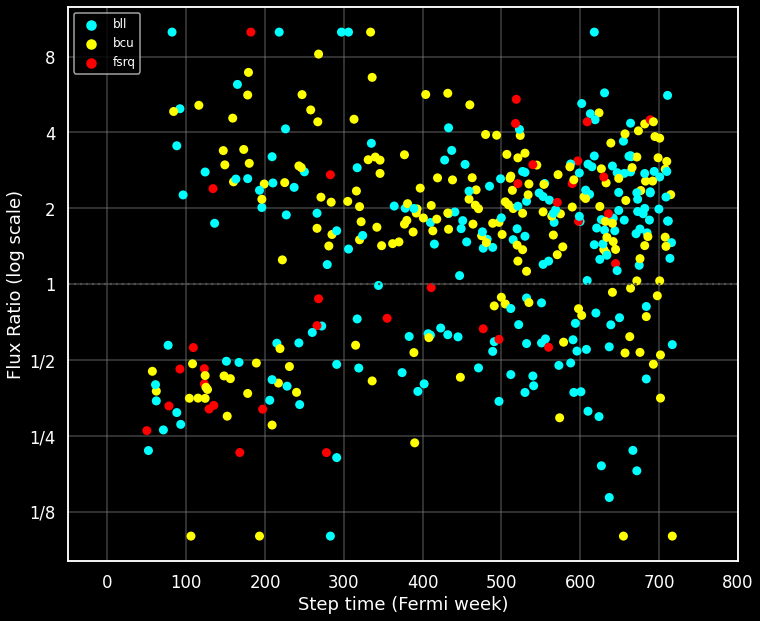

In [20]:
def ratio_display(df,  ax=None, **kwargs):
    
    eflux = df.eflux
    # sns.set_theme(font_scale=1.2)
    fig, ax = plt.subplots(figsize = (12,10)) if ax is None else (ax.figure, ax)
    r = df.flux_ratio
    
    sns.scatterplot(df, ax=ax, y=np.log10(r).clip(-1,1), 
                    x='time', hue='association', 
                    **kwargs, edgecolor='none',
                    # size=np.log10(eflux), sizes=(10, 150),
                )
    ax.set(xlim=(-50,800), xlabel='Step time (Fermi week)', 
        ylabel='Flux Ratio (log scale)')
    ax.axhline(0, color="0.3", ls=':' )
    ticks = np.log10(np.array([1/8,1/4, 1/2, 1, 2, 4,8]))
    ax.set( yticks=ticks, yticklabels='1/8 1/4 1/2 1 2 4 8'.split())
    ax.legend(loc='upper left', fontsize=12,)
    return fig
ratio_display(df, hue_order='bll bcu fsrq'.split(), 
              palette='cyan yellow red'.split());

## Steps: ratio vs. time for blazars

<utilities.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x78c20777eb00>
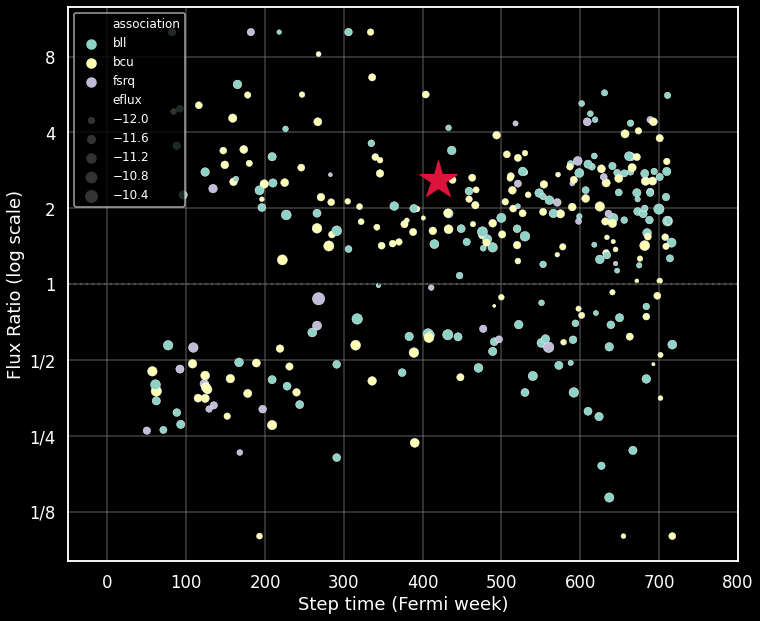

Notes:
* The star is the location, after correction for a nearby blazar, of PKS J2333-2343. Because of that, it was not included.
* There is a higher proportion of BL Lacs (9 %) than FSRQs (4 %)).
* There are more steps-up (208) than steps-down (98), and the up-steps concentrate, with higher flux ratios, at the end,
while the fewer down-steps are similarly concentrated at the start. These can be explained by the hypothesis that we are seeing transitions 
between discrete states, and the time spent in a higher state is less then the lower one. 

In [3]:
ratio_vs_time(df)

## Study the pulsar set to understand BB-induced background
We will compare this dataset with those for the other association categories.

<utilities.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x78c2076761a0>
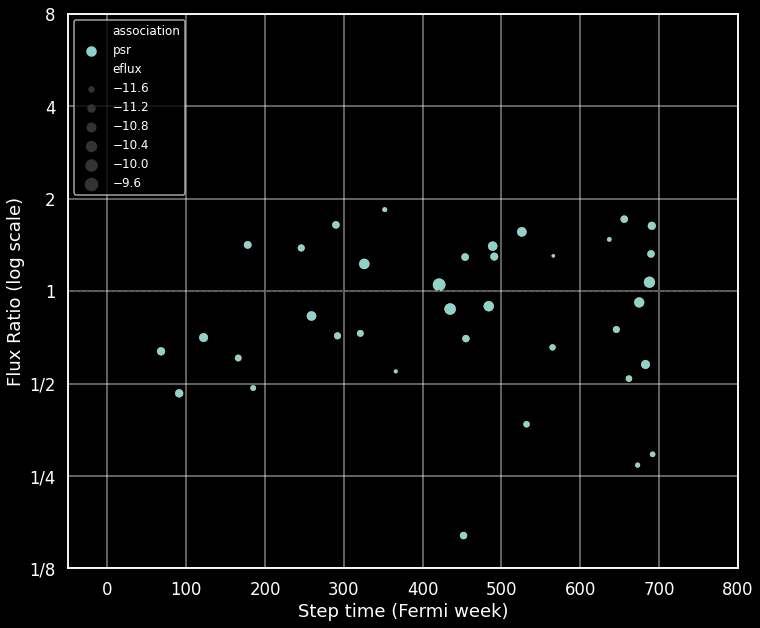

In [4]:
pulsar_only(fignum=2)

## Compare numbers of 2-block light curves with the single blocks
There are two reasons for 2-BB light curves to be 
related to the 1-BB ones.
1) Background: It is a false positive generated by the
BB algorithm. (We need to examine this possibility with a MC.)
2) Science: The source must have been quiet for at least 8 years, compared with 15 for 
the 1-block set. The rates must be part of same variability spectrum.

Here are the total numbers, for each of our six 
association classes:

,nbb=1,nbb=2,ratio
bcu,266,223,0.838346
bll,252,200,0.793651
fsrq,35,37,1.057143
other,167,59,0.353293
psr,161,49,0.304348
unid,917,354,0.386041


<utilities.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x78c20743c190>
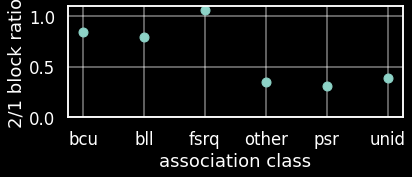

The distributions of the sizes of the steps.
The pulsar one should only reflect reason 1.

<utilities.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x78c20747e590>
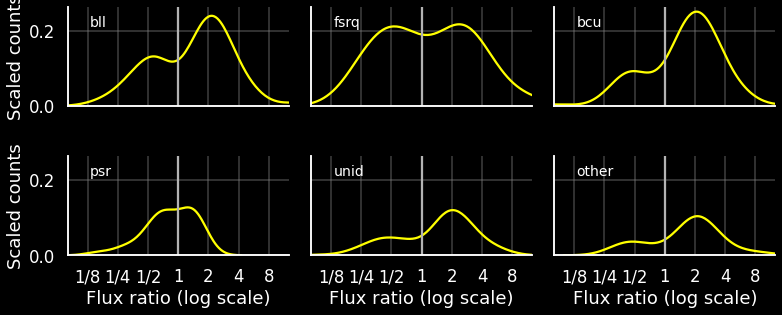

Notes:
* The range of the pulsar step sizes is  mostly limited to be less than 2.
* If the apparent pulsar steps are all spurious, its dristribution
above shouid be a component of all the others. This does not
appear to be the case, especially for the unid's.
* The asymmetry between up- and down-steps is dramatically
different. It appears from this that the most of the bcu's are 
BL Lacs, and a large proportion of the unid's are as well.

In [5]:
def block_2_1(fignum=3):
    show(f"""## Compare numbers of 2-block light curves with the single blocks
    There are two reasons for 2-BB light curves to be 
    related to the 1-BB ones.
    1) Background: It is a false positive generated by the
    BB algorithm. (We need to examine this possibility with a MC.)
    2) Science: The source must have been quiet for at least 8 years, compared with 15 for 
    the 1-block set. The rates must be part of same variability spectrum.
    
    Here are the total numbers, for each of our six 
    association classes:
    """)
    def get_unique(sclass, name=''):
        v,n = np.unique(sclass,  return_counts=True)
        df= pd.DataFrame.from_dict(
                dict(list(zip(v,n))), orient='index',
            )
        return df.rename(columns={0:name})
         
    ones, twos = dfx.query('nbb==1').copy(), dfx.query('nbb==2').copy()
    nbb1 = get_unique(ones.association, 'nbb=1')
    nbb2 = get_unique(twos.association, 'nbb=2')
    
    nbbstats = pd.concat([nbb1,nbb2], axis=1, )
    nbbstats.loc[:,'ratio'] = nbbstats.iloc[:,1]/nbbstats.iloc[:,0]
    show(nbbstats)
    fig,ax = plt.subplots(figsize=(6,2))
    ax.plot(nbbstats.ratio, 'o')
    ax.set(ylabel='2/1 block ratio', xlabel='association class', ylim=(0,None))
    show(fig)
    
    show(""" The distributions of the sizes of the steps.
    The pulsar one should only reflect reason 1.""")
    
    import warnings
    warnings.simplefilter("ignore", FutureWarning)
    
    df.loc[:,'log_ratio'] = np.log10(df.flux_ratio)
    col_order = 'bll fsrq bcu psr unid other'.split()
    sns.displot(df, x='log_ratio', # bins=np.linspace(-1,1,41),
                weights= 1/nbb1.loc[df.association].values.T[0],
                col='association',  col_wrap=3, 
                col_order=col_order,
                height=2.5, aspect=1.5, color='yellow',
                kind= 'kde', #element='step', fill=False,
    
               )
    for ax, col_name in zip(plt.gcf().axes, col_order):
        ax.set( xlabel='Flux ratio (log scale)', ylabel='Scaled counts') #, yscale='log')
        ax.axvline(0, color= "0.7"  , )
        ticks = np.log10(np.array([1/8,1/4, 1/2, 1, 2, 4,8]))
        ax.grid(color='0.5')
        ax.text(0.1, 0.8, col_name, fontsize=14, transform=ax.transAxes)
        ax.set(title='')
    ax.set(xlim=(-1.1,1.1),xticks=ticks, xticklabels='1/8 1/4 1/2 1 2 4 8'.split());
    
    show(ax.figure, fignum=fignum,
         caption="""Flux ratio KDE plots for each association 
    category. Counts are scaled by the inverse of the number of sources with nbb=1,
    so the total represents the fraction of nbb=2 to nbb=1. The pulsars are then 
    an estimate of the contribution of false positives to be applied to the others.
    """)
    show(f"""Notes:
    * The range of the pulsar step sizes is  mostly limited to be less than 2.
    * If the apparent pulsar steps are all spurious, its dristribution
    above shouid be a component of all the others. This does not
    appear to be the case, especially for the unid's.
    * The asymmetry between up- and down-steps is dramatically
    different. It appears from this that the most of the bcu's are 
    BL Lacs, and a large proportion of the unid's are as well.
    
    """)
block_2_1()

In [6]:
df.loc['4FGL J1520.8-0348']

flux_ratio       1.548196
time                530.0
t2                  237.0
ts             956.195736
association           bll
eflux                 0.0
log_ratio        0.189826
Name: 4FGL J1520.8-0348, dtype: object

In [7]:
show(f"""---
## The 10 strongest up-steppers 
Look for those with a step in the middle...""")
bdf = df[df.association.apply(lambda a: a in 'bll fsrq bcu'.split())].sort_values('ts', ascending=False).copy()
bdfq = bdf.query('flux_ratio>1.5 & 200<time<600')
show(bdfq.head(10))
# list(bdfq.index[:10])


---
## The 10 strongest up-steppers 
Look for those with a step in the middle...

,flux_ratio,time,t2,ts,association,eflux,log_ratio
4FGL J1520.8-0348,1.548196,530.0,237.0,956.195736,bll,1.003545e-11,0.189826
4FGL J1958.3-3010,1.881212,227.0,540.0,892.244490,bll,1.113501e-11,0.274438
4FGL J1351.3+1115,1.506500,482.0,285.0,840.822369,bll,7.311700e-12,0.177969
4FGL J1933.3+0726,1.627766,291.0,476.0,794.491179,bll,1.109402e-11,0.211592
4FGL J1404.8+0402,1.831530,500.0,267.0,691.640957,bll,7.116298e-12,0.262814
4FGL J1027.6+6317,1.910855,266.0,501.0,526.554025,bll,3.446296e-12,0.281228
4FGL J0653.7+2815,2.153286,561.0,206.0,518.430952,bll,5.373531e-12,0.333102
4FGL J0752.3-1631,1.650787,433.0,334.0,467.241645,bcu,5.860563e-12,0.217691
4FGL J1946.0-3112,1.907029,433.0,334.0,445.935064,bll,6.497949e-12,0.280357
4FGL J2357.4-1718,1.907821,566.0,201.0,401.251873,bll,4.556319e-12,0.280538


In [8]:
show(f""" ### Use full dataset, better BB""")
from utilities.ipynb_docgen import capture
bbd = dict()
for i,item in enumerate(bdfq.head(10).itertuples()):
    with capture():
        wtl = WtLike(item.Index)
        fits = wtl.bb_view().fits
        bbd[item.Index] = dict(
            fits=fits,
            ts_var = TSvar(fits.fit),
            n = len(fits),)

### Use full dataset, better BB

In [9]:
show(pd.DataFrame.from_dict(bbd, orient='index'))

,fits,ts_var,n
4FGL J1520.8-0348,"t tw n e fit 0 57735.0 6104.0 167698 360.533114 1.000[1+0.066-0.066], < 1.11",0.000000,1
4FGL J1958.3-3010,"t tw n e fit 0 55526.5 1687.0 48988 411.340703 0.630[1+0.158-0.159], < 0.80 1 58249.5 3759.0 106062 389.379365 1.179[1+0.070-0.070], < 1.32",18.252306,2
4FGL J1351.3+1115,"t tw n e fit 0 55141.5 917.0 12943 404.241025 0.420[1+0.259-0.294], < 0.65 1 57864.5 4529.0 57024 366.883549 1.131[1+0.069-0.069], < 1.26",18.516143,2
4FGL J1933.3+0726,"t tw n e fit 0 57406.0 5446.0 440245 388.688143 0.998[1+0.073-0.073], < 1.12",0.000000,1
4FGL J1404.8+0402,"t tw n e fit 0 56433.0 3500.0 47199 373.937437 0.794[1+0.100-0.100], < 0.93 1 59072.0 1778.0 21423 336.434886 1.503[1+0.090-0.090], < 1.73 2 60045.0 168.0 1742 308.352132 0.052[1+1.000-5.732], < 0.71",28.230128,3
4FGL J1027.6+6317,"t tw n e fit 0 55544.0 1722.0 37519 599.319931 0.525[1+0.207-0.226], < 0.74 1 58596.0 4382.0 111448 625.034295 1.196[1+0.080-0.080], < 1.35",17.156682,2
4FGL J0653.7+2815,"t tw n e fit 0 56646.5 3927.0 87565 418.481228 0.749[1+0.093-0.093], < 0.86 1 59698.5 2177.0 41971 351.580788 1.567[1+0.082-0.082], < 1.78",32.799576,2
4FGL J0752.3-1631,"t tw n e fit 0 56219.5 3073.0 105183 382.257190 0.751[1+0.132-0.133], < 0.92 1 58641.5 1771.0 61630 390.594831 1.566[1+0.099-0.099], < 1.82 2 59950.5 847.0 30764 410.079965 0.389[1+0.337-0.389], < 0.67 3 60580.5 413.0 14924 403.363579 1.689[1+0.199-0.215], < 2.33",36.131678,4
4FGL J1946.0-3112,"t tw n e fit 0 56202.0 3038.0 99816 445.640049 0.695[1+0.110-0.110], < 0.82 1 58851.5 2261.0 57790 339.667570 1.401[1+0.090-0.091], < 1.61 2 60111.5 259.0 6628 335.882047 0.061[1+1.000-4.017], < 0.59 3 60514.0 546.0 13573 326.569161 2.386[1+0.132-0.133], < 2.91",55.634612,4
4FGL J2357.4-1718,"t tw n e fit 0 57735.0 6104.0 77971 361.516413 1.000[1+0.117-0.117], < 1.19",0.000000,1


In [10]:
show(f"""---
## The 10 strongest down-steppers 
Look for those with a step in the middle...""")
bdfd = df[df.association.apply(lambda a: a in 'bll fsrq bcu'.split())].sort_values('ts', ascending=False).copy()
bdfqd = bdf.query('flux_ratio<1/1.5 & 200<time<600')
show(bdfqd.head(10))


bbdd = dict()
for i,item in enumerate(bdfqd.head(10).itertuples()):
    with capture():
        wtl = WtLike(item.Index)
        fits = wtl.bb_view().fits
        bbdd[item.Index] = dict(
            fit=fits.fit,
            ts_var = TSvar(fits.fit),
            n = len(fits),)

show(pd.DataFrame.from_dict(bbdd, orient='index'))

---
## The 10 strongest down-steppers 
Look for those with a step in the middle...

,flux_ratio,time,t2,ts,association,eflux,log_ratio
4FGL J2121.0+1901,0.561495,560.0,207.0,2845.287259,fsrq,1.892503e-11,-0.250654
4FGL J0754.4-1148,0.629726,432.0,335.0,1720.253430,bll,1.576066e-11,-0.200848
4FGL J0648.7+1516,0.635547,407.0,360.0,1303.508696,bll,1.344230e-11,-0.196852
4FGL J2346.7+0705,0.371640,592.0,175.0,734.003867,bll,9.335888e-12,-0.429878
4FGL J0725.8-0054,0.534838,389.0,378.0,733.177499,bcu,9.987622e-12,-0.271777
4FGL J2250.0+3825,0.431907,540.0,227.0,689.743405,bll,7.379602e-12,-0.364610
4FGL J0849.1+6607,0.619722,383.0,384.0,627.187896,bll,4.306990e-12,-0.207803
4FGL J2036.4+6553,0.642792,260.0,507.0,566.577647,bll,5.915386e-12,-0.191930
4FGL J1418.9+7731,0.393481,228.0,539.0,466.161182,bll,3.060710e-12,-0.405076
4FGL J1220.1+3432,0.475854,573.0,194.0,445.345710,bll,3.708478e-12,-0.322527


,fit,ts_var,n
4FGL J2121.0+1901,"0 1.181[1+0.030-0.030], < 1.24 1 0.634[1+0.066-0.066], < 0.70 2 1.045[1+0.102-0.103], < 1.22 Name: fit, dtype: object",100.136074,3
4FGL J0754.4-1148,"0 1.227[1+0.042-0.042], < 1.31 1 0.777[1+0.058-0.058], < 0.85 Name: fit, dtype: object",43.971487,2
4FGL J0648.7+1516,"0 0.959[1+0.063-0.063], < 1.06 1 2.428[1+0.197-0.219], < 3.39 Name: fit, dtype: object",11.975569,2
4FGL J2346.7+0705,"0 1.210[1+0.070-0.070], < 1.35 1 0.563[1+0.169-0.180], < 0.74 Name: fit, dtype: object",21.944114,2
4FGL J0725.8-0054,"0 1.259[1+0.069-0.069], < 1.40 1 0.558[1+0.156-0.157], < 0.70 2 1.074[1+0.115-0.116], < 1.28 Name: fit, dtype: object",34.509419,3
4FGL J2250.0+3825,"0 1.372[1+0.079-0.079], < 1.55 1 0.553[1+0.166-0.166], < 0.70 Name: fit, dtype: object",35.223409,2
4FGL J0849.1+6607,"0 1.175[1+0.076-0.076], < 1.32 1 0.524[1+0.213-0.231], < 0.74 Name: fit, dtype: object",16.586349,2
4FGL J2036.4+6553,"0 1.183[1+0.094-0.095], < 1.37 1 0.537[1+0.156-0.164], < 0.69 2 1.067[1+0.102-0.102], < 1.25 3 6.782[1+0.205-0.208], < 9.13 4 1.446[1+0.138-0.138], < 1.78 Name: fit, dtype: object",49.490752,5
4FGL J1418.9+7731,"0 1.732[1+0.109-0.110], < 2.05 1 0.706[1+0.126-0.126], < 0.85 Name: fit, dtype: object",25.840307,2
4FGL J1220.1+3432,"0 1.000[1+0.069-0.069], < 1.11 Name: fit, dtype: object",0.000000,1


### BL Lac



<details  class="nbdoc-description" >  <summary> Analysis printout for BL Lac (P88Y6076) </summary>  <div style="margin-left: 25px;"><pre>Source name, "BL Lac" <br>	located by astropy at ra,dec= 330.680, 42.278<br>	corresponds to uw1410 source "P88Y6076".<br>SourceData:  4FGL J2202.7+4216: Restoring from cache with key "P88Y6076_data"<br>SourceData: Source 4FGL J2202.7+4216 with:<br>	 data:       404,302 photons from 2008-08-04 to 2025-04-24<br>	 exposure: 4,326,472 intervals,  average effective area 3387 cm^2 for 129.4 Ms<br>	 rates:  source 3.22e-07/s, background 6.01e-07/s, TS 214315.2<br>CellData.rebin: Bin photon data into 872 1-week bins from 54683.0 to 60787.0<br>LightCurve: select 862 cells for fitting with e&gt;35.000 & n&gt;2<br>CellData.rebin: Bin photon data into 872 1-week bins from 54683.0 to 60787.0<br>LightCurve: select 862 cells for fitting with e&gt;35.000 & n&gt;2<br>Bayesian Blocks: partitioning 862  cells using LikelihoodFitness with penalty 5%<br>	found 225 / 862 blocks.<br>LightCurve: Loaded 225 / 225 cells for fitting<br>CellData.rebin: Bin photon data into 586176 15-min bins from 54683.0 to 60789.0<br></pre></div> </details>

<details  class="nbdoc-description" >  <summary> uw1410 (P88Y6076) <font color=red>(sep, r95 =0.6, 0.5 arcmin )</font> </summary>  <div style="margin-left: 25px;"><pre>jname                                 J2202.7+4216<br>fk5                              (330.692,+42.281)<br>galactic                         ( 92.599,-10.444)<br>specfunc    LogParabola(6.90e-11, 2.04, 0.08, 848)<br>e0                                         847.648<br>eflux100                                  3.79e-10<br>ts                                        2.14e+05<br>fitqual                                    114.620<br>locqual                                      0.100<br>aprob                                            0<br>r95                                          0.008<br>sep                                          0.010<br>Name: P88Y6076, dtype: object<br></pre></div> </details>
<details  class="nbdoc-description" >  <summary> 4FGL-DR4 (4FGL J2202.7+4216) <font color=red>(sep, r95 =0.7, 0.5 arcmin )</font> </summary>  <div style="margin-left: 25px;"><pre>fk5                                  (330.695,+42.282)<br>galactic                             ( 92.601,-10.444)<br>specfunc        LogParabola(5.03e-11, 2.08, 0.06, 992)<br>pivot                                          992.378<br>eflux                                         4.04e-10<br>significance                                   343.185<br>flags                                               {}<br>variability                                  25730.711<br>assoc_prob                                       1.000<br>class1                                             BLL<br>assoc1_name                                     BL Lac<br>r95                                              0.009<br>sep                                              0.011<br>Name: 4FGL J2202.7+4216, dtype: object<br></pre></div> </details>
<div style="margin-left: 10px"><a id="Figure_None"/><figure style="margin-left: 10px">   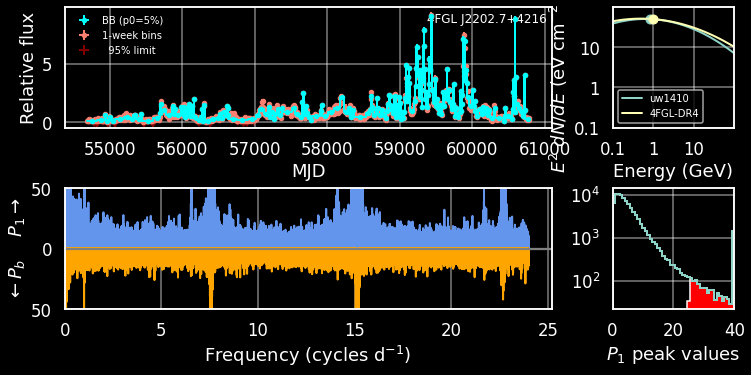 <br> </figure></div>
<details >  <summary> 3 nearby variable sources </summary>  <div style="margin-left: 25px"><table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>sep</th>
      <th>glon</th>
      <th>glat</th>
      <th>significance</th>
      <th>variability</th>
    </tr>
    <tr>
      <th>4FGL-DR4</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>4FGL J2202.7+4216</th>
      <td>0.011</td>
      <td>92.601</td>
      <td>-10.444</td>
      <td>343.185</td>
      <td>25730.711</td>
    </tr>
    <tr>
      <th>4FGL J2208.1+4058</th>
      <td>1.653</td>
      <td>92.618</td>
      <td>-12.094</td>
      <td>8.510</td>
      <td>40.450</td>
    </tr>
    <tr>
      <th>4FGL J2209.4+4329</th>
      <td>1.720</td>
      <td>94.321</td>
      <td>-10.204</td>
      <td>9.411</td>
      <td>73.649</td>
    </tr>
  </tbody>
</table></div> </details>
<details >  <summary> 225 BB fits <font color=red>Check beta:  max beta/sig_beta is 3.4</font> </summary>  <div style="margin-left: 25px"><table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>t</th>
      <th>tw</th>
      <th>ts</th>
      <th>flux</th>
      <th>errors</th>
      <th>flux</th>
      <th>beta</th>
      <th>sig_beta</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>54756.500</td>
      <td>147.000</td>
      <td>297.000</td>
      <td>0.140</td>
      <td>(-0.012, 0.012)</td>
      <td>0.150</td>
      <td>-0.029</td>
      <td>0.014</td>
    </tr>
    <tr>
      <td>54879.000</td>
      <td>98.000</td>
      <td>333.200</td>
      <td>0.216</td>
      <td>(-0.017, 0.018)</td>
      <td>0.217</td>
      <td>-0.001</td>
      <td>0.018</td>
    </tr>
    <tr>
      <td>54935.000</td>
      <td>14.000</td>
      <td>270.800</td>
      <td>0.608</td>
      <td>(-0.064, 0.066)</td>
      <td>0.618</td>
      <td>-0.019</td>
      <td>0.053</td>
    </tr>
    <tr>
      <td>54966.500</td>
      <td>49.000</td>
      <td>48.700</td>
      <td>0.090</td>
      <td>(-0.017, 0.019)</td>
      <td>0.105</td>
      <td>-0.060</td>
      <td>0.024</td>
    </tr>
    <tr>
      <td>55001.500</td>
      <td>21.000</td>
      <td>268.100</td>
      <td>0.442</td>
      <td>(-0.045, 0.046)</td>
      <td>0.437</td>
      <td>0.010</td>
      <td>0.040</td>
    </tr>
    <tr>
      <td>55043.500</td>
      <td>63.000</td>
      <td>126.400</td>
      <td>0.137</td>
      <td>(-0.018, 0.018)</td>
      <td>0.145</td>
      <td>-0.027</td>
      <td>0.021</td>
    </tr>
    <tr>
      <td>55134.500</td>
      <td>119.000</td>
      <td>841.700</td>
      <td>0.303</td>
      <td>(-0.017, 0.017)</td>
      <td>0.289</td>
      <td>0.031</td>
      <td>0.016</td>
    </tr>
    <tr>
      <td>55236.000</td>
      <td>84.000</td>
      <td>1119.900</td>
      <td>0.467</td>
      <td>(-0.023, 0.023)</td>
      <td>0.448</td>
      <td>0.036</td>
      <td>0.020</td>
    </tr>
    <tr>
      <td>55299.000</td>
      <td>42.000</td>
      <td>297.700</td>
      <td>0.310</td>
      <td>(-0.027, 0.028)</td>
      <td>0.301</td>
      <td>0.021</td>
      <td>0.027</td>
    </tr>
    <tr>
      <td>55341.000</td>
      <td>42.000</td>
      <td>826.100</td>
      <td>0.599</td>
      <td>(-0.035, 0.036)</td>
      <td>0.563</td>
      <td>0.066</td>
      <td>0.029</td>
    </tr>
    <tr>
      <td>55397.000</td>
      <td>70.000</td>
      <td>363.800</td>
      <td>0.249</td>
      <td>(-0.02, 0.021)</td>
      <td>0.263</td>
      <td>-0.033</td>
      <td>0.021</td>
    </tr>
    <tr>
      <td>55435.500</td>
      <td>7.000</td>
      <td>149.800</td>
      <td>0.675</td>
      <td>(-0.097, 0.101)</td>
      <td>0.719</td>
      <td>-0.077</td>
      <td>0.076</td>
    </tr>
    <tr>
      <td>55519.500</td>
      <td>161.000</td>
      <td>359.700</td>
      <td>0.153</td>
      <td>(-0.012, 0.012)</td>
      <td>0.156</td>
      <td>-0.009</td>
      <td>0.014</td>
    </tr>
    <tr>
      <td>55645.500</td>
      <td>91.000</td>
      <td>734.400</td>
      <td>0.333</td>
      <td>(-0.019, 0.019)</td>
      <td>0.325</td>
      <td>0.018</td>
      <td>0.018</td>
    </tr>
    <tr>
      <td>55694.500</td>
      <td>7.000</td>
      <td>194.500</td>
      <td>0.791</td>
      <td>(-0.092, 0.095)</td>
      <td>0.739</td>
      <td>0.079</td>
      <td>0.072</td>
    </tr>
    <tr>
      <td>55705.000</td>
      <td>14.000</td>
      <td>1091.000</td>
      <td>1.571</td>
      <td>(-0.087, 0.089)</td>
      <td>1.493</td>
      <td>0.100</td>
      <td>0.056</td>
    </tr>
    <tr>
      <td>55743.500</td>
      <td>63.000</td>
      <td>2848.000</td>
      <td>1.034</td>
      <td>(-0.035, 0.035)</td>
      <td>1.026</td>
      <td>0.012</td>
      <td>0.025</td>
    </tr>
    <tr>
      <td>55817.000</td>
      <td>84.000</td>
      <td>1666.500</td>
      <td>0.617</td>
      <td>(-0.026, 0.026)</td>
      <td>0.631</td>
      <td>-0.024</td>
      <td>0.021</td>
    </tr>
    <tr>
      <td>55866.000</td>
      <td>14.000</td>
      <td>662.600</td>
      <td>1.351</td>
      <td>(-0.091, 0.094)</td>
      <td>1.305</td>
      <td>0.059</td>
      <td>0.062</td>
    </tr>
    <tr>
      <td>55883.500</td>
      <td>21.000</td>
      <td>536.600</td>
      <td>0.711</td>
      <td>(-0.052, 0.053)</td>
      <td>0.691</td>
      <td>0.033</td>
      <td>0.041</td>
    </tr>
    <tr>
      <td>55901.000</td>
      <td>14.000</td>
      <td>766.600</td>
      <td>1.106</td>
      <td>(-0.071, 0.072)</td>
      <td>1.076</td>
      <td>0.043</td>
      <td>0.050</td>
    </tr>
    <tr>
      <td>55943.000</td>
      <td>70.000</td>
      <td>1431.900</td>
      <td>0.659</td>
      <td>(-0.029, 0.029)</td>
      <td>0.643</td>
      <td>0.028</td>
      <td>0.023</td>
    </tr>
    <tr>
      <td>55985.000</td>
      <td>14.000</td>
      <td>826.600</td>
      <td>1.298</td>
      <td>(-0.083, 0.085)</td>
      <td>1.285</td>
      <td>0.018</td>
      <td>0.055</td>
    </tr>
    <tr>
      <td>56002.500</td>
      <td>21.000</td>
      <td>667.500</td>
      <td>0.736</td>
      <td>(-0.048, 0.049)</td>
      <td>0.715</td>
      <td>0.035</td>
      <td>0.038</td>
    </tr>
    <tr>
      <td>56023.500</td>
      <td>21.000</td>
      <td>1114.400</td>
      <td>1.292</td>
      <td>(-0.07, 0.071)</td>
      <td>1.174</td>
      <td>0.163</td>
      <td>0.048</td>
    </tr>
    <tr>
      <td>56041.000</td>
      <td>14.000</td>
      <td>178.900</td>
      <td>0.449</td>
      <td>(-0.054, 0.055)</td>
      <td>0.438</td>
      <td>0.022</td>
      <td>0.048</td>
    </tr>
    <tr>
      <td>56058.500</td>
      <td>21.000</td>
      <td>1054.300</td>
      <td>1.094</td>
      <td>(-0.06, 0.061)</td>
      <td>1.019</td>
      <td>0.109</td>
      <td>0.043</td>
    </tr>
    <tr>
      <td>56076.000</td>
      <td>14.000</td>
      <td>331.800</td>
      <td>0.682</td>
      <td>(-0.063, 0.064)</td>
      <td>0.645</td>
      <td>0.063</td>
      <td>0.051</td>
    </tr>
    <tr>
      <td>56086.500</td>
      <td>7.000</td>
      <td>546.700</td>
      <td>1.569</td>
      <td>(-0.125, 0.129)</td>
      <td>1.406</td>
      <td>0.212</td>
      <td>0.083</td>
    </tr>
    <tr>
      <td>56107.500</td>
      <td>35.000</td>
      <td>625.500</td>
      <td>0.570</td>
      <td>(-0.038, 0.039)</td>
      <td>0.538</td>
      <td>0.060</td>
      <td>0.032</td>
    </tr>
    <tr>
      <td>56128.500</td>
      <td>7.000</td>
      <td>403.900</td>
      <td>1.426</td>
      <td>(-0.122, 0.126)</td>
      <td>1.370</td>
      <td>0.074</td>
      <td>0.081</td>
    </tr>
    <tr>
      <td>56146.000</td>
      <td>28.000</td>
      <td>400.000</td>
      <td>0.510</td>
      <td>(-0.042, 0.043)</td>
      <td>0.496</td>
      <td>0.025</td>
      <td>0.036</td>
    </tr>
    <tr>
      <td>56163.500</td>
      <td>7.000</td>
      <td>786.300</td>
      <td>1.972</td>
      <td>(-0.132, 0.136)</td>
      <td>2.017</td>
      <td>-0.053</td>
      <td>0.078</td>
    </tr>
    <tr>
      <td>56177.500</td>
      <td>21.000</td>
      <td>248.400</td>
      <td>0.433</td>
      <td>(-0.046, 0.047)</td>
      <td>0.431</td>
      <td>0.004</td>
      <td>0.041</td>
    </tr>
    <tr>
      <td>56223.000</td>
      <td>70.000</td>
      <td>197.600</td>
      <td>0.186</td>
      <td>(-0.018, 0.019)</td>
      <td>0.161</td>
      <td>0.067</td>
      <td>0.020</td>
    </tr>
    <tr>
      <td>56261.500</td>
      <td>7.000</td>
      <td>112.400</td>
      <td>0.428</td>
      <td>(-0.069, 0.072)</td>
      <td>0.441</td>
      <td>-0.031</td>
      <td>0.063</td>
    </tr>
    <tr>
      <td>56268.500</td>
      <td>7.000</td>
      <td>373.800</td>
      <td>1.105</td>
      <td>(-0.101, 0.104)</td>
      <td>0.980</td>
      <td>0.179</td>
      <td>0.073</td>
    </tr>
    <tr>
      <td>56282.500</td>
      <td>21.000</td>
      <td>40.500</td>
      <td>0.147</td>
      <td>(-0.032, 0.035)</td>
      <td>0.132</td>
      <td>0.045</td>
      <td>0.039</td>
    </tr>
    <tr>
      <td>56300.000</td>
      <td>14.000</td>
      <td>825.600</td>
      <td>1.486</td>
      <td>(-0.095, 0.097)</td>
      <td>1.401</td>
      <td>0.110</td>
      <td>0.063</td>
    </tr>
    <tr>
      <td>56349.000</td>
      <td>84.000</td>
      <td>97.600</td>
      <td>0.100</td>
      <td>(-0.014, 0.015)</td>
      <td>0.090</td>
      <td>0.034</td>
      <td>0.019</td>
    </tr>
    <tr>
      <td>56426.000</td>
      <td>70.000</td>
      <td>385.100</td>
      <td>0.256</td>
      <td>(-0.02, 0.02)</td>
      <td>0.252</td>
      <td>0.008</td>
      <td>0.020</td>
    </tr>
    <tr>
      <td>56485.500</td>
      <td>49.000</td>
      <td>497.300</td>
      <td>0.408</td>
      <td>(-0.029, 0.03)</td>
      <td>0.412</td>
      <td>-0.009</td>
      <td>0.027</td>
    </tr>
    <tr>
      <td>56520.500</td>
      <td>21.000</td>
      <td>620.700</td>
      <td>0.686</td>
      <td>(-0.046, 0.046)</td>
      <td>0.655</td>
      <td>0.050</td>
      <td>0.036</td>
    </tr>
    <tr>
      <td>56541.500</td>
      <td>21.000</td>
      <td>157.200</td>
      <td>0.385</td>
      <td>(-0.048, 0.049)</td>
      <td>0.358</td>
      <td>0.053</td>
      <td>0.044</td>
    </tr>
    <tr>
      <td>56573.000</td>
      <td>42.000</td>
      <td>1229.100</td>
      <td>0.859</td>
      <td>(-0.043, 0.044)</td>
      <td>0.831</td>
      <td>0.045</td>
      <td>0.032</td>
    </tr>
    <tr>
      <td>56604.500</td>
      <td>21.000</td>
      <td>306.000</td>
      <td>0.590</td>
      <td>(-0.054, 0.055)</td>
      <td>0.540</td>
      <td>0.084</td>
      <td>0.045</td>
    </tr>
    <tr>
      <td>56618.500</td>
      <td>7.000</td>
      <td>379.000</td>
      <td>1.363</td>
      <td>(-0.128, 0.132)</td>
      <td>1.312</td>
      <td>0.073</td>
      <td>0.085</td>
    </tr>
    <tr>
      <td>56625.500</td>
      <td>7.000</td>
      <td>114.000</td>
      <td>0.604</td>
      <td>(-0.089, 0.093)</td>
      <td>0.607</td>
      <td>-0.006</td>
      <td>0.074</td>
    </tr>
    <tr>
      <td>56632.500</td>
      <td>7.000</td>
      <td>164.300</td>
      <td>1.251</td>
      <td>(-0.161, 0.167)</td>
      <td>1.090</td>
      <td>0.205</td>
      <td>0.115</td>
    </tr>
    <tr>
      <td>56692.000</td>
      <td>112.000</td>
      <td>618.100</td>
      <td>0.326</td>
      <td>(-0.021, 0.021)</td>
      <td>0.313</td>
      <td>0.029</td>
      <td>0.020</td>
    </tr>
    <tr>
      <td>56825.000</td>
      <td>154.000</td>
      <td>304.200</td>
      <td>0.161</td>
      <td>(-0.014, 0.014)</td>
      <td>0.165</td>
      <td>-0.010</td>
      <td>0.016</td>
    </tr>
    <tr>
      <td>56961.500</td>
      <td>119.000</td>
      <td>403.200</td>
      <td>0.254</td>
      <td>(-0.019, 0.02)</td>
      <td>0.247</td>
      <td>0.017</td>
      <td>0.020</td>
    </tr>
    <tr>
      <td>57038.500</td>
      <td>35.000</td>
      <td>641.100</td>
      <td>0.602</td>
      <td>(-0.041, 0.042)</td>
      <td>0.590</td>
      <td>0.022</td>
      <td>0.034</td>
    </tr>
    <tr>
      <td>57091.000</td>
      <td>70.000</td>
      <td>2841.900</td>
      <td>1.167</td>
      <td>(-0.039, 0.04)</td>
      <td>1.121</td>
      <td>0.065</td>
      <td>0.027</td>
    </tr>
    <tr>
      <td>57154.000</td>
      <td>56.000</td>
      <td>1366.900</td>
      <td>0.720</td>
      <td>(-0.032, 0.033)</td>
      <td>0.689</td>
      <td>0.050</td>
      <td>0.025</td>
    </tr>
    <tr>
      <td>57192.500</td>
      <td>21.000</td>
      <td>1254.200</td>
      <td>1.305</td>
      <td>(-0.069, 0.07)</td>
      <td>1.297</td>
      <td>0.011</td>
      <td>0.046</td>
    </tr>
    <tr>
      <td>57210.000</td>
      <td>14.000</td>
      <td>185.400</td>
      <td>0.479</td>
      <td>(-0.057, 0.059)</td>
      <td>0.499</td>
      <td>-0.038</td>
      <td>0.049</td>
    </tr>
    <tr>
      <td>57238.000</td>
      <td>42.000</td>
      <td>1477.200</td>
      <td>0.903</td>
      <td>(-0.042, 0.042)</td>
      <td>0.877</td>
      <td>0.040</td>
      <td>0.031</td>
    </tr>
    <tr>
      <td>57262.500</td>
      <td>7.000</td>
      <td>40.500</td>
      <td>0.276</td>
      <td>(-0.062, 0.069)</td>
      <td>0.295</td>
      <td>-0.046</td>
      <td>0.066</td>
    </tr>
    <tr>
      <td>57283.500</td>
      <td>35.000</td>
      <td>791.900</td>
      <td>0.669</td>
      <td>(-0.039, 0.04)</td>
      <td>0.671</td>
      <td>-0.004</td>
      <td>0.031</td>
    </tr>
    <tr>
      <td>57315.000</td>
      <td>28.000</td>
      <td>1333.700</td>
      <td>1.138</td>
      <td>(-0.055, 0.056)</td>
      <td>1.106</td>
      <td>0.046</td>
      <td>0.038</td>
    </tr>
    <tr>
      <td>57350.000</td>
      <td>42.000</td>
      <td>834.400</td>
      <td>0.646</td>
      <td>(-0.037, 0.037)</td>
      <td>0.626</td>
      <td>0.033</td>
      <td>0.030</td>
    </tr>
    <tr>
      <td>57378.000</td>
      <td>14.000</td>
      <td>1061.400</td>
      <td>1.250</td>
      <td>(-0.074, 0.076)</td>
      <td>1.279</td>
      <td>-0.042</td>
      <td>0.049</td>
    </tr>
    <tr>
      <td>57448.000</td>
      <td>126.000</td>
      <td>4953.600</td>
      <td>0.911</td>
      <td>(-0.023, 0.023)</td>
      <td>0.926</td>
      <td>-0.023</td>
      <td>0.017</td>
    </tr>
    <tr>
      <td>57535.500</td>
      <td>49.000</td>
      <td>3279.600</td>
      <td>1.261</td>
      <td>(-0.041, 0.042)</td>
      <td>1.268</td>
      <td>-0.009</td>
      <td>0.027</td>
    </tr>
    <tr>
      <td>57584.500</td>
      <td>49.000</td>
      <td>954.300</td>
      <td>0.669</td>
      <td>(-0.038, 0.038)</td>
      <td>0.646</td>
      <td>0.040</td>
      <td>0.030</td>
    </tr>
    <tr>
      <td>57630.000</td>
      <td>42.000</td>
      <td>503.200</td>
      <td>0.429</td>
      <td>(-0.032, 0.032)</td>
      <td>0.429</td>
      <td>-0.002</td>
      <td>0.028</td>
    </tr>
    <tr>
      <td>57654.500</td>
      <td>7.000</td>
      <td>717.800</td>
      <td>1.705</td>
      <td>(-0.122, 0.126)</td>
      <td>1.641</td>
      <td>0.082</td>
      <td>0.077</td>
    </tr>
    <tr>
      <td>57661.500</td>
      <td>7.000</td>
      <td>210.000</td>
      <td>0.846</td>
      <td>(-0.106, 0.11)</td>
      <td>0.875</td>
      <td>-0.049</td>
      <td>0.079</td>
    </tr>
    <tr>
      <td>57668.500</td>
      <td>7.000</td>
      <td>880.800</td>
      <td>2.461</td>
      <td>(-0.172, 0.177)</td>
      <td>2.530</td>
      <td>-0.085</td>
      <td>0.092</td>
    </tr>
    <tr>
      <td>57689.500</td>
      <td>35.000</td>
      <td>742.200</td>
      <td>0.680</td>
      <td>(-0.044, 0.045)</td>
      <td>0.698</td>
      <td>-0.032</td>
      <td>0.035</td>
    </tr>
    <tr>
      <td>57710.500</td>
      <td>7.000</td>
      <td>527.600</td>
      <td>1.412</td>
      <td>(-0.115, 0.119)</td>
      <td>1.456</td>
      <td>-0.062</td>
      <td>0.074</td>
    </tr>
    <tr>
      <td>57721.000</td>
      <td>14.000</td>
      <td>369.500</td>
      <td>0.788</td>
      <td>(-0.071, 0.073)</td>
      <td>0.740</td>
      <td>0.082</td>
      <td>0.055</td>
    </tr>
    <tr>
      <td>57749.000</td>
      <td>42.000</td>
      <td>791.000</td>
      <td>0.470</td>
      <td>(-0.028, 0.029)</td>
      <td>0.464</td>
      <td>0.014</td>
      <td>0.025</td>
    </tr>
    <tr>
      <td>57780.500</td>
      <td>21.000</td>
      <td>91.900</td>
      <td>0.224</td>
      <td>(-0.039, 0.04)</td>
      <td>0.201</td>
      <td>0.062</td>
      <td>0.042</td>
    </tr>
    <tr>
      <td>57847.000</td>
      <td>112.000</td>
      <td>1813.800</td>
      <td>0.502</td>
      <td>(-0.02, 0.02)</td>
      <td>0.506</td>
      <td>-0.010</td>
      <td>0.017</td>
    </tr>
    <tr>
      <td>57910.000</td>
      <td>14.000</td>
      <td>600.000</td>
      <td>0.936</td>
      <td>(-0.068, 0.069)</td>
      <td>0.975</td>
      <td>-0.063</td>
      <td>0.049</td>
    </tr>
    <tr>
      <td>57920.500</td>
      <td>7.000</td>
      <td>592.900</td>
      <td>1.491</td>
      <td>(-0.113, 0.117)</td>
      <td>1.423</td>
      <td>0.089</td>
      <td>0.075</td>
    </tr>
    <tr>
      <td>57966.000</td>
      <td>84.000</td>
      <td>1395.800</td>
      <td>0.561</td>
      <td>(-0.025, 0.026)</td>
      <td>0.576</td>
      <td>-0.028</td>
      <td>0.021</td>
    </tr>
    <tr>
      <td>58050.000</td>
      <td>84.000</td>
      <td>2933.100</td>
      <td>0.864</td>
      <td>(-0.029, 0.029)</td>
      <td>0.877</td>
      <td>-0.020</td>
      <td>0.021</td>
    </tr>
    <tr>
      <td>58134.000</td>
      <td>84.000</td>
      <td>4734.000</td>
      <td>1.181</td>
      <td>(-0.032, 0.033)</td>
      <td>1.199</td>
      <td>-0.027</td>
      <td>0.022</td>
    </tr>
    <tr>
      <td>58204.000</td>
      <td>56.000</td>
      <td>2357.200</td>
      <td>2.121</td>
      <td>(-0.089, 0.091)</td>
      <td>2.190</td>
      <td>-0.086</td>
      <td>0.050</td>
    </tr>
    <tr>
      <td>58260.000</td>
      <td>56.000</td>
      <td>2045.000</td>
      <td>0.887</td>
      <td>(-0.034, 0.035)</td>
      <td>0.868</td>
      <td>0.030</td>
      <td>0.025</td>
    </tr>
    <tr>
      <td>58298.500</td>
      <td>21.000</td>
      <td>1303.000</td>
      <td>1.253</td>
      <td>(-0.064, 0.066)</td>
      <td>1.253</td>
      <td>-1.69e-05</td>
      <td>0.043</td>
    </tr>
    <tr>
      <td>58312.500</td>
      <td>7.000</td>
      <td>271.000</td>
      <td>0.784</td>
      <td>(-0.078, 0.08)</td>
      <td>0.747</td>
      <td>0.055</td>
      <td>0.061</td>
    </tr>
    <tr>
      <td>58323.000</td>
      <td>14.000</td>
      <td>217.600</td>
      <td>0.439</td>
      <td>(-0.049, 0.05)</td>
      <td>0.454</td>
      <td>-0.031</td>
      <td>0.044</td>
    </tr>
    <tr>
      <td>58351.000</td>
      <td>42.000</td>
      <td>2460.700</td>
      <td>1.040</td>
      <td>(-0.038, 0.039)</td>
      <td>1.039</td>
      <td>6.25e-04</td>
      <td>0.027</td>
    </tr>
    <tr>
      <td>58452.500</td>
      <td>161.000</td>
      <td>3164.400</td>
      <td>0.455</td>
      <td>(-0.014, 0.014)</td>
      <td>0.458</td>
      <td>-0.005</td>
      <td>0.012</td>
    </tr>
    <tr>
      <td>58557.500</td>
      <td>49.000</td>
      <td>1607.900</td>
      <td>0.777</td>
      <td>(-0.035, 0.035)</td>
      <td>0.823</td>
      <td>-0.079</td>
      <td>0.026</td>
    </tr>
    <tr>
      <td>58589.000</td>
      <td>14.000</td>
      <td>822.400</td>
      <td>1.063</td>
      <td>(-0.069, 0.071)</td>
      <td>1.087</td>
      <td>-0.036</td>
      <td>0.048</td>
    </tr>
    <tr>
      <td>58603.000</td>
      <td>14.000</td>
      <td>2577.400</td>
      <td>2.283</td>
      <td>(-0.094, 0.095)</td>
      <td>2.372</td>
      <td>-0.108</td>
      <td>0.051</td>
    </tr>
    <tr>
      <td>58617.000</td>
      <td>14.000</td>
      <td>1014.600</td>
      <td>1.335</td>
      <td>(-0.079, 0.081)</td>
      <td>1.368</td>
      <td>-0.047</td>
      <td>0.051</td>
    </tr>
    <tr>
      <td>58645.000</td>
      <td>42.000</td>
      <td>1312.100</td>
      <td>0.635</td>
      <td>(-0.031, 0.031)</td>
      <td>0.646</td>
      <td>-0.022</td>
      <td>0.025</td>
    </tr>
    <tr>
      <td>58673.000</td>
      <td>14.000</td>
      <td>1017.200</td>
      <td>1.145</td>
      <td>(-0.068, 0.069)</td>
      <td>1.211</td>
      <td>-0.102</td>
      <td>0.045</td>
    </tr>
    <tr>
      <td>58683.500</td>
      <td>7.000</td>
      <td>1414.100</td>
      <td>2.033</td>
      <td>(-0.107, 0.109)</td>
      <td>2.118</td>
      <td>-0.107</td>
      <td>0.060</td>
    </tr>
    <tr>
      <td>58694.000</td>
      <td>14.000</td>
      <td>1045.300</td>
      <td>1.179</td>
      <td>(-0.067, 0.068)</td>
      <td>1.155</td>
      <td>0.034</td>
      <td>0.046</td>
    </tr>
    <tr>
      <td>58722.000</td>
      <td>42.000</td>
      <td>1227.500</td>
      <td>0.663</td>
      <td>(-0.033, 0.034)</td>
      <td>0.683</td>
      <td>-0.036</td>
      <td>0.026</td>
    </tr>
    <tr>
      <td>58753.500</td>
      <td>21.000</td>
      <td>824.600</td>
      <td>1.078</td>
      <td>(-0.067, 0.068)</td>
      <td>1.072</td>
      <td>0.010</td>
      <td>0.047</td>
    </tr>
    <tr>
      <td>58778.000</td>
      <td>28.000</td>
      <td>554.500</td>
      <td>0.613</td>
      <td>(-0.044, 0.045)</td>
      <td>0.632</td>
      <td>-0.036</td>
      <td>0.036</td>
    </tr>
    <tr>
      <td>58802.500</td>
      <td>21.000</td>
      <td>213.200</td>
      <td>0.347</td>
      <td>(-0.038, 0.038)</td>
      <td>0.334</td>
      <td>0.031</td>
      <td>0.036</td>
    </tr>
    <tr>
      <td>58820.000</td>
      <td>14.000</td>
      <td>644.300</td>
      <td>0.950</td>
      <td>(-0.067, 0.068)</td>
      <td>0.941</td>
      <td>0.014</td>
      <td>0.049</td>
    </tr>
    <tr>
      <td>58837.500</td>
      <td>21.000</td>
      <td>2042.600</td>
      <td>1.530</td>
      <td>(-0.064, 0.065)</td>
      <td>1.503</td>
      <td>0.036</td>
      <td>0.041</td>
    </tr>
    <tr>
      <td>58851.500</td>
      <td>7.000</td>
      <td>1767.400</td>
      <td>2.307</td>
      <td>(-0.108, 0.11)</td>
      <td>2.303</td>
      <td>0.005</td>
      <td>0.061</td>
    </tr>
    <tr>
      <td>58858.500</td>
      <td>7.000</td>
      <td>585.300</td>
      <td>1.483</td>
      <td>(-0.11, 0.113)</td>
      <td>1.559</td>
      <td>-0.097</td>
      <td>0.069</td>
    </tr>
    <tr>
      <td>58865.500</td>
      <td>7.000</td>
      <td>1054.200</td>
      <td>2.222</td>
      <td>(-0.133, 0.136)</td>
      <td>2.235</td>
      <td>-0.015</td>
      <td>0.077</td>
    </tr>
    <tr>
      <td>58879.500</td>
      <td>21.000</td>
      <td>1289.800</td>
      <td>1.147</td>
      <td>(-0.057, 0.057)</td>
      <td>1.072</td>
      <td>0.108</td>
      <td>0.040</td>
    </tr>
    <tr>
      <td>58904.000</td>
      <td>28.000</td>
      <td>1017.000</td>
      <td>0.783</td>
      <td>(-0.042, 0.043)</td>
      <td>0.744</td>
      <td>0.065</td>
      <td>0.033</td>
    </tr>
    <tr>
      <td>58928.500</td>
      <td>21.000</td>
      <td>2982.200</td>
      <td>2.234</td>
      <td>(-0.08, 0.082)</td>
      <td>2.202</td>
      <td>0.038</td>
      <td>0.046</td>
    </tr>
    <tr>
      <td>58949.500</td>
      <td>21.000</td>
      <td>268.300</td>
      <td>0.484</td>
      <td>(-0.047, 0.048)</td>
      <td>0.449</td>
      <td>0.066</td>
      <td>0.042</td>
    </tr>
    <tr>
      <td>58963.500</td>
      <td>7.000</td>
      <td>740.300</td>
      <td>1.514</td>
      <td>(-0.106, 0.108)</td>
      <td>1.510</td>
      <td>0.005</td>
      <td>0.067</td>
    </tr>
    <tr>
      <td>58977.500</td>
      <td>21.000</td>
      <td>395.100</td>
      <td>0.548</td>
      <td>(-0.046, 0.046)</td>
      <td>0.530</td>
      <td>0.033</td>
      <td>0.039</td>
    </tr>
    <tr>
      <td>58991.500</td>
      <td>7.000</td>
      <td>944.700</td>
      <td>2.126</td>
      <td>(-0.137, 0.141)</td>
      <td>2.045</td>
      <td>0.102</td>
      <td>0.080</td>
    </tr>
    <tr>
      <td>58998.500</td>
      <td>7.000</td>
      <td>226.600</td>
      <td>0.674</td>
      <td>(-0.082, 0.084)</td>
      <td>0.649</td>
      <td>0.048</td>
      <td>0.066</td>
    </tr>
    <tr>
      <td>59005.500</td>
      <td>7.000</td>
      <td>1008.300</td>
      <td>1.677</td>
      <td>(-0.101, 0.103)</td>
      <td>1.658</td>
      <td>0.025</td>
      <td>0.063</td>
    </tr>
    <tr>
      <td>59012.500</td>
      <td>7.000</td>
      <td>297.700</td>
      <td>0.642</td>
      <td>(-0.063, 0.064)</td>
      <td>0.636</td>
      <td>0.010</td>
      <td>0.051</td>
    </tr>
    <tr>
      <td>59019.500</td>
      <td>7.000</td>
      <td>41.600</td>
      <td>0.262</td>
      <td>(-0.055, 0.06)</td>
      <td>0.257</td>
      <td>0.012</td>
      <td>0.058</td>
    </tr>
    <tr>
      <td>59030.000</td>
      <td>14.000</td>
      <td>530.100</td>
      <td>0.838</td>
      <td>(-0.064, 0.066)</td>
      <td>0.835</td>
      <td>0.004</td>
      <td>0.048</td>
    </tr>
    <tr>
      <td>59047.500</td>
      <td>21.000</td>
      <td>271.100</td>
      <td>0.395</td>
      <td>(-0.037, 0.038)</td>
      <td>0.392</td>
      <td>0.005</td>
      <td>0.034</td>
    </tr>
    <tr>
      <td>59061.500</td>
      <td>7.000</td>
      <td>421.600</td>
      <td>0.879</td>
      <td>(-0.077, 0.079)</td>
      <td>0.861</td>
      <td>0.029</td>
      <td>0.058</td>
    </tr>
    <tr>
      <td>59072.000</td>
      <td>14.000</td>
      <td>1862.000</td>
      <td>2.045</td>
      <td>(-0.091, 0.093)</td>
      <td>2.095</td>
      <td>-0.059</td>
      <td>0.053</td>
    </tr>
    <tr>
      <td>59082.500</td>
      <td>7.000</td>
      <td>2930.500</td>
      <td>4.885</td>
      <td>(-0.191, 0.195)</td>
      <td>4.830</td>
      <td>0.050</td>
      <td>0.091</td>
    </tr>
    <tr>
      <td>59093.000</td>
      <td>14.000</td>
      <td>4274.100</td>
      <td>3.338</td>
      <td>(-0.105, 0.106)</td>
      <td>3.226</td>
      <td>0.118</td>
      <td>0.055</td>
    </tr>
    <tr>
      <td>59103.500</td>
      <td>7.000</td>
      <td>815.600</td>
      <td>1.808</td>
      <td>(-0.117, 0.12)</td>
      <td>1.692</td>
      <td>0.142</td>
      <td>0.074</td>
    </tr>
    <tr>
      <td>59110.500</td>
      <td>7.000</td>
      <td>1689.200</td>
      <td>3.825</td>
      <td>(-0.194, 0.198)</td>
      <td>3.630</td>
      <td>0.196</td>
      <td>0.100</td>
    </tr>
    <tr>
      <td>59117.500</td>
      <td>7.000</td>
      <td>1038.100</td>
      <td>2.215</td>
      <td>(-0.139, 0.143)</td>
      <td>2.365</td>
      <td>-0.180</td>
      <td>0.075</td>
    </tr>
    <tr>
      <td>59124.500</td>
      <td>7.000</td>
      <td>1636.700</td>
      <td>4.586</td>
      <td>(-0.247, 0.254)</td>
      <td>4.590</td>
      <td>-0.004</td>
      <td>0.114</td>
    </tr>
    <tr>
      <td>59131.500</td>
      <td>7.000</td>
      <td>1883.400</td>
      <td>3.320</td>
      <td>(-0.161, 0.165)</td>
      <td>3.507</td>
      <td>-0.201</td>
      <td>0.077</td>
    </tr>
    <tr>
      <td>59163.000</td>
      <td>56.000</td>
      <td>2422.800</td>
      <td>0.954</td>
      <td>(-0.035, 0.035)</td>
      <td>0.953</td>
      <td>8.67e-04</td>
      <td>0.025</td>
    </tr>
    <tr>
      <td>59201.500</td>
      <td>21.000</td>
      <td>2344.100</td>
      <td>1.817</td>
      <td>(-0.071, 0.072)</td>
      <td>1.809</td>
      <td>0.010</td>
      <td>0.043</td>
    </tr>
    <tr>
      <td>59215.500</td>
      <td>7.000</td>
      <td>2597.000</td>
      <td>3.118</td>
      <td>(-0.126, 0.128)</td>
      <td>3.108</td>
      <td>0.011</td>
      <td>0.065</td>
    </tr>
    <tr>
      <td>59222.500</td>
      <td>7.000</td>
      <td>4790.000</td>
      <td>4.664</td>
      <td>(-0.147, 0.15)</td>
      <td>4.830</td>
      <td>-0.157</td>
      <td>0.066</td>
    </tr>
    <tr>
      <td>59229.500</td>
      <td>7.000</td>
      <td>4989.600</td>
      <td>6.452</td>
      <td>(-0.213, 0.217)</td>
      <td>6.720</td>
      <td>-0.245</td>
      <td>0.083</td>
    </tr>
    <tr>
      <td>59236.500</td>
      <td>7.000</td>
      <td>2944.900</td>
      <td>4.472</td>
      <td>(-0.177, 0.18)</td>
      <td>4.499</td>
      <td>-0.026</td>
      <td>0.082</td>
    </tr>
    <tr>
      <td>59243.500</td>
      <td>7.000</td>
      <td>4120.500</td>
      <td>5.553</td>
      <td>(-0.193, 0.196)</td>
      <td>5.591</td>
      <td>-0.034</td>
      <td>0.085</td>
    </tr>
    <tr>
      <td>59254.000</td>
      <td>14.000</td>
      <td>6432.800</td>
      <td>4.020</td>
      <td>(-0.108, 0.11)</td>
      <td>4.094</td>
      <td>-0.073</td>
      <td>0.051</td>
    </tr>
    <tr>
      <td>59271.500</td>
      <td>21.000</td>
      <td>3408.300</td>
      <td>2.128</td>
      <td>(-0.072, 0.073)</td>
      <td>2.145</td>
      <td>-0.020</td>
      <td>0.041</td>
    </tr>
    <tr>
      <td>59285.500</td>
      <td>7.000</td>
      <td>3098.800</td>
      <td>4.456</td>
      <td>(-0.171, 0.175)</td>
      <td>4.538</td>
      <td>-0.080</td>
      <td>0.079</td>
    </tr>
    <tr>
      <td>59296.000</td>
      <td>14.000</td>
      <td>3077.900</td>
      <td>2.743</td>
      <td>(-0.103, 0.104)</td>
      <td>2.893</td>
      <td>-0.172</td>
      <td>0.052</td>
    </tr>
    <tr>
      <td>59306.500</td>
      <td>7.000</td>
      <td>447.100</td>
      <td>1.274</td>
      <td>(-0.116, 0.12)</td>
      <td>1.338</td>
      <td>-0.098</td>
      <td>0.075</td>
    </tr>
    <tr>
      <td>59317.000</td>
      <td>14.000</td>
      <td>3804.800</td>
      <td>3.551</td>
      <td>(-0.124, 0.126)</td>
      <td>3.642</td>
      <td>-0.094</td>
      <td>0.060</td>
    </tr>
    <tr>
      <td>59327.500</td>
      <td>7.000</td>
      <td>5752.200</td>
      <td>6.526</td>
      <td>(-0.197, 0.2)</td>
      <td>6.654</td>
      <td>-0.113</td>
      <td>0.081</td>
    </tr>
    <tr>
      <td>59334.500</td>
      <td>7.000</td>
      <td>7982.000</td>
      <td>7.885</td>
      <td>(-0.206, 0.209)</td>
      <td>8.086</td>
      <td>-0.170</td>
      <td>0.080</td>
    </tr>
    <tr>
      <td>59341.500</td>
      <td>7.000</td>
      <td>3365.600</td>
      <td>4.501</td>
      <td>(-0.172, 0.176)</td>
      <td>4.587</td>
      <td>-0.085</td>
      <td>0.079</td>
    </tr>
    <tr>
      <td>59352.000</td>
      <td>14.000</td>
      <td>1799.000</td>
      <td>1.981</td>
      <td>(-0.091, 0.093)</td>
      <td>1.909</td>
      <td>0.086</td>
      <td>0.055</td>
    </tr>
    <tr>
      <td>59362.500</td>
      <td>7.000</td>
      <td>1213.900</td>
      <td>2.620</td>
      <td>(-0.152, 0.156)</td>
      <td>2.583</td>
      <td>0.042</td>
      <td>0.084</td>
    </tr>
    <tr>
      <td>59376.500</td>
      <td>21.000</td>
      <td>2113.000</td>
      <td>1.274</td>
      <td>(-0.051, 0.052)</td>
      <td>1.291</td>
      <td>-0.023</td>
      <td>0.034</td>
    </tr>
    <tr>
      <td>59390.500</td>
      <td>7.000</td>
      <td>1203.600</td>
      <td>2.314</td>
      <td>(-0.129, 0.133)</td>
      <td>2.324</td>
      <td>-0.012</td>
      <td>0.073</td>
    </tr>
    <tr>
      <td>59397.500</td>
      <td>7.000</td>
      <td>1830.200</td>
      <td>3.229</td>
      <td>(-0.155, 0.158)</td>
      <td>3.310</td>
      <td>-0.085</td>
      <td>0.078</td>
    </tr>
    <tr>
      <td>59404.500</td>
      <td>7.000</td>
      <td>3823.700</td>
      <td>5.414</td>
      <td>(-0.192, 0.196)</td>
      <td>5.381</td>
      <td>0.031</td>
      <td>0.087</td>
    </tr>
    <tr>
      <td>59415.000</td>
      <td>14.000</td>
      <td>6966.600</td>
      <td>4.449</td>
      <td>(-0.115, 0.117)</td>
      <td>4.439</td>
      <td>0.010</td>
      <td>0.054</td>
    </tr>
    <tr>
      <td>59429.000</td>
      <td>14.000</td>
      <td>21015.200</td>
      <td>9.035</td>
      <td>(-0.146, 0.148)</td>
      <td>8.999</td>
      <td>0.029</td>
      <td>0.058</td>
    </tr>
    <tr>
      <td>59446.500</td>
      <td>21.000</td>
      <td>4130.600</td>
      <td>2.742</td>
      <td>(-0.086, 0.087)</td>
      <td>2.765</td>
      <td>-0.025</td>
      <td>0.046</td>
    </tr>
    <tr>
      <td>59467.500</td>
      <td>21.000</td>
      <td>2477.000</td>
      <td>1.694</td>
      <td>(-0.066, 0.067)</td>
      <td>1.728</td>
      <td>-0.044</td>
      <td>0.040</td>
    </tr>
    <tr>
      <td>59485.000</td>
      <td>14.000</td>
      <td>3636.000</td>
      <td>3.709</td>
      <td>(-0.13, 0.132)</td>
      <td>3.688</td>
      <td>0.020</td>
      <td>0.065</td>
    </tr>
    <tr>
      <td>59502.500</td>
      <td>21.000</td>
      <td>1473.600</td>
      <td>1.351</td>
      <td>(-0.067, 0.068)</td>
      <td>1.407</td>
      <td>-0.077</td>
      <td>0.043</td>
    </tr>
    <tr>
      <td>59516.500</td>
      <td>7.000</td>
      <td>801.400</td>
      <td>1.993</td>
      <td>(-0.139, 0.143)</td>
      <td>1.926</td>
      <td>0.082</td>
      <td>0.083</td>
    </tr>
    <tr>
      <td>59527.000</td>
      <td>14.000</td>
      <td>693.200</td>
      <td>1.220</td>
      <td>(-0.086, 0.088)</td>
      <td>1.190</td>
      <td>0.043</td>
      <td>0.059</td>
    </tr>
    <tr>
      <td>59537.500</td>
      <td>7.000</td>
      <td>259.600</td>
      <td>0.783</td>
      <td>(-0.082, 0.084)</td>
      <td>0.785</td>
      <td>-0.004</td>
      <td>0.062</td>
    </tr>
    <tr>
      <td>59551.500</td>
      <td>21.000</td>
      <td>2179.600</td>
      <td>1.500</td>
      <td>(-0.061, 0.062)</td>
      <td>1.581</td>
      <td>-0.106</td>
      <td>0.038</td>
    </tr>
    <tr>
      <td>59572.500</td>
      <td>21.000</td>
      <td>672.700</td>
      <td>0.730</td>
      <td>(-0.049, 0.05)</td>
      <td>0.698</td>
      <td>0.055</td>
      <td>0.039</td>
    </tr>
    <tr>
      <td>59590.000</td>
      <td>14.000</td>
      <td>1628.200</td>
      <td>1.477</td>
      <td>(-0.067, 0.068)</td>
      <td>1.524</td>
      <td>-0.060</td>
      <td>0.043</td>
    </tr>
    <tr>
      <td>59600.500</td>
      <td>7.000</td>
      <td>1306.800</td>
      <td>2.555</td>
      <td>(-0.142, 0.146)</td>
      <td>2.553</td>
      <td>0.002</td>
      <td>0.077</td>
    </tr>
    <tr>
      <td>59607.500</td>
      <td>7.000</td>
      <td>571.500</td>
      <td>1.400</td>
      <td>(-0.109, 0.112)</td>
      <td>1.434</td>
      <td>-0.044</td>
      <td>0.071</td>
    </tr>
    <tr>
      <td>59618.000</td>
      <td>14.000</td>
      <td>2061.000</td>
      <td>2.032</td>
      <td>(-0.088, 0.09)</td>
      <td>2.006</td>
      <td>0.031</td>
      <td>0.052</td>
    </tr>
    <tr>
      <td>59635.500</td>
      <td>21.000</td>
      <td>4784.300</td>
      <td>2.555</td>
      <td>(-0.074, 0.075)</td>
      <td>2.540</td>
      <td>0.016</td>
      <td>0.041</td>
    </tr>
    <tr>
      <td>59649.500</td>
      <td>7.000</td>
      <td>3269.800</td>
      <td>4.518</td>
      <td>(-0.173, 0.177)</td>
      <td>4.480</td>
      <td>0.038</td>
      <td>0.081</td>
    </tr>
    <tr>
      <td>59656.500</td>
      <td>7.000</td>
      <td>990.400</td>
      <td>1.984</td>
      <td>(-0.12, 0.123)</td>
      <td>2.079</td>
      <td>-0.110</td>
      <td>0.070</td>
    </tr>
    <tr>
      <td>59670.500</td>
      <td>21.000</td>
      <td>4152.300</td>
      <td>2.780</td>
      <td>(-0.087, 0.089)</td>
      <td>2.818</td>
      <td>-0.040</td>
      <td>0.046</td>
    </tr>
    <tr>
      <td>59695.000</td>
      <td>28.000</td>
      <td>3337.600</td>
      <td>1.743</td>
      <td>(-0.058, 0.058)</td>
      <td>1.678</td>
      <td>0.083</td>
      <td>0.036</td>
    </tr>
    <tr>
      <td>59719.500</td>
      <td>21.000</td>
      <td>1130.900</td>
      <td>1.105</td>
      <td>(-0.058, 0.059)</td>
      <td>1.108</td>
      <td>-0.004</td>
      <td>0.040</td>
    </tr>
    <tr>
      <td>59733.500</td>
      <td>7.000</td>
      <td>587.900</td>
      <td>1.603</td>
      <td>(-0.122, 0.126)</td>
      <td>1.598</td>
      <td>0.006</td>
      <td>0.077</td>
    </tr>
    <tr>
      <td>59740.500</td>
      <td>7.000</td>
      <td>2416.200</td>
      <td>3.283</td>
      <td>(-0.138, 0.14)</td>
      <td>3.219</td>
      <td>0.066</td>
      <td>0.072</td>
    </tr>
    <tr>
      <td>59751.000</td>
      <td>14.000</td>
      <td>1595.400</td>
      <td>1.279</td>
      <td>(-0.059, 0.06)</td>
      <td>1.242</td>
      <td>0.052</td>
      <td>0.040</td>
    </tr>
    <tr>
      <td>59765.000</td>
      <td>14.000</td>
      <td>282.800</td>
      <td>0.563</td>
      <td>(-0.055, 0.056)</td>
      <td>0.604</td>
      <td>-0.077</td>
      <td>0.045</td>
    </tr>
    <tr>
      <td>59775.500</td>
      <td>7.000</td>
      <td>478.600</td>
      <td>1.258</td>
      <td>(-0.105, 0.108)</td>
      <td>1.387</td>
      <td>-0.179</td>
      <td>0.067</td>
    </tr>
    <tr>
      <td>59789.500</td>
      <td>21.000</td>
      <td>858.500</td>
      <td>0.740</td>
      <td>(-0.044, 0.044)</td>
      <td>0.736</td>
      <td>0.007</td>
      <td>0.034</td>
    </tr>
    <tr>
      <td>59807.000</td>
      <td>14.000</td>
      <td>208.400</td>
      <td>0.427</td>
      <td>(-0.05, 0.051)</td>
      <td>0.414</td>
      <td>0.026</td>
      <td>0.045</td>
    </tr>
    <tr>
      <td>59824.500</td>
      <td>21.000</td>
      <td>710.100</td>
      <td>0.843</td>
      <td>(-0.054, 0.055)</td>
      <td>0.837</td>
      <td>0.010</td>
      <td>0.041</td>
    </tr>
    <tr>
      <td>59838.500</td>
      <td>7.000</td>
      <td>2069.700</td>
      <td>2.682</td>
      <td>(-0.119, 0.122)</td>
      <td>2.767</td>
      <td>-0.095</td>
      <td>0.063</td>
    </tr>
    <tr>
      <td>59845.500</td>
      <td>7.000</td>
      <td>209.900</td>
      <td>0.994</td>
      <td>(-0.119, 0.124)</td>
      <td>0.980</td>
      <td>0.021</td>
      <td>0.087</td>
    </tr>
    <tr>
      <td>59852.500</td>
      <td>7.000</td>
      <td>590.400</td>
      <td>1.600</td>
      <td>(-0.124, 0.127)</td>
      <td>1.578</td>
      <td>0.031</td>
      <td>0.078</td>
    </tr>
    <tr>
      <td>59859.500</td>
      <td>7.000</td>
      <td>847.700</td>
      <td>2.353</td>
      <td>(-0.156, 0.16)</td>
      <td>2.284</td>
      <td>0.077</td>
      <td>0.090</td>
    </tr>
    <tr>
      <td>59866.500</td>
      <td>7.000</td>
      <td>4022.000</td>
      <td>7.118</td>
      <td>(-0.253, 0.258)</td>
      <td>7.252</td>
      <td>-0.112</td>
      <td>0.105</td>
    </tr>
    <tr>
      <td>59877.000</td>
      <td>14.000</td>
      <td>5948.400</td>
      <td>4.386</td>
      <td>(-0.123, 0.125)</td>
      <td>4.443</td>
      <td>-0.057</td>
      <td>0.057</td>
    </tr>
    <tr>
      <td>59891.000</td>
      <td>14.000</td>
      <td>8091.300</td>
      <td>6.920</td>
      <td>(-0.176, 0.179)</td>
      <td>7.187</td>
      <td>-0.230</td>
      <td>0.070</td>
    </tr>
    <tr>
      <td>59901.500</td>
      <td>7.000</td>
      <td>2324.100</td>
      <td>3.605</td>
      <td>(-0.159, 0.162)</td>
      <td>3.658</td>
      <td>-0.055</td>
      <td>0.078</td>
    </tr>
    <tr>
      <td>59912.000</td>
      <td>14.000</td>
      <td>8225.800</td>
      <td>4.474</td>
      <td>(-0.107, 0.109)</td>
      <td>4.622</td>
      <td>-0.144</td>
      <td>0.048</td>
    </tr>
    <tr>
      <td>59922.500</td>
      <td>7.000</td>
      <td>2132.700</td>
      <td>3.357</td>
      <td>(-0.152, 0.155)</td>
      <td>3.472</td>
      <td>-0.119</td>
      <td>0.076</td>
    </tr>
    <tr>
      <td>59940.000</td>
      <td>28.000</td>
      <td>4549.400</td>
      <td>2.123</td>
      <td>(-0.062, 0.063)</td>
      <td>2.162</td>
      <td>-0.046</td>
      <td>0.035</td>
    </tr>
    <tr>
      <td>59975.000</td>
      <td>42.000</td>
      <td>3772.500</td>
      <td>1.361</td>
      <td>(-0.041, 0.042)</td>
      <td>1.384</td>
      <td>-0.031</td>
      <td>0.027</td>
    </tr>
    <tr>
      <td>60003.000</td>
      <td>14.000</td>
      <td>3621.900</td>
      <td>2.755</td>
      <td>(-0.091, 0.093)</td>
      <td>2.730</td>
      <td>0.027</td>
      <td>0.049</td>
    </tr>
    <tr>
      <td>60020.500</td>
      <td>21.000</td>
      <td>1656.200</td>
      <td>1.367</td>
      <td>(-0.064, 0.065)</td>
      <td>1.378</td>
      <td>-0.014</td>
      <td>0.041</td>
    </tr>
    <tr>
      <td>60034.500</td>
      <td>7.000</td>
      <td>838.000</td>
      <td>1.839</td>
      <td>(-0.124, 0.127)</td>
      <td>1.790</td>
      <td>0.061</td>
      <td>0.076</td>
    </tr>
    <tr>
      <td>60041.500</td>
      <td>7.000</td>
      <td>255.800</td>
      <td>0.982</td>
      <td>(-0.104, 0.108)</td>
      <td>1.005</td>
      <td>-0.032</td>
      <td>0.075</td>
    </tr>
    <tr>
      <td>60062.500</td>
      <td>35.000</td>
      <td>788.700</td>
      <td>0.582</td>
      <td>(-0.035, 0.036)</td>
      <td>0.587</td>
      <td>-0.010</td>
      <td>0.029</td>
    </tr>
    <tr>
      <td>60097.500</td>
      <td>35.000</td>
      <td>2069.600</td>
      <td>1.112</td>
      <td>(-0.044, 0.044)</td>
      <td>1.099</td>
      <td>0.019</td>
      <td>0.030</td>
    </tr>
    <tr>
      <td>60125.500</td>
      <td>21.000</td>
      <td>817.000</td>
      <td>0.724</td>
      <td>(-0.043, 0.044)</td>
      <td>0.740</td>
      <td>-0.027</td>
      <td>0.033</td>
    </tr>
    <tr>
      <td>60143.000</td>
      <td>14.000</td>
      <td>980.200</td>
      <td>1.297</td>
      <td>(-0.076, 0.078)</td>
      <td>1.292</td>
      <td>0.008</td>
      <td>0.051</td>
    </tr>
    <tr>
      <td>60160.500</td>
      <td>21.000</td>
      <td>948.300</td>
      <td>0.805</td>
      <td>(-0.045, 0.046)</td>
      <td>0.749</td>
      <td>0.091</td>
      <td>0.035</td>
    </tr>
    <tr>
      <td>60188.500</td>
      <td>35.000</td>
      <td>2220.800</td>
      <td>1.216</td>
      <td>(-0.047, 0.048)</td>
      <td>1.194</td>
      <td>0.032</td>
      <td>0.032</td>
    </tr>
    <tr>
      <td>60213.000</td>
      <td>14.000</td>
      <td>259.400</td>
      <td>0.598</td>
      <td>(-0.062, 0.063)</td>
      <td>0.539</td>
      <td>0.109</td>
      <td>0.052</td>
    </tr>
    <tr>
      <td>60230.500</td>
      <td>21.000</td>
      <td>832.000</td>
      <td>1.031</td>
      <td>(-0.063, 0.064)</td>
      <td>0.987</td>
      <td>0.068</td>
      <td>0.045</td>
    </tr>
    <tr>
      <td>60269.000</td>
      <td>56.000</td>
      <td>577.200</td>
      <td>0.369</td>
      <td>(-0.024, 0.025)</td>
      <td>0.363</td>
      <td>0.013</td>
      <td>0.023</td>
    </tr>
    <tr>
      <td>60304.000</td>
      <td>14.000</td>
      <td>942.800</td>
      <td>1.237</td>
      <td>(-0.077, 0.078)</td>
      <td>1.263</td>
      <td>-0.039</td>
      <td>0.051</td>
    </tr>
    <tr>
      <td>60370.500</td>
      <td>119.000</td>
      <td>1355.300</td>
      <td>0.389</td>
      <td>(-0.017, 0.017)</td>
      <td>0.379</td>
      <td>0.021</td>
      <td>0.015</td>
    </tr>
    <tr>
      <td>60433.500</td>
      <td>7.000</td>
      <td>11.300</td>
      <td>0.111</td>
      <td>(-0.041, 0.048)</td>
      <td>0.106</td>
      <td>0.015</td>
      <td>0.056</td>
    </tr>
    <tr>
      <td>60444.000</td>
      <td>14.000</td>
      <td>346.300</td>
      <td>0.541</td>
      <td>(-0.048, 0.049)</td>
      <td>0.528</td>
      <td>0.024</td>
      <td>0.041</td>
    </tr>
    <tr>
      <td>60454.500</td>
      <td>7.000</td>
      <td>381.100</td>
      <td>1.187</td>
      <td>(-0.105, 0.108)</td>
      <td>1.071</td>
      <td>0.155</td>
      <td>0.075</td>
    </tr>
    <tr>
      <td>60493.000</td>
      <td>70.000</td>
      <td>1377.800</td>
      <td>0.507</td>
      <td>(-0.022, 0.023)</td>
      <td>0.503</td>
      <td>0.007</td>
      <td>0.019</td>
    </tr>
    <tr>
      <td>60538.500</td>
      <td>21.000</td>
      <td>156.500</td>
      <td>0.251</td>
      <td>(-0.032, 0.032)</td>
      <td>0.258</td>
      <td>-0.017</td>
      <td>0.033</td>
    </tr>
    <tr>
      <td>60552.500</td>
      <td>7.000</td>
      <td>387.100</td>
      <td>1.134</td>
      <td>(-0.103, 0.106)</td>
      <td>1.175</td>
      <td>-0.060</td>
      <td>0.070</td>
    </tr>
    <tr>
      <td>60559.500</td>
      <td>7.000</td>
      <td>1309.900</td>
      <td>2.567</td>
      <td>(-0.142, 0.146)</td>
      <td>2.620</td>
      <td>-0.060</td>
      <td>0.077</td>
    </tr>
    <tr>
      <td>60566.500</td>
      <td>7.000</td>
      <td>1623.000</td>
      <td>3.567</td>
      <td>(-0.177, 0.181)</td>
      <td>3.323</td>
      <td>0.242</td>
      <td>0.095</td>
    </tr>
    <tr>
      <td>60573.500</td>
      <td>7.000</td>
      <td>1415.600</td>
      <td>2.213</td>
      <td>(-0.114, 0.116)</td>
      <td>2.133</td>
      <td>0.091</td>
      <td>0.067</td>
    </tr>
    <tr>
      <td>60580.500</td>
      <td>7.000</td>
      <td>196.800</td>
      <td>0.896</td>
      <td>(-0.116, 0.12)</td>
      <td>0.899</td>
      <td>-0.005</td>
      <td>0.086</td>
    </tr>
    <tr>
      <td>60587.500</td>
      <td>7.000</td>
      <td>6282.500</td>
      <td>8.783</td>
      <td>(-0.259, 0.264)</td>
      <td>8.982</td>
      <td>-0.162</td>
      <td>0.100</td>
    </tr>
    <tr>
      <td>60594.500</td>
      <td>7.000</td>
      <td>1795.800</td>
      <td>3.866</td>
      <td>(-0.193, 0.198)</td>
      <td>3.822</td>
      <td>0.044</td>
      <td>0.096</td>
    </tr>
    <tr>
      <td>60612.000</td>
      <td>28.000</td>
      <td>2383.100</td>
      <td>1.569</td>
      <td>(-0.06, 0.061)</td>
      <td>1.564</td>
      <td>0.006</td>
      <td>0.038</td>
    </tr>
    <tr>
      <td>60643.500</td>
      <td>35.000</td>
      <td>2316.800</td>
      <td>1.221</td>
      <td>(-0.046, 0.047)</td>
      <td>1.187</td>
      <td>0.048</td>
      <td>0.031</td>
    </tr>
    <tr>
      <td>60678.500</td>
      <td>35.000</td>
      <td>1465.500</td>
      <td>0.861</td>
      <td>(-0.039, 0.04)</td>
      <td>0.849</td>
      <td>0.019</td>
      <td>0.029</td>
    </tr>
    <tr>
      <td>60703.000</td>
      <td>14.000</td>
      <td>284.700</td>
      <td>0.546</td>
      <td>(-0.054, 0.056)</td>
      <td>0.551</td>
      <td>-0.009</td>
      <td>0.046</td>
    </tr>
    <tr>
      <td>60713.500</td>
      <td>7.000</td>
      <td>306.300</td>
      <td>0.952</td>
      <td>(-0.093, 0.096)</td>
      <td>0.909</td>
      <td>0.068</td>
      <td>0.069</td>
    </tr>
    <tr>
      <td>60720.500</td>
      <td>7.000</td>
      <td>2534.400</td>
      <td>3.999</td>
      <td>(-0.169, 0.173)</td>
      <td>4.083</td>
      <td>-0.083</td>
      <td>0.081</td>
    </tr>
    <tr>
      <td>60727.500</td>
      <td>7.000</td>
      <td>445.200</td>
      <td>1.034</td>
      <td>(-0.088, 0.09)</td>
      <td>0.976</td>
      <td>0.086</td>
      <td>0.063</td>
    </tr>
    <tr>
      <td>60759.000</td>
      <td>56.000</td>
      <td>444.000</td>
      <td>0.321</td>
      <td>(-0.024, 0.024)</td>
      <td>0.320</td>
      <td>0.003</td>
      <td>0.023</td>
    </tr>
  </tbody>
</table></div> </details>
<details >  <summary> 1324 FFT peaks satisfying p1>25 & 10>f>0.01: max(p1)=1360.0 </summary>  <div style="margin-left: 25px"><table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>f</th>
      <th>p1</th>
      <th>period</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0.010255</td>
      <td>950.887329</td>
      <td>97.513565</td>
    </tr>
    <tr>
      <td>0.010458</td>
      <td>1124.786865</td>
      <td>95.618637</td>
    </tr>
    <tr>
      <td>0.010711</td>
      <td>662.689514</td>
      <td>93.357773</td>
    </tr>
    <tr>
      <td>0.011115</td>
      <td>275.496368</td>
      <td>89.971359</td>
    </tr>
    <tr>
      <td>0.011322</td>
      <td>373.800262</td>
      <td>88.327415</td>
    </tr>
    <tr>
      <td>0.011555</td>
      <td>115.563080</td>
      <td>86.542786</td>
    </tr>
    <tr>
      <td>0.012220</td>
      <td>1360.012939</td>
      <td>81.831413</td>
    </tr>
    <tr>
      <td>0.012678</td>
      <td>373.709320</td>
      <td>78.878998</td>
    </tr>
    <tr>
      <td>0.013169</td>
      <td>51.621143</td>
      <td>75.937820</td>
    </tr>
    <tr>
      <td>0.013767</td>
      <td>424.764404</td>
      <td>72.636665</td>
    </tr>
    <tr>
      <td>0.014495</td>
      <td>202.534454</td>
      <td>68.990601</td>
    </tr>
    <tr>
      <td>0.014729</td>
      <td>642.135376</td>
      <td>67.892632</td>
    </tr>
    <tr>
      <td>0.015242</td>
      <td>216.051361</td>
      <td>65.606064</td>
    </tr>
    <tr>
      <td>0.015313</td>
      <td>216.226959</td>
      <td>65.304153</td>
    </tr>
    <tr>
      <td>0.015716</td>
      <td>102.672127</td>
      <td>63.630993</td>
    </tr>
    <tr>
      <td>0.016077</td>
      <td>227.583725</td>
      <td>62.202545</td>
    </tr>
    <tr>
      <td>0.016724</td>
      <td>30.215353</td>
      <td>59.792942</td>
    </tr>
    <tr>
      <td>0.016979</td>
      <td>89.758026</td>
      <td>58.896736</td>
    </tr>
    <tr>
      <td>0.017191</td>
      <td>32.662731</td>
      <td>58.171612</td>
    </tr>
    <tr>
      <td>0.017553</td>
      <td>129.837204</td>
      <td>56.968929</td>
    </tr>
    <tr>
      <td>0.018025</td>
      <td>27.803345</td>
      <td>55.478714</td>
    </tr>
    <tr>
      <td>0.018255</td>
      <td>60.241032</td>
      <td>54.779152</td>
    </tr>
    <tr>
      <td>0.018483</td>
      <td>211.790176</td>
      <td>54.103683</td>
    </tr>
    <tr>
      <td>0.018739</td>
      <td>178.487427</td>
      <td>53.365971</td>
    </tr>
    <tr>
      <td>0.019069</td>
      <td>259.053925</td>
      <td>52.440769</td>
    </tr>
    <tr>
      <td>0.019327</td>
      <td>390.221344</td>
      <td>51.741451</td>
    </tr>
    <tr>
      <td>0.019550</td>
      <td>599.025757</td>
      <td>51.150608</td>
    </tr>
    <tr>
      <td>0.019819</td>
      <td>410.522858</td>
      <td>50.457371</td>
    </tr>
    <tr>
      <td>0.020225</td>
      <td>303.961304</td>
      <td>49.444233</td>
    </tr>
    <tr>
      <td>0.020456</td>
      <td>304.736298</td>
      <td>48.885143</td>
    </tr>
    <tr>
      <td>0.020624</td>
      <td>253.905792</td>
      <td>48.488342</td>
    </tr>
    <tr>
      <td>0.020921</td>
      <td>143.036301</td>
      <td>47.799278</td>
    </tr>
    <tr>
      <td>0.021132</td>
      <td>77.920349</td>
      <td>47.320736</td>
    </tr>
    <tr>
      <td>0.021488</td>
      <td>127.612457</td>
      <td>46.537319</td>
    </tr>
    <tr>
      <td>0.021866</td>
      <td>148.805679</td>
      <td>45.732315</td>
    </tr>
    <tr>
      <td>0.022128</td>
      <td>408.589752</td>
      <td>45.191563</td>
    </tr>
    <tr>
      <td>0.022424</td>
      <td>399.810089</td>
      <td>44.594402</td>
    </tr>
    <tr>
      <td>0.022726</td>
      <td>274.799744</td>
      <td>44.002651</td>
    </tr>
    <tr>
      <td>0.023117</td>
      <td>195.655777</td>
      <td>43.257317</td>
    </tr>
    <tr>
      <td>0.023268</td>
      <td>166.023178</td>
      <td>42.976948</td>
    </tr>
    <tr>
      <td>0.023516</td>
      <td>28.358372</td>
      <td>42.523838</td>
    </tr>
    <tr>
      <td>0.023958</td>
      <td>268.986328</td>
      <td>41.739269</td>
    </tr>
    <tr>
      <td>0.024422</td>
      <td>146.504593</td>
      <td>40.946281</td>
    </tr>
    <tr>
      <td>0.024685</td>
      <td>164.924469</td>
      <td>40.510006</td>
    </tr>
    <tr>
      <td>0.024978</td>
      <td>71.351242</td>
      <td>40.034985</td>
    </tr>
    <tr>
      <td>0.025222</td>
      <td>182.464676</td>
      <td>39.647858</td>
    </tr>
    <tr>
      <td>0.025426</td>
      <td>123.772377</td>
      <td>39.330418</td>
    </tr>
    <tr>
      <td>0.025724</td>
      <td>33.731075</td>
      <td>38.873604</td>
    </tr>
    <tr>
      <td>0.025968</td>
      <td>47.796528</td>
      <td>38.509300</td>
    </tr>
    <tr>
      <td>0.026404</td>
      <td>40.380295</td>
      <td>37.873367</td>
    </tr>
    <tr>
      <td>0.026653</td>
      <td>35.277790</td>
      <td>37.519115</td>
    </tr>
    <tr>
      <td>0.026867</td>
      <td>60.883102</td>
      <td>37.220589</td>
    </tr>
    <tr>
      <td>0.027085</td>
      <td>194.419403</td>
      <td>36.921009</td>
    </tr>
    <tr>
      <td>0.027514</td>
      <td>141.116348</td>
      <td>36.345753</td>
    </tr>
    <tr>
      <td>0.027783</td>
      <td>197.323807</td>
      <td>35.992954</td>
    </tr>
    <tr>
      <td>0.028267</td>
      <td>134.797897</td>
      <td>35.377316</td>
    </tr>
    <tr>
      <td>0.028468</td>
      <td>222.403824</td>
      <td>35.126656</td>
    </tr>
    <tr>
      <td>0.028713</td>
      <td>112.710846</td>
      <td>34.827297</td>
    </tr>
    <tr>
      <td>0.029381</td>
      <td>609.405884</td>
      <td>34.036057</td>
    </tr>
    <tr>
      <td>0.029653</td>
      <td>151.876678</td>
      <td>33.723381</td>
    </tr>
    <tr>
      <td>0.030048</td>
      <td>278.800659</td>
      <td>33.280056</td>
    </tr>
    <tr>
      <td>0.030258</td>
      <td>201.297104</td>
      <td>33.048687</td>
    </tr>
    <tr>
      <td>0.030743</td>
      <td>271.757141</td>
      <td>32.527412</td>
    </tr>
    <tr>
      <td>0.030909</td>
      <td>301.311676</td>
      <td>32.352570</td>
    </tr>
    <tr>
      <td>0.031123</td>
      <td>201.573898</td>
      <td>32.131042</td>
    </tr>
    <tr>
      <td>0.031453</td>
      <td>76.593681</td>
      <td>31.793690</td>
    </tr>
    <tr>
      <td>0.031645</td>
      <td>120.106155</td>
      <td>31.601011</td>
    </tr>
    <tr>
      <td>0.031751</td>
      <td>109.429703</td>
      <td>31.494989</td>
    </tr>
    <tr>
      <td>0.031977</td>
      <td>163.496353</td>
      <td>31.272793</td>
    </tr>
    <tr>
      <td>0.032288</td>
      <td>57.480358</td>
      <td>30.971556</td>
    </tr>
    <tr>
      <td>0.032573</td>
      <td>208.866714</td>
      <td>30.700224</td>
    </tr>
    <tr>
      <td>0.032837</td>
      <td>122.754967</td>
      <td>30.453300</td>
    </tr>
    <tr>
      <td>0.033195</td>
      <td>111.459709</td>
      <td>30.125141</td>
    </tr>
    <tr>
      <td>0.033400</td>
      <td>76.682289</td>
      <td>29.940174</td>
    </tr>
    <tr>
      <td>0.033643</td>
      <td>106.707558</td>
      <td>29.723774</td>
    </tr>
    <tr>
      <td>0.034242</td>
      <td>218.834122</td>
      <td>29.204124</td>
    </tr>
    <tr>
      <td>0.034523</td>
      <td>206.341965</td>
      <td>28.965979</td>
    </tr>
    <tr>
      <td>0.034932</td>
      <td>163.813675</td>
      <td>28.627213</td>
    </tr>
    <tr>
      <td>0.035182</td>
      <td>144.481415</td>
      <td>28.423376</td>
    </tr>
    <tr>
      <td>0.035703</td>
      <td>41.134315</td>
      <td>28.009239</td>
    </tr>
    <tr>
      <td>0.035916</td>
      <td>58.531857</td>
      <td>27.842512</td>
    </tr>
    <tr>
      <td>0.036200</td>
      <td>220.607910</td>
      <td>27.624348</td>
    </tr>
    <tr>
      <td>0.036867</td>
      <td>37.409130</td>
      <td>27.124666</td>
    </tr>
    <tr>
      <td>0.037080</td>
      <td>152.093002</td>
      <td>26.969051</td>
    </tr>
    <tr>
      <td>0.037281</td>
      <td>307.119965</td>
      <td>26.823109</td>
    </tr>
    <tr>
      <td>0.037516</td>
      <td>236.301376</td>
      <td>26.655054</td>
    </tr>
    <tr>
      <td>0.037734</td>
      <td>66.925987</td>
      <td>26.501043</td>
    </tr>
    <tr>
      <td>0.037989</td>
      <td>134.489426</td>
      <td>26.323359</td>
    </tr>
    <tr>
      <td>0.038215</td>
      <td>118.456741</td>
      <td>26.167782</td>
    </tr>
    <tr>
      <td>0.038592</td>
      <td>172.911972</td>
      <td>25.912111</td>
    </tr>
    <tr>
      <td>0.038847</td>
      <td>218.964539</td>
      <td>25.741907</td>
    </tr>
    <tr>
      <td>0.039087</td>
      <td>126.342979</td>
      <td>25.584013</td>
    </tr>
    <tr>
      <td>0.039495</td>
      <td>108.217430</td>
      <td>25.319941</td>
    </tr>
    <tr>
      <td>0.039749</td>
      <td>159.633347</td>
      <td>25.157825</td>
    </tr>
    <tr>
      <td>0.039934</td>
      <td>96.565292</td>
      <td>25.041557</td>
    </tr>
    <tr>
      <td>0.040435</td>
      <td>124.122742</td>
      <td>24.730768</td>
    </tr>
    <tr>
      <td>0.040604</td>
      <td>68.120728</td>
      <td>24.627815</td>
    </tr>
    <tr>
      <td>0.041145</td>
      <td>278.906097</td>
      <td>24.304455</td>
    </tr>
    <tr>
      <td>0.041303</td>
      <td>251.275879</td>
      <td>24.211271</td>
    </tr>
    <tr>
      <td>0.041558</td>
      <td>152.596405</td>
      <td>24.062855</td>
    </tr>
    <tr>
      <td>0.041780</td>
      <td>61.651199</td>
      <td>23.935019</td>
    </tr>
    <tr>
      <td>0.042157</td>
      <td>78.375641</td>
      <td>23.720858</td>
    </tr>
    <tr>
      <td>0.042411</td>
      <td>149.102036</td>
      <td>23.578773</td>
    </tr>
    <tr>
      <td>0.042967</td>
      <td>67.168640</td>
      <td>23.273491</td>
    </tr>
    <tr>
      <td>0.043224</td>
      <td>178.236832</td>
      <td>23.135094</td>
    </tr>
    <tr>
      <td>0.043615</td>
      <td>38.318680</td>
      <td>22.928053</td>
    </tr>
    <tr>
      <td>0.043902</td>
      <td>202.452316</td>
      <td>22.777897</td>
    </tr>
    <tr>
      <td>0.044145</td>
      <td>52.184013</td>
      <td>22.652754</td>
    </tr>
    <tr>
      <td>0.044494</td>
      <td>62.918839</td>
      <td>22.474916</td>
    </tr>
    <tr>
      <td>0.044843</td>
      <td>118.780045</td>
      <td>22.299929</td>
    </tr>
    <tr>
      <td>0.045398</td>
      <td>112.265419</td>
      <td>22.027180</td>
    </tr>
    <tr>
      <td>0.045576</td>
      <td>152.562042</td>
      <td>21.941250</td>
    </tr>
    <tr>
      <td>0.045809</td>
      <td>116.281326</td>
      <td>21.829742</td>
    </tr>
    <tr>
      <td>0.046537</td>
      <td>35.748512</td>
      <td>21.488478</td>
    </tr>
    <tr>
      <td>0.046795</td>
      <td>81.359207</td>
      <td>21.369713</td>
    </tr>
    <tr>
      <td>0.047315</td>
      <td>81.525772</td>
      <td>21.134760</td>
    </tr>
    <tr>
      <td>0.048132</td>
      <td>97.581474</td>
      <td>20.776236</td>
    </tr>
    <tr>
      <td>0.048355</td>
      <td>79.568398</td>
      <td>20.680563</td>
    </tr>
    <tr>
      <td>0.049073</td>
      <td>49.961365</td>
      <td>20.377626</td>
    </tr>
    <tr>
      <td>0.049348</td>
      <td>60.752567</td>
      <td>20.264269</td>
    </tr>
    <tr>
      <td>0.049683</td>
      <td>111.152672</td>
      <td>20.127754</td>
    </tr>
    <tr>
      <td>0.049958</td>
      <td>304.916351</td>
      <td>20.016617</td>
    </tr>
    <tr>
      <td>0.050230</td>
      <td>125.118973</td>
      <td>19.908581</td>
    </tr>
    <tr>
      <td>0.050507</td>
      <td>87.148071</td>
      <td>19.799274</td>
    </tr>
    <tr>
      <td>0.050836</td>
      <td>33.933914</td>
      <td>19.671110</td>
    </tr>
    <tr>
      <td>0.051144</td>
      <td>86.985252</td>
      <td>19.552477</td>
    </tr>
    <tr>
      <td>0.051490</td>
      <td>58.415562</td>
      <td>19.421144</td>
    </tr>
    <tr>
      <td>0.051807</td>
      <td>230.171982</td>
      <td>19.302420</td>
    </tr>
    <tr>
      <td>0.052443</td>
      <td>137.576462</td>
      <td>19.068169</td>
    </tr>
    <tr>
      <td>0.052717</td>
      <td>70.410820</td>
      <td>18.969133</td>
    </tr>
    <tr>
      <td>0.053134</td>
      <td>47.789421</td>
      <td>18.820217</td>
    </tr>
    <tr>
      <td>0.053403</td>
      <td>101.539284</td>
      <td>18.725655</td>
    </tr>
    <tr>
      <td>0.054115</td>
      <td>248.374054</td>
      <td>18.479223</td>
    </tr>
    <tr>
      <td>0.054350</td>
      <td>187.187332</td>
      <td>18.399162</td>
    </tr>
    <tr>
      <td>0.054501</td>
      <td>152.945358</td>
      <td>18.348421</td>
    </tr>
    <tr>
      <td>0.055091</td>
      <td>28.602509</td>
      <td>18.151911</td>
    </tr>
    <tr>
      <td>0.055638</td>
      <td>53.763752</td>
      <td>17.973198</td>
    </tr>
    <tr>
      <td>0.055888</td>
      <td>25.617353</td>
      <td>17.892952</td>
    </tr>
    <tr>
      <td>0.056240</td>
      <td>39.704132</td>
      <td>17.781004</td>
    </tr>
    <tr>
      <td>0.056465</td>
      <td>30.008778</td>
      <td>17.710018</td>
    </tr>
    <tr>
      <td>0.056936</td>
      <td>126.449829</td>
      <td>17.563713</td>
    </tr>
    <tr>
      <td>0.057338</td>
      <td>34.997318</td>
      <td>17.440561</td>
    </tr>
    <tr>
      <td>0.057571</td>
      <td>39.857140</td>
      <td>17.369953</td>
    </tr>
    <tr>
      <td>0.058648</td>
      <td>50.119934</td>
      <td>17.050978</td>
    </tr>
    <tr>
      <td>0.058916</td>
      <td>171.491623</td>
      <td>16.973234</td>
    </tr>
    <tr>
      <td>0.059346</td>
      <td>86.023567</td>
      <td>16.850325</td>
    </tr>
    <tr>
      <td>0.059532</td>
      <td>131.314804</td>
      <td>16.797792</td>
    </tr>
    <tr>
      <td>0.059749</td>
      <td>116.157578</td>
      <td>16.736582</td>
    </tr>
    <tr>
      <td>0.059974</td>
      <td>54.259655</td>
      <td>16.673830</td>
    </tr>
    <tr>
      <td>0.060168</td>
      <td>25.378798</td>
      <td>16.620077</td>
    </tr>
    <tr>
      <td>0.060379</td>
      <td>199.121445</td>
      <td>16.561998</td>
    </tr>
    <tr>
      <td>0.060619</td>
      <td>131.709641</td>
      <td>16.496489</td>
    </tr>
    <tr>
      <td>0.060998</td>
      <td>180.573868</td>
      <td>16.393894</td>
    </tr>
    <tr>
      <td>0.061254</td>
      <td>162.859604</td>
      <td>16.325438</td>
    </tr>
    <tr>
      <td>0.061451</td>
      <td>105.716919</td>
      <td>16.273029</td>
    </tr>
    <tr>
      <td>0.061879</td>
      <td>117.002617</td>
      <td>16.160477</td>
    </tr>
    <tr>
      <td>0.062075</td>
      <td>55.745651</td>
      <td>16.109529</td>
    </tr>
    <tr>
      <td>0.062593</td>
      <td>76.255638</td>
      <td>15.976209</td>
    </tr>
    <tr>
      <td>0.062778</td>
      <td>85.770378</td>
      <td>15.929182</td>
    </tr>
    <tr>
      <td>0.063021</td>
      <td>74.627464</td>
      <td>15.867836</td>
    </tr>
    <tr>
      <td>0.063442</td>
      <td>126.166702</td>
      <td>15.762524</td>
    </tr>
    <tr>
      <td>0.063662</td>
      <td>222.146362</td>
      <td>15.708062</td>
    </tr>
    <tr>
      <td>0.064348</td>
      <td>105.878685</td>
      <td>15.540573</td>
    </tr>
    <tr>
      <td>0.064533</td>
      <td>70.906288</td>
      <td>15.495922</td>
    </tr>
    <tr>
      <td>0.065038</td>
      <td>73.653580</td>
      <td>15.375735</td>
    </tr>
    <tr>
      <td>0.065283</td>
      <td>55.305603</td>
      <td>15.317831</td>
    </tr>
    <tr>
      <td>0.065785</td>
      <td>52.648468</td>
      <td>15.201048</td>
    </tr>
    <tr>
      <td>0.066011</td>
      <td>37.144833</td>
      <td>15.148891</td>
    </tr>
    <tr>
      <td>0.066216</td>
      <td>38.807419</td>
      <td>15.102058</td>
    </tr>
    <tr>
      <td>0.066687</td>
      <td>33.984360</td>
      <td>14.995446</td>
    </tr>
    <tr>
      <td>0.066868</td>
      <td>32.361389</td>
      <td>14.954903</td>
    </tr>
    <tr>
      <td>0.067092</td>
      <td>38.473763</td>
      <td>14.904936</td>
    </tr>
    <tr>
      <td>0.067525</td>
      <td>31.931791</td>
      <td>14.809379</td>
    </tr>
    <tr>
      <td>0.067746</td>
      <td>75.877167</td>
      <td>14.761110</td>
    </tr>
    <tr>
      <td>0.068102</td>
      <td>45.497875</td>
      <td>14.683828</td>
    </tr>
    <tr>
      <td>0.068243</td>
      <td>59.744774</td>
      <td>14.653427</td>
    </tr>
    <tr>
      <td>0.068481</td>
      <td>147.543121</td>
      <td>14.602550</td>
    </tr>
    <tr>
      <td>0.068852</td>
      <td>172.850845</td>
      <td>14.523808</td>
    </tr>
    <tr>
      <td>0.069080</td>
      <td>226.204880</td>
      <td>14.476015</td>
    </tr>
    <tr>
      <td>0.069619</td>
      <td>45.514767</td>
      <td>14.363864</td>
    </tr>
    <tr>
      <td>0.069815</td>
      <td>79.634811</td>
      <td>14.323471</td>
    </tr>
    <tr>
      <td>0.070061</td>
      <td>97.064537</td>
      <td>14.273232</td>
    </tr>
    <tr>
      <td>0.070519</td>
      <td>130.872391</td>
      <td>14.180619</td>
    </tr>
    <tr>
      <td>0.070722</td>
      <td>146.844650</td>
      <td>14.139878</td>
    </tr>
    <tr>
      <td>0.070899</td>
      <td>202.721863</td>
      <td>14.104522</td>
    </tr>
    <tr>
      <td>0.071190</td>
      <td>111.813789</td>
      <td>14.046958</td>
    </tr>
    <tr>
      <td>0.071476</td>
      <td>128.839691</td>
      <td>13.990746</td>
    </tr>
    <tr>
      <td>0.071772</td>
      <td>44.103291</td>
      <td>13.932989</td>
    </tr>
    <tr>
      <td>0.072102</td>
      <td>39.816750</td>
      <td>13.869205</td>
    </tr>
    <tr>
      <td>0.072304</td>
      <td>84.715263</td>
      <td>13.830473</td>
    </tr>
    <tr>
      <td>0.072663</td>
      <td>72.213287</td>
      <td>13.762196</td>
    </tr>
    <tr>
      <td>0.072950</td>
      <td>90.261597</td>
      <td>13.707983</td>
    </tr>
    <tr>
      <td>0.073176</td>
      <td>64.698311</td>
      <td>13.665678</td>
    </tr>
    <tr>
      <td>0.074600</td>
      <td>69.018005</td>
      <td>13.404750</td>
    </tr>
    <tr>
      <td>0.075027</td>
      <td>79.524963</td>
      <td>13.328586</td>
    </tr>
    <tr>
      <td>0.075655</td>
      <td>76.858986</td>
      <td>13.217855</td>
    </tr>
    <tr>
      <td>0.075856</td>
      <td>51.763393</td>
      <td>13.182799</td>
    </tr>
    <tr>
      <td>0.076007</td>
      <td>38.332550</td>
      <td>13.156646</td>
    </tr>
    <tr>
      <td>0.076376</td>
      <td>42.590820</td>
      <td>13.093074</td>
    </tr>
    <tr>
      <td>0.076598</td>
      <td>113.641891</td>
      <td>13.055222</td>
    </tr>
    <tr>
      <td>0.076856</td>
      <td>49.345627</td>
      <td>13.011361</td>
    </tr>
    <tr>
      <td>0.077069</td>
      <td>27.563345</td>
      <td>12.975381</td>
    </tr>
    <tr>
      <td>0.077502</td>
      <td>35.577335</td>
      <td>12.902844</td>
    </tr>
    <tr>
      <td>0.077776</td>
      <td>71.944931</td>
      <td>12.857452</td>
    </tr>
    <tr>
      <td>0.078649</td>
      <td>59.016090</td>
      <td>12.714797</td>
    </tr>
    <tr>
      <td>0.078933</td>
      <td>36.765972</td>
      <td>12.668911</td>
    </tr>
    <tr>
      <td>0.079330</td>
      <td>70.156822</td>
      <td>12.605649</td>
    </tr>
    <tr>
      <td>0.079553</td>
      <td>161.375504</td>
      <td>12.570253</td>
    </tr>
    <tr>
      <td>0.080121</td>
      <td>35.010422</td>
      <td>12.481149</td>
    </tr>
    <tr>
      <td>0.080432</td>
      <td>80.315659</td>
      <td>12.432939</td>
    </tr>
    <tr>
      <td>0.080797</td>
      <td>122.691429</td>
      <td>12.376772</td>
    </tr>
    <tr>
      <td>0.081044</td>
      <td>280.238312</td>
      <td>12.339035</td>
    </tr>
    <tr>
      <td>0.081259</td>
      <td>194.411545</td>
      <td>12.306284</td>
    </tr>
    <tr>
      <td>0.081499</td>
      <td>92.349281</td>
      <td>12.270061</td>
    </tr>
    <tr>
      <td>0.081940</td>
      <td>139.529144</td>
      <td>12.204048</td>
    </tr>
    <tr>
      <td>0.082114</td>
      <td>115.877617</td>
      <td>12.178194</td>
    </tr>
    <tr>
      <td>0.082820</td>
      <td>175.750641</td>
      <td>12.074397</td>
    </tr>
    <tr>
      <td>0.083572</td>
      <td>137.838943</td>
      <td>11.965734</td>
    </tr>
    <tr>
      <td>0.084098</td>
      <td>77.218315</td>
      <td>11.890833</td>
    </tr>
    <tr>
      <td>0.084263</td>
      <td>35.795155</td>
      <td>11.867616</td>
    </tr>
    <tr>
      <td>0.084557</td>
      <td>25.185640</td>
      <td>11.826302</td>
    </tr>
    <tr>
      <td>0.085128</td>
      <td>111.535011</td>
      <td>11.747037</td>
    </tr>
    <tr>
      <td>0.085863</td>
      <td>37.497955</td>
      <td>11.646527</td>
    </tr>
    <tr>
      <td>0.086136</td>
      <td>44.854958</td>
      <td>11.609495</td>
    </tr>
    <tr>
      <td>0.086357</td>
      <td>48.831696</td>
      <td>11.579901</td>
    </tr>
    <tr>
      <td>0.087664</td>
      <td>53.744129</td>
      <td>11.407176</td>
    </tr>
    <tr>
      <td>0.087937</td>
      <td>27.359049</td>
      <td>11.371748</td>
    </tr>
    <tr>
      <td>0.089727</td>
      <td>35.910809</td>
      <td>11.144944</td>
    </tr>
    <tr>
      <td>0.089961</td>
      <td>70.927666</td>
      <td>11.115933</td>
    </tr>
    <tr>
      <td>0.090596</td>
      <td>40.884827</td>
      <td>11.038047</td>
    </tr>
    <tr>
      <td>0.090762</td>
      <td>62.723946</td>
      <td>11.017780</td>
    </tr>
    <tr>
      <td>0.091486</td>
      <td>108.146935</td>
      <td>10.930584</td>
    </tr>
    <tr>
      <td>0.092089</td>
      <td>29.212580</td>
      <td>10.859048</td>
    </tr>
    <tr>
      <td>0.092277</td>
      <td>56.257847</td>
      <td>10.836895</td>
    </tr>
    <tr>
      <td>0.092743</td>
      <td>59.333267</td>
      <td>10.782486</td>
    </tr>
    <tr>
      <td>0.092969</td>
      <td>105.878487</td>
      <td>10.756269</td>
    </tr>
    <tr>
      <td>0.093743</td>
      <td>25.657452</td>
      <td>10.667441</td>
    </tr>
    <tr>
      <td>0.094527</td>
      <td>26.416540</td>
      <td>10.578978</td>
    </tr>
    <tr>
      <td>0.095413</td>
      <td>29.383293</td>
      <td>10.480742</td>
    </tr>
    <tr>
      <td>0.096037</td>
      <td>39.905750</td>
      <td>10.412637</td>
    </tr>
    <tr>
      <td>0.096281</td>
      <td>37.615608</td>
      <td>10.386302</td>
    </tr>
    <tr>
      <td>0.098094</td>
      <td>36.160954</td>
      <td>10.194353</td>
    </tr>
    <tr>
      <td>0.098296</td>
      <td>51.425407</td>
      <td>10.173378</td>
    </tr>
    <tr>
      <td>0.099708</td>
      <td>61.094803</td>
      <td>10.029327</td>
    </tr>
    <tr>
      <td>0.099933</td>
      <td>55.510231</td>
      <td>10.006676</td>
    </tr>
    <tr>
      <td>0.100621</td>
      <td>53.062538</td>
      <td>9.938236</td>
    </tr>
    <tr>
      <td>0.101244</td>
      <td>55.652431</td>
      <td>9.877172</td>
    </tr>
    <tr>
      <td>0.101475</td>
      <td>51.673641</td>
      <td>9.854690</td>
    </tr>
    <tr>
      <td>0.102015</td>
      <td>68.958466</td>
      <td>9.802447</td>
    </tr>
    <tr>
      <td>0.102227</td>
      <td>57.371304</td>
      <td>9.782181</td>
    </tr>
    <tr>
      <td>0.105130</td>
      <td>45.742546</td>
      <td>9.512031</td>
    </tr>
    <tr>
      <td>0.105425</td>
      <td>59.882874</td>
      <td>9.485424</td>
    </tr>
    <tr>
      <td>0.106346</td>
      <td>45.673397</td>
      <td>9.403236</td>
    </tr>
    <tr>
      <td>0.106586</td>
      <td>77.359734</td>
      <td>9.382079</td>
    </tr>
    <tr>
      <td>0.106777</td>
      <td>56.946484</td>
      <td>9.365355</td>
    </tr>
    <tr>
      <td>0.108055</td>
      <td>78.302879</td>
      <td>9.254578</td>
    </tr>
    <tr>
      <td>0.108274</td>
      <td>36.532486</td>
      <td>9.235788</td>
    </tr>
    <tr>
      <td>0.108880</td>
      <td>27.289490</td>
      <td>9.184462</td>
    </tr>
    <tr>
      <td>0.109635</td>
      <td>28.416563</td>
      <td>9.121203</td>
    </tr>
    <tr>
      <td>0.109890</td>
      <td>25.460133</td>
      <td>9.100010</td>
    </tr>
    <tr>
      <td>0.111275</td>
      <td>31.891548</td>
      <td>8.986760</td>
    </tr>
    <tr>
      <td>0.111501</td>
      <td>28.422560</td>
      <td>8.968559</td>
    </tr>
    <tr>
      <td>0.111733</td>
      <td>30.550531</td>
      <td>8.949891</td>
    </tr>
    <tr>
      <td>0.111919</td>
      <td>50.874065</td>
      <td>8.935032</td>
    </tr>
    <tr>
      <td>0.112139</td>
      <td>43.685642</td>
      <td>8.917529</td>
    </tr>
    <tr>
      <td>0.113221</td>
      <td>31.022610</td>
      <td>8.832258</td>
    </tr>
    <tr>
      <td>0.114987</td>
      <td>39.052860</td>
      <td>8.696608</td>
    </tr>
    <tr>
      <td>0.116428</td>
      <td>27.853271</td>
      <td>8.589019</td>
    </tr>
    <tr>
      <td>0.117643</td>
      <td>51.963295</td>
      <td>8.500317</td>
    </tr>
    <tr>
      <td>0.121123</td>
      <td>35.755383</td>
      <td>8.256102</td>
    </tr>
    <tr>
      <td>0.122088</td>
      <td>37.486649</td>
      <td>8.190811</td>
    </tr>
    <tr>
      <td>0.122312</td>
      <td>25.331152</td>
      <td>8.175785</td>
    </tr>
    <tr>
      <td>0.122566</td>
      <td>43.014275</td>
      <td>8.158871</td>
    </tr>
    <tr>
      <td>0.122784</td>
      <td>32.569836</td>
      <td>8.144403</td>
    </tr>
    <tr>
      <td>0.123382</td>
      <td>47.937729</td>
      <td>8.104942</td>
    </tr>
    <tr>
      <td>0.123595</td>
      <td>48.506622</td>
      <td>8.090931</td>
    </tr>
    <tr>
      <td>0.123796</td>
      <td>77.515976</td>
      <td>8.077777</td>
    </tr>
    <tr>
      <td>0.124485</td>
      <td>50.968586</td>
      <td>8.033118</td>
    </tr>
    <tr>
      <td>0.124694</td>
      <td>52.577614</td>
      <td>8.019640</td>
    </tr>
    <tr>
      <td>0.125098</td>
      <td>55.922813</td>
      <td>7.993735</td>
    </tr>
    <tr>
      <td>0.125312</td>
      <td>96.902931</td>
      <td>7.980103</td>
    </tr>
    <tr>
      <td>0.129101</td>
      <td>27.423794</td>
      <td>7.745864</td>
    </tr>
    <tr>
      <td>0.130391</td>
      <td>37.812550</td>
      <td>7.669235</td>
    </tr>
    <tr>
      <td>0.130588</td>
      <td>71.678825</td>
      <td>7.657689</td>
    </tr>
    <tr>
      <td>0.130802</td>
      <td>36.752476</td>
      <td>7.645164</td>
    </tr>
    <tr>
      <td>0.131208</td>
      <td>30.940426</td>
      <td>7.621479</td>
    </tr>
    <tr>
      <td>0.131425</td>
      <td>34.454628</td>
      <td>7.608897</td>
    </tr>
    <tr>
      <td>0.131926</td>
      <td>56.724838</td>
      <td>7.580009</td>
    </tr>
    <tr>
      <td>0.132126</td>
      <td>47.513939</td>
      <td>7.568549</td>
    </tr>
    <tr>
      <td>0.132627</td>
      <td>32.577621</td>
      <td>7.539927</td>
    </tr>
    <tr>
      <td>0.132829</td>
      <td>47.552952</td>
      <td>7.528491</td>
    </tr>
    <tr>
      <td>0.136187</td>
      <td>36.870625</td>
      <td>7.342839</td>
    </tr>
    <tr>
      <td>0.137016</td>
      <td>46.563942</td>
      <td>7.298410</td>
    </tr>
    <tr>
      <td>0.137231</td>
      <td>39.664017</td>
      <td>7.286982</td>
    </tr>
    <tr>
      <td>0.139791</td>
      <td>67.684433</td>
      <td>7.153541</td>
    </tr>
    <tr>
      <td>0.140012</td>
      <td>33.275024</td>
      <td>7.142266</td>
    </tr>
    <tr>
      <td>0.140197</td>
      <td>26.745470</td>
      <td>7.132827</td>
    </tr>
    <tr>
      <td>0.140686</td>
      <td>44.570724</td>
      <td>7.108011</td>
    </tr>
    <tr>
      <td>0.140916</td>
      <td>29.629345</td>
      <td>7.096406</td>
    </tr>
    <tr>
      <td>0.141770</td>
      <td>41.151443</td>
      <td>7.053691</td>
    </tr>
    <tr>
      <td>0.142075</td>
      <td>28.594484</td>
      <td>7.038516</td>
    </tr>
    <tr>
      <td>0.142298</td>
      <td>51.235752</td>
      <td>7.027490</td>
    </tr>
    <tr>
      <td>0.143770</td>
      <td>31.261271</td>
      <td>6.955571</td>
    </tr>
    <tr>
      <td>0.144022</td>
      <td>37.583492</td>
      <td>6.943379</td>
    </tr>
    <tr>
      <td>0.144670</td>
      <td>73.431129</td>
      <td>6.912275</td>
    </tr>
    <tr>
      <td>0.144872</td>
      <td>35.657814</td>
      <td>6.902626</td>
    </tr>
    <tr>
      <td>0.145574</td>
      <td>47.511314</td>
      <td>6.869359</td>
    </tr>
    <tr>
      <td>0.145800</td>
      <td>31.592274</td>
      <td>6.858730</td>
    </tr>
    <tr>
      <td>0.146461</td>
      <td>39.518650</td>
      <td>6.827762</td>
    </tr>
    <tr>
      <td>0.147193</td>
      <td>38.826591</td>
      <td>6.793817</td>
    </tr>
    <tr>
      <td>0.147875</td>
      <td>29.624907</td>
      <td>6.762485</td>
    </tr>
    <tr>
      <td>0.148125</td>
      <td>46.070259</td>
      <td>6.751065</td>
    </tr>
    <tr>
      <td>0.148473</td>
      <td>25.554972</td>
      <td>6.735244</td>
    </tr>
    <tr>
      <td>0.148717</td>
      <td>58.289326</td>
      <td>6.724168</td>
    </tr>
    <tr>
      <td>0.149021</td>
      <td>39.018318</td>
      <td>6.710452</td>
    </tr>
    <tr>
      <td>0.149353</td>
      <td>28.066591</td>
      <td>6.695538</td>
    </tr>
    <tr>
      <td>0.149591</td>
      <td>70.818466</td>
      <td>6.684879</td>
    </tr>
    <tr>
      <td>0.151223</td>
      <td>58.475582</td>
      <td>6.612745</td>
    </tr>
    <tr>
      <td>0.151867</td>
      <td>35.332680</td>
      <td>6.584699</td>
    </tr>
    <tr>
      <td>0.152906</td>
      <td>26.669731</td>
      <td>6.539977</td>
    </tr>
    <tr>
      <td>0.153911</td>
      <td>26.139351</td>
      <td>6.497262</td>
    </tr>
    <tr>
      <td>0.154103</td>
      <td>56.376499</td>
      <td>6.489182</td>
    </tr>
    <tr>
      <td>0.154352</td>
      <td>57.139374</td>
      <td>6.478685</td>
    </tr>
    <tr>
      <td>0.157241</td>
      <td>28.533707</td>
      <td>6.359672</td>
    </tr>
    <tr>
      <td>0.158730</td>
      <td>38.921520</td>
      <td>6.300023</td>
    </tr>
    <tr>
      <td>0.159311</td>
      <td>27.108341</td>
      <td>6.277043</td>
    </tr>
    <tr>
      <td>0.160284</td>
      <td>26.413216</td>
      <td>6.238941</td>
    </tr>
    <tr>
      <td>0.162309</td>
      <td>37.377895</td>
      <td>6.161091</td>
    </tr>
    <tr>
      <td>0.164782</td>
      <td>33.327866</td>
      <td>6.068622</td>
    </tr>
    <tr>
      <td>0.167894</td>
      <td>26.420046</td>
      <td>5.956147</td>
    </tr>
    <tr>
      <td>0.169149</td>
      <td>32.293819</td>
      <td>5.911959</td>
    </tr>
    <tr>
      <td>0.169382</td>
      <td>32.860584</td>
      <td>5.903799</td>
    </tr>
    <tr>
      <td>0.169565</td>
      <td>26.686491</td>
      <td>5.897428</td>
    </tr>
    <tr>
      <td>0.171632</td>
      <td>40.303585</td>
      <td>5.826418</td>
    </tr>
    <tr>
      <td>0.171888</td>
      <td>36.822865</td>
      <td>5.817759</td>
    </tr>
    <tr>
      <td>0.172530</td>
      <td>37.278587</td>
      <td>5.796101</td>
    </tr>
    <tr>
      <td>0.172768</td>
      <td>38.284348</td>
      <td>5.788106</td>
    </tr>
    <tr>
      <td>0.175425</td>
      <td>26.208927</td>
      <td>5.700435</td>
    </tr>
    <tr>
      <td>0.175963</td>
      <td>27.117586</td>
      <td>5.683015</td>
    </tr>
    <tr>
      <td>0.176554</td>
      <td>25.450613</td>
      <td>5.663986</td>
    </tr>
    <tr>
      <td>0.179072</td>
      <td>31.102966</td>
      <td>5.584340</td>
    </tr>
    <tr>
      <td>0.179563</td>
      <td>33.426804</td>
      <td>5.569065</td>
    </tr>
    <tr>
      <td>0.180458</td>
      <td>43.528889</td>
      <td>5.541456</td>
    </tr>
    <tr>
      <td>0.181689</td>
      <td>31.292652</td>
      <td>5.503919</td>
    </tr>
    <tr>
      <td>0.181937</td>
      <td>30.197725</td>
      <td>5.496396</td>
    </tr>
    <tr>
      <td>0.184005</td>
      <td>28.067585</td>
      <td>5.434639</td>
    </tr>
    <tr>
      <td>0.184641</td>
      <td>32.561989</td>
      <td>5.415905</td>
    </tr>
    <tr>
      <td>0.186924</td>
      <td>34.907650</td>
      <td>5.349758</td>
    </tr>
    <tr>
      <td>0.190607</td>
      <td>27.510590</td>
      <td>5.246408</td>
    </tr>
    <tr>
      <td>0.192484</td>
      <td>31.413025</td>
      <td>5.195248</td>
    </tr>
    <tr>
      <td>0.192677</td>
      <td>47.371853</td>
      <td>5.190037</td>
    </tr>
    <tr>
      <td>0.193153</td>
      <td>27.202808</td>
      <td>5.177237</td>
    </tr>
    <tr>
      <td>0.194381</td>
      <td>30.962328</td>
      <td>5.144528</td>
    </tr>
    <tr>
      <td>0.195777</td>
      <td>32.898354</td>
      <td>5.107860</td>
    </tr>
    <tr>
      <td>0.197592</td>
      <td>36.311348</td>
      <td>5.060932</td>
    </tr>
    <tr>
      <td>0.199658</td>
      <td>32.611530</td>
      <td>5.008572</td>
    </tr>
    <tr>
      <td>0.201129</td>
      <td>27.825735</td>
      <td>4.971944</td>
    </tr>
    <tr>
      <td>0.201937</td>
      <td>51.140926</td>
      <td>4.952033</td>
    </tr>
    <tr>
      <td>0.202626</td>
      <td>60.243698</td>
      <td>4.935192</td>
    </tr>
    <tr>
      <td>0.202811</td>
      <td>61.627625</td>
      <td>4.930700</td>
    </tr>
    <tr>
      <td>0.204623</td>
      <td>29.655745</td>
      <td>4.887044</td>
    </tr>
    <tr>
      <td>0.205594</td>
      <td>36.300865</td>
      <td>4.863949</td>
    </tr>
    <tr>
      <td>0.205875</td>
      <td>71.267792</td>
      <td>4.857326</td>
    </tr>
    <tr>
      <td>0.206100</td>
      <td>34.327816</td>
      <td>4.852006</td>
    </tr>
    <tr>
      <td>0.208000</td>
      <td>55.540943</td>
      <td>4.807695</td>
    </tr>
    <tr>
      <td>0.208230</td>
      <td>56.139263</td>
      <td>4.802383</td>
    </tr>
    <tr>
      <td>0.208920</td>
      <td>52.020218</td>
      <td>4.786527</td>
    </tr>
    <tr>
      <td>0.209975</td>
      <td>36.903244</td>
      <td>4.762474</td>
    </tr>
    <tr>
      <td>0.211281</td>
      <td>51.791096</td>
      <td>4.733043</td>
    </tr>
    <tr>
      <td>0.211618</td>
      <td>33.711994</td>
      <td>4.725504</td>
    </tr>
    <tr>
      <td>0.211864</td>
      <td>78.481277</td>
      <td>4.720010</td>
    </tr>
    <tr>
      <td>0.212208</td>
      <td>62.629932</td>
      <td>4.712368</td>
    </tr>
    <tr>
      <td>0.212474</td>
      <td>47.019901</td>
      <td>4.706460</td>
    </tr>
    <tr>
      <td>0.213971</td>
      <td>34.347527</td>
      <td>4.673528</td>
    </tr>
    <tr>
      <td>0.214878</td>
      <td>73.416931</td>
      <td>4.653810</td>
    </tr>
    <tr>
      <td>0.215440</td>
      <td>29.094604</td>
      <td>4.641667</td>
    </tr>
    <tr>
      <td>0.215753</td>
      <td>58.381287</td>
      <td>4.634940</td>
    </tr>
    <tr>
      <td>0.216180</td>
      <td>40.321877</td>
      <td>4.625769</td>
    </tr>
    <tr>
      <td>0.216405</td>
      <td>62.868515</td>
      <td>4.620962</td>
    </tr>
    <tr>
      <td>0.216592</td>
      <td>70.013824</td>
      <td>4.616985</td>
    </tr>
    <tr>
      <td>0.216825</td>
      <td>40.991383</td>
      <td>4.612009</td>
    </tr>
    <tr>
      <td>0.217972</td>
      <td>55.754150</td>
      <td>4.587751</td>
    </tr>
    <tr>
      <td>0.219447</td>
      <td>41.685051</td>
      <td>4.556915</td>
    </tr>
    <tr>
      <td>0.219722</td>
      <td>50.609299</td>
      <td>4.551214</td>
    </tr>
    <tr>
      <td>0.221049</td>
      <td>53.159084</td>
      <td>4.523879</td>
    </tr>
    <tr>
      <td>0.221468</td>
      <td>31.936769</td>
      <td>4.515332</td>
    </tr>
    <tr>
      <td>0.221796</td>
      <td>27.547302</td>
      <td>4.508651</td>
    </tr>
    <tr>
      <td>0.222016</td>
      <td>48.345394</td>
      <td>4.504175</td>
    </tr>
    <tr>
      <td>0.223390</td>
      <td>74.611908</td>
      <td>4.476474</td>
    </tr>
    <tr>
      <td>0.223653</td>
      <td>61.542229</td>
      <td>4.471214</td>
    </tr>
    <tr>
      <td>0.226697</td>
      <td>28.245317</td>
      <td>4.411178</td>
    </tr>
    <tr>
      <td>0.229144</td>
      <td>29.165312</td>
      <td>4.364075</td>
    </tr>
    <tr>
      <td>0.230730</td>
      <td>40.637981</td>
      <td>4.334064</td>
    </tr>
    <tr>
      <td>0.231223</td>
      <td>48.268311</td>
      <td>4.324839</td>
    </tr>
    <tr>
      <td>0.233706</td>
      <td>37.194160</td>
      <td>4.278885</td>
    </tr>
    <tr>
      <td>0.235222</td>
      <td>32.473812</td>
      <td>4.251311</td>
    </tr>
    <tr>
      <td>0.240078</td>
      <td>51.809162</td>
      <td>4.165314</td>
    </tr>
    <tr>
      <td>0.240272</td>
      <td>44.539829</td>
      <td>4.161946</td>
    </tr>
    <tr>
      <td>0.240890</td>
      <td>31.933092</td>
      <td>4.151276</td>
    </tr>
    <tr>
      <td>0.241569</td>
      <td>50.995758</td>
      <td>4.139609</td>
    </tr>
    <tr>
      <td>0.241801</td>
      <td>42.404144</td>
      <td>4.135635</td>
    </tr>
    <tr>
      <td>0.242062</td>
      <td>33.071980</td>
      <td>4.131177</td>
    </tr>
    <tr>
      <td>0.247022</td>
      <td>31.614294</td>
      <td>4.048221</td>
    </tr>
    <tr>
      <td>0.247329</td>
      <td>27.066025</td>
      <td>4.043199</td>
    </tr>
    <tr>
      <td>0.249474</td>
      <td>33.379009</td>
      <td>4.008431</td>
    </tr>
    <tr>
      <td>0.249764</td>
      <td>30.723469</td>
      <td>4.003784</td>
    </tr>
    <tr>
      <td>0.250119</td>
      <td>31.011728</td>
      <td>3.998103</td>
    </tr>
    <tr>
      <td>0.250578</td>
      <td>77.035057</td>
      <td>3.990780</td>
    </tr>
    <tr>
      <td>0.250808</td>
      <td>102.867203</td>
      <td>3.987119</td>
    </tr>
    <tr>
      <td>0.251090</td>
      <td>65.050377</td>
      <td>3.982635</td>
    </tr>
    <tr>
      <td>0.251303</td>
      <td>92.401421</td>
      <td>3.979259</td>
    </tr>
    <tr>
      <td>0.252237</td>
      <td>50.448803</td>
      <td>3.964522</td>
    </tr>
    <tr>
      <td>0.252724</td>
      <td>44.506958</td>
      <td>3.956878</td>
    </tr>
    <tr>
      <td>0.252883</td>
      <td>42.424629</td>
      <td>3.954395</td>
    </tr>
    <tr>
      <td>0.253116</td>
      <td>55.044365</td>
      <td>3.950758</td>
    </tr>
    <tr>
      <td>0.253483</td>
      <td>25.369249</td>
      <td>3.945034</td>
    </tr>
    <tr>
      <td>0.253684</td>
      <td>29.898464</td>
      <td>3.941913</td>
    </tr>
    <tr>
      <td>0.254419</td>
      <td>26.338234</td>
      <td>3.930523</td>
    </tr>
    <tr>
      <td>0.255126</td>
      <td>33.382744</td>
      <td>3.919628</td>
    </tr>
    <tr>
      <td>0.255326</td>
      <td>44.422405</td>
      <td>3.916564</td>
    </tr>
    <tr>
      <td>0.260635</td>
      <td>43.188942</td>
      <td>3.836790</td>
    </tr>
    <tr>
      <td>0.260906</td>
      <td>29.154156</td>
      <td>3.832793</td>
    </tr>
    <tr>
      <td>0.261665</td>
      <td>30.541029</td>
      <td>3.821687</td>
    </tr>
    <tr>
      <td>0.262230</td>
      <td>49.484844</td>
      <td>3.813451</td>
    </tr>
    <tr>
      <td>0.262409</td>
      <td>77.461479</td>
      <td>3.810839</td>
    </tr>
    <tr>
      <td>0.262642</td>
      <td>49.602825</td>
      <td>3.807462</td>
    </tr>
    <tr>
      <td>0.263135</td>
      <td>61.043644</td>
      <td>3.800335</td>
    </tr>
    <tr>
      <td>0.263354</td>
      <td>33.444920</td>
      <td>3.797169</td>
    </tr>
    <tr>
      <td>0.263743</td>
      <td>29.427279</td>
      <td>3.791565</td>
    </tr>
    <tr>
      <td>0.263967</td>
      <td>52.881439</td>
      <td>3.788356</td>
    </tr>
    <tr>
      <td>0.264806</td>
      <td>39.550789</td>
      <td>3.776344</td>
    </tr>
    <tr>
      <td>0.265376</td>
      <td>36.915180</td>
      <td>3.768245</td>
    </tr>
    <tr>
      <td>0.265589</td>
      <td>39.958294</td>
      <td>3.765214</td>
    </tr>
    <tr>
      <td>0.268507</td>
      <td>26.013083</td>
      <td>3.724293</td>
    </tr>
    <tr>
      <td>0.270340</td>
      <td>25.662382</td>
      <td>3.699049</td>
    </tr>
    <tr>
      <td>0.270984</td>
      <td>43.816551</td>
      <td>3.690254</td>
    </tr>
    <tr>
      <td>0.271199</td>
      <td>68.674759</td>
      <td>3.687326</td>
    </tr>
    <tr>
      <td>0.271814</td>
      <td>62.037354</td>
      <td>3.678991</td>
    </tr>
    <tr>
      <td>0.272003</td>
      <td>46.972393</td>
      <td>3.676429</td>
    </tr>
    <tr>
      <td>0.272326</td>
      <td>25.351440</td>
      <td>3.672065</td>
    </tr>
    <tr>
      <td>0.272637</td>
      <td>58.323795</td>
      <td>3.667876</td>
    </tr>
    <tr>
      <td>0.272862</td>
      <td>51.216599</td>
      <td>3.664858</td>
    </tr>
    <tr>
      <td>0.273278</td>
      <td>63.044868</td>
      <td>3.659281</td>
    </tr>
    <tr>
      <td>0.275046</td>
      <td>93.105621</td>
      <td>3.635757</td>
    </tr>
    <tr>
      <td>0.275741</td>
      <td>32.366402</td>
      <td>3.626587</td>
    </tr>
    <tr>
      <td>0.276336</td>
      <td>53.036037</td>
      <td>3.618788</td>
    </tr>
    <tr>
      <td>0.281683</td>
      <td>32.223976</td>
      <td>3.550084</td>
    </tr>
    <tr>
      <td>0.282379</td>
      <td>38.961876</td>
      <td>3.541342</td>
    </tr>
    <tr>
      <td>0.282628</td>
      <td>65.707939</td>
      <td>3.538224</td>
    </tr>
    <tr>
      <td>0.282928</td>
      <td>53.209358</td>
      <td>3.534466</td>
    </tr>
    <tr>
      <td>0.283261</td>
      <td>64.427353</td>
      <td>3.530318</td>
    </tr>
    <tr>
      <td>0.284555</td>
      <td>50.706627</td>
      <td>3.514254</td>
    </tr>
    <tr>
      <td>0.285062</td>
      <td>32.532444</td>
      <td>3.508006</td>
    </tr>
    <tr>
      <td>0.287761</td>
      <td>38.999989</td>
      <td>3.475100</td>
    </tr>
    <tr>
      <td>0.288026</td>
      <td>61.392597</td>
      <td>3.471912</td>
    </tr>
    <tr>
      <td>0.290324</td>
      <td>37.567245</td>
      <td>3.444425</td>
    </tr>
    <tr>
      <td>0.290479</td>
      <td>37.737881</td>
      <td>3.442594</td>
    </tr>
    <tr>
      <td>0.291066</td>
      <td>30.394783</td>
      <td>3.435651</td>
    </tr>
    <tr>
      <td>0.291755</td>
      <td>31.662827</td>
      <td>3.427529</td>
    </tr>
    <tr>
      <td>0.292597</td>
      <td>29.378412</td>
      <td>3.417666</td>
    </tr>
    <tr>
      <td>0.293242</td>
      <td>35.306030</td>
      <td>3.410153</td>
    </tr>
    <tr>
      <td>0.293479</td>
      <td>61.474525</td>
      <td>3.407402</td>
    </tr>
    <tr>
      <td>0.294977</td>
      <td>50.414669</td>
      <td>3.390099</td>
    </tr>
    <tr>
      <td>0.297955</td>
      <td>31.709217</td>
      <td>3.356217</td>
    </tr>
    <tr>
      <td>0.298166</td>
      <td>26.688681</td>
      <td>3.353839</td>
    </tr>
    <tr>
      <td>0.298826</td>
      <td>26.752264</td>
      <td>3.346427</td>
    </tr>
    <tr>
      <td>0.299688</td>
      <td>26.858130</td>
      <td>3.336803</td>
    </tr>
    <tr>
      <td>0.302168</td>
      <td>33.253372</td>
      <td>3.309414</td>
    </tr>
    <tr>
      <td>0.302878</td>
      <td>32.627872</td>
      <td>3.301665</td>
    </tr>
    <tr>
      <td>0.303199</td>
      <td>46.016430</td>
      <td>3.298165</td>
    </tr>
    <tr>
      <td>0.303485</td>
      <td>31.955778</td>
      <td>3.295060</td>
    </tr>
    <tr>
      <td>0.304764</td>
      <td>26.250998</td>
      <td>3.281224</td>
    </tr>
    <tr>
      <td>0.305334</td>
      <td>40.115410</td>
      <td>3.275100</td>
    </tr>
    <tr>
      <td>0.305422</td>
      <td>39.548443</td>
      <td>3.274158</td>
    </tr>
    <tr>
      <td>0.306366</td>
      <td>27.307829</td>
      <td>3.264070</td>
    </tr>
    <tr>
      <td>0.306897</td>
      <td>27.582485</td>
      <td>3.258417</td>
    </tr>
    <tr>
      <td>0.307259</td>
      <td>25.685276</td>
      <td>3.254582</td>
    </tr>
    <tr>
      <td>0.310759</td>
      <td>25.511404</td>
      <td>3.217927</td>
    </tr>
    <tr>
      <td>0.311437</td>
      <td>36.376766</td>
      <td>3.210918</td>
    </tr>
    <tr>
      <td>0.312335</td>
      <td>42.040642</td>
      <td>3.201692</td>
    </tr>
    <tr>
      <td>0.312568</td>
      <td>53.245701</td>
      <td>3.199308</td>
    </tr>
    <tr>
      <td>0.314006</td>
      <td>30.519239</td>
      <td>3.184649</td>
    </tr>
    <tr>
      <td>0.314985</td>
      <td>40.624310</td>
      <td>3.174753</td>
    </tr>
    <tr>
      <td>0.327112</td>
      <td>27.601440</td>
      <td>3.057055</td>
    </tr>
    <tr>
      <td>0.328742</td>
      <td>27.194546</td>
      <td>3.041899</td>
    </tr>
    <tr>
      <td>0.334063</td>
      <td>28.116667</td>
      <td>2.993444</td>
    </tr>
    <tr>
      <td>0.334899</td>
      <td>26.969206</td>
      <td>2.985977</td>
    </tr>
    <tr>
      <td>0.346831</td>
      <td>26.161240</td>
      <td>2.883248</td>
    </tr>
    <tr>
      <td>0.347087</td>
      <td>35.912506</td>
      <td>2.881122</td>
    </tr>
    <tr>
      <td>0.363508</td>
      <td>31.904648</td>
      <td>2.750969</td>
    </tr>
    <tr>
      <td>0.373073</td>
      <td>25.503139</td>
      <td>2.680440</td>
    </tr>
    <tr>
      <td>0.381332</td>
      <td>26.898821</td>
      <td>2.622385</td>
    </tr>
    <tr>
      <td>0.381569</td>
      <td>31.515528</td>
      <td>2.620761</td>
    </tr>
    <tr>
      <td>0.391124</td>
      <td>41.662689</td>
      <td>2.556734</td>
    </tr>
    <tr>
      <td>0.391332</td>
      <td>33.254635</td>
      <td>2.555377</td>
    </tr>
    <tr>
      <td>0.393577</td>
      <td>27.058956</td>
      <td>2.540801</td>
    </tr>
    <tr>
      <td>0.399668</td>
      <td>32.179569</td>
      <td>2.502074</td>
    </tr>
    <tr>
      <td>0.403305</td>
      <td>28.396511</td>
      <td>2.479513</td>
    </tr>
    <tr>
      <td>0.425499</td>
      <td>28.528675</td>
      <td>2.350183</td>
    </tr>
    <tr>
      <td>0.430917</td>
      <td>43.249016</td>
      <td>2.320633</td>
    </tr>
    <tr>
      <td>0.442618</td>
      <td>25.917196</td>
      <td>2.259286</td>
    </tr>
    <tr>
      <td>0.442895</td>
      <td>31.271074</td>
      <td>2.257874</td>
    </tr>
    <tr>
      <td>0.445275</td>
      <td>28.157927</td>
      <td>2.245804</td>
    </tr>
    <tr>
      <td>0.447146</td>
      <td>27.482191</td>
      <td>2.236407</td>
    </tr>
    <tr>
      <td>0.452291</td>
      <td>28.334969</td>
      <td>2.210968</td>
    </tr>
    <tr>
      <td>0.453780</td>
      <td>29.891041</td>
      <td>2.203712</td>
    </tr>
    <tr>
      <td>0.454678</td>
      <td>26.172787</td>
      <td>2.199357</td>
    </tr>
    <tr>
      <td>0.465044</td>
      <td>26.336250</td>
      <td>2.150334</td>
    </tr>
    <tr>
      <td>0.466854</td>
      <td>31.221720</td>
      <td>2.141998</td>
    </tr>
    <tr>
      <td>0.467065</td>
      <td>40.643814</td>
      <td>2.141029</td>
    </tr>
    <tr>
      <td>0.474901</td>
      <td>30.758419</td>
      <td>2.105704</td>
    </tr>
    <tr>
      <td>0.494711</td>
      <td>38.472916</td>
      <td>2.021383</td>
    </tr>
    <tr>
      <td>0.496832</td>
      <td>35.331337</td>
      <td>2.012752</td>
    </tr>
    <tr>
      <td>0.498630</td>
      <td>28.258446</td>
      <td>2.005496</td>
    </tr>
    <tr>
      <td>0.500814</td>
      <td>30.572157</td>
      <td>1.996748</td>
    </tr>
    <tr>
      <td>0.506232</td>
      <td>29.088303</td>
      <td>1.975380</td>
    </tr>
    <tr>
      <td>0.506489</td>
      <td>41.074974</td>
      <td>1.974376</td>
    </tr>
    <tr>
      <td>0.513104</td>
      <td>29.595270</td>
      <td>1.948921</td>
    </tr>
    <tr>
      <td>0.524196</td>
      <td>26.167341</td>
      <td>1.907683</td>
    </tr>
    <tr>
      <td>0.524488</td>
      <td>27.699709</td>
      <td>1.906621</td>
    </tr>
    <tr>
      <td>0.539898</td>
      <td>31.327742</td>
      <td>1.852202</td>
    </tr>
    <tr>
      <td>0.549554</td>
      <td>31.471346</td>
      <td>1.819659</td>
    </tr>
    <tr>
      <td>0.553995</td>
      <td>32.341320</td>
      <td>1.805069</td>
    </tr>
    <tr>
      <td>0.567281</td>
      <td>26.577343</td>
      <td>1.762795</td>
    </tr>
    <tr>
      <td>0.581046</td>
      <td>34.298801</td>
      <td>1.721035</td>
    </tr>
    <tr>
      <td>0.590081</td>
      <td>27.681334</td>
      <td>1.694682</td>
    </tr>
    <tr>
      <td>0.593998</td>
      <td>27.627815</td>
      <td>1.683508</td>
    </tr>
    <tr>
      <td>0.594282</td>
      <td>31.532846</td>
      <td>1.682702</td>
    </tr>
    <tr>
      <td>0.602883</td>
      <td>32.719639</td>
      <td>1.658696</td>
    </tr>
    <tr>
      <td>0.603214</td>
      <td>34.152203</td>
      <td>1.657788</td>
    </tr>
    <tr>
      <td>0.614916</td>
      <td>26.708729</td>
      <td>1.626239</td>
    </tr>
    <tr>
      <td>0.615742</td>
      <td>40.672070</td>
      <td>1.624057</td>
    </tr>
    <tr>
      <td>0.626501</td>
      <td>27.138773</td>
      <td>1.596166</td>
    </tr>
    <tr>
      <td>0.646869</td>
      <td>26.609810</td>
      <td>1.545909</td>
    </tr>
    <tr>
      <td>0.666673</td>
      <td>35.361382</td>
      <td>1.499986</td>
    </tr>
    <tr>
      <td>0.669881</td>
      <td>28.191368</td>
      <td>1.492802</td>
    </tr>
    <tr>
      <td>0.675478</td>
      <td>33.187088</td>
      <td>1.480433</td>
    </tr>
    <tr>
      <td>0.698510</td>
      <td>27.351578</td>
      <td>1.431618</td>
    </tr>
    <tr>
      <td>0.718112</td>
      <td>28.926851</td>
      <td>1.392540</td>
    </tr>
    <tr>
      <td>0.730093</td>
      <td>25.983967</td>
      <td>1.369688</td>
    </tr>
    <tr>
      <td>0.737408</td>
      <td>32.032574</td>
      <td>1.356101</td>
    </tr>
    <tr>
      <td>0.738700</td>
      <td>26.409138</td>
      <td>1.353730</td>
    </tr>
    <tr>
      <td>0.738963</td>
      <td>45.522827</td>
      <td>1.353248</td>
    </tr>
    <tr>
      <td>0.741934</td>
      <td>29.544308</td>
      <td>1.347829</td>
    </tr>
    <tr>
      <td>0.746046</td>
      <td>30.294302</td>
      <td>1.340400</td>
    </tr>
    <tr>
      <td>0.747038</td>
      <td>28.580330</td>
      <td>1.338620</td>
    </tr>
    <tr>
      <td>0.778488</td>
      <td>30.133913</td>
      <td>1.284541</td>
    </tr>
    <tr>
      <td>0.779401</td>
      <td>32.440594</td>
      <td>1.283037</td>
    </tr>
    <tr>
      <td>0.780129</td>
      <td>27.230301</td>
      <td>1.281839</td>
    </tr>
    <tr>
      <td>0.784814</td>
      <td>27.104750</td>
      <td>1.274187</td>
    </tr>
    <tr>
      <td>0.800313</td>
      <td>26.488476</td>
      <td>1.249511</td>
    </tr>
    <tr>
      <td>0.808062</td>
      <td>29.417217</td>
      <td>1.237529</td>
    </tr>
    <tr>
      <td>0.824655</td>
      <td>41.203457</td>
      <td>1.212628</td>
    </tr>
    <tr>
      <td>0.829842</td>
      <td>27.921902</td>
      <td>1.205048</td>
    </tr>
    <tr>
      <td>0.832105</td>
      <td>25.112417</td>
      <td>1.201772</td>
    </tr>
    <tr>
      <td>0.855338</td>
      <td>27.991646</td>
      <td>1.169128</td>
    </tr>
    <tr>
      <td>0.855515</td>
      <td>32.514347</td>
      <td>1.168887</td>
    </tr>
    <tr>
      <td>0.920190</td>
      <td>25.419106</td>
      <td>1.086732</td>
    </tr>
    <tr>
      <td>0.948188</td>
      <td>31.211065</td>
      <td>1.054643</td>
    </tr>
    <tr>
      <td>0.965227</td>
      <td>29.954365</td>
      <td>1.036026</td>
    </tr>
    <tr>
      <td>0.967536</td>
      <td>25.429340</td>
      <td>1.033553</td>
    </tr>
    <tr>
      <td>0.970991</td>
      <td>25.613256</td>
      <td>1.029876</td>
    </tr>
    <tr>
      <td>0.977796</td>
      <td>27.332119</td>
      <td>1.022708</td>
    </tr>
    <tr>
      <td>0.982824</td>
      <td>28.585070</td>
      <td>1.017476</td>
    </tr>
    <tr>
      <td>0.983746</td>
      <td>33.256992</td>
      <td>1.016523</td>
    </tr>
    <tr>
      <td>0.984439</td>
      <td>29.628387</td>
      <td>1.015807</td>
    </tr>
    <tr>
      <td>0.985739</td>
      <td>27.611443</td>
      <td>1.014467</td>
    </tr>
    <tr>
      <td>0.987475</td>
      <td>29.337687</td>
      <td>1.012684</td>
    </tr>
    <tr>
      <td>0.994105</td>
      <td>31.322105</td>
      <td>1.005930</td>
    </tr>
    <tr>
      <td>0.998123</td>
      <td>35.820465</td>
      <td>1.001881</td>
    </tr>
    <tr>
      <td>0.998541</td>
      <td>43.008301</td>
      <td>1.001461</td>
    </tr>
    <tr>
      <td>0.998735</td>
      <td>53.515125</td>
      <td>1.001266</td>
    </tr>
    <tr>
      <td>0.998928</td>
      <td>41.479519</td>
      <td>1.001073</td>
    </tr>
    <tr>
      <td>0.999771</td>
      <td>36.831474</td>
      <td>1.000229</td>
    </tr>
    <tr>
      <td>1.001058</td>
      <td>70.833626</td>
      <td>0.998943</td>
    </tr>
    <tr>
      <td>1.001257</td>
      <td>78.714317</td>
      <td>0.998745</td>
    </tr>
    <tr>
      <td>1.001475</td>
      <td>26.596914</td>
      <td>0.998527</td>
    </tr>
    <tr>
      <td>1.001941</td>
      <td>51.003632</td>
      <td>0.998063</td>
    </tr>
    <tr>
      <td>1.002167</td>
      <td>55.861679</td>
      <td>0.997838</td>
    </tr>
    <tr>
      <td>1.002398</td>
      <td>75.317360</td>
      <td>0.997608</td>
    </tr>
    <tr>
      <td>1.002618</td>
      <td>300.175659</td>
      <td>0.997389</td>
    </tr>
    <tr>
      <td>1.002851</td>
      <td>277.276031</td>
      <td>0.997157</td>
    </tr>
    <tr>
      <td>1.003074</td>
      <td>103.672501</td>
      <td>0.996935</td>
    </tr>
    <tr>
      <td>1.003324</td>
      <td>72.829948</td>
      <td>0.996687</td>
    </tr>
    <tr>
      <td>1.003539</td>
      <td>34.891808</td>
      <td>0.996473</td>
    </tr>
    <tr>
      <td>1.004227</td>
      <td>48.079712</td>
      <td>0.995790</td>
    </tr>
    <tr>
      <td>1.004425</td>
      <td>32.301311</td>
      <td>0.995595</td>
    </tr>
    <tr>
      <td>1.007102</td>
      <td>30.465862</td>
      <td>0.992948</td>
    </tr>
    <tr>
      <td>1.007861</td>
      <td>26.236971</td>
      <td>0.992200</td>
    </tr>
    <tr>
      <td>1.010185</td>
      <td>34.697544</td>
      <td>0.989918</td>
    </tr>
    <tr>
      <td>1.010844</td>
      <td>28.457666</td>
      <td>0.989272</td>
    </tr>
    <tr>
      <td>1.011541</td>
      <td>44.249451</td>
      <td>0.988591</td>
    </tr>
    <tr>
      <td>1.011791</td>
      <td>28.727995</td>
      <td>0.988346</td>
    </tr>
    <tr>
      <td>1.012110</td>
      <td>28.858547</td>
      <td>0.988035</td>
    </tr>
    <tr>
      <td>1.012289</td>
      <td>39.680130</td>
      <td>0.987860</td>
    </tr>
    <tr>
      <td>1.014081</td>
      <td>28.984310</td>
      <td>0.986114</td>
    </tr>
    <tr>
      <td>1.016123</td>
      <td>25.283720</td>
      <td>0.984133</td>
    </tr>
    <tr>
      <td>1.021036</td>
      <td>39.629616</td>
      <td>0.979397</td>
    </tr>
    <tr>
      <td>1.021220</td>
      <td>29.689590</td>
      <td>0.979221</td>
    </tr>
    <tr>
      <td>1.021470</td>
      <td>79.933060</td>
      <td>0.978981</td>
    </tr>
    <tr>
      <td>1.021743</td>
      <td>47.779259</td>
      <td>0.978720</td>
    </tr>
    <tr>
      <td>1.021955</td>
      <td>45.401962</td>
      <td>0.978517</td>
    </tr>
    <tr>
      <td>1.023406</td>
      <td>38.738136</td>
      <td>0.977130</td>
    </tr>
    <tr>
      <td>1.030042</td>
      <td>32.495907</td>
      <td>0.970835</td>
    </tr>
    <tr>
      <td>1.032132</td>
      <td>29.789711</td>
      <td>0.968868</td>
    </tr>
    <tr>
      <td>1.033653</td>
      <td>29.528381</td>
      <td>0.967443</td>
    </tr>
    <tr>
      <td>1.033855</td>
      <td>30.317348</td>
      <td>0.967254</td>
    </tr>
    <tr>
      <td>1.037134</td>
      <td>25.326017</td>
      <td>0.964195</td>
    </tr>
    <tr>
      <td>1.042256</td>
      <td>34.033028</td>
      <td>0.959457</td>
    </tr>
    <tr>
      <td>1.049077</td>
      <td>41.584694</td>
      <td>0.953219</td>
    </tr>
    <tr>
      <td>1.055219</td>
      <td>25.609665</td>
      <td>0.947670</td>
    </tr>
    <tr>
      <td>1.071848</td>
      <td>28.630819</td>
      <td>0.932968</td>
    </tr>
    <tr>
      <td>1.076118</td>
      <td>25.771860</td>
      <td>0.929266</td>
    </tr>
    <tr>
      <td>1.143673</td>
      <td>33.458679</td>
      <td>0.874376</td>
    </tr>
    <tr>
      <td>1.181871</td>
      <td>26.081932</td>
      <td>0.846116</td>
    </tr>
    <tr>
      <td>1.227094</td>
      <td>38.142830</td>
      <td>0.814934</td>
    </tr>
    <tr>
      <td>1.543408</td>
      <td>25.232321</td>
      <td>0.647917</td>
    </tr>
    <tr>
      <td>1.550279</td>
      <td>25.893000</td>
      <td>0.645045</td>
    </tr>
    <tr>
      <td>1.598159</td>
      <td>27.707949</td>
      <td>0.625720</td>
    </tr>
    <tr>
      <td>1.720331</td>
      <td>29.407799</td>
      <td>0.581283</td>
    </tr>
    <tr>
      <td>2.006057</td>
      <td>30.104023</td>
      <td>0.498490</td>
    </tr>
    <tr>
      <td>2.061895</td>
      <td>25.680622</td>
      <td>0.484991</td>
    </tr>
    <tr>
      <td>2.136091</td>
      <td>25.292604</td>
      <td>0.468145</td>
    </tr>
    <tr>
      <td>2.207463</td>
      <td>27.697281</td>
      <td>0.453009</td>
    </tr>
    <tr>
      <td>2.411553</td>
      <td>26.113153</td>
      <td>0.414671</td>
    </tr>
    <tr>
      <td>3.036995</td>
      <td>27.777021</td>
      <td>0.329273</td>
    </tr>
    <tr>
      <td>4.262139</td>
      <td>26.101549</td>
      <td>0.234624</td>
    </tr>
    <tr>
      <td>4.452922</td>
      <td>27.128794</td>
      <td>0.224572</td>
    </tr>
    <tr>
      <td>5.396440</td>
      <td>27.059286</td>
      <td>0.185307</td>
    </tr>
    <tr>
      <td>5.900219</td>
      <td>27.312328</td>
      <td>0.169485</td>
    </tr>
    <tr>
      <td>5.951689</td>
      <td>28.259304</td>
      <td>0.168020</td>
    </tr>
    <tr>
      <td>6.506284</td>
      <td>25.903339</td>
      <td>0.153698</td>
    </tr>
    <tr>
      <td>6.526640</td>
      <td>26.153803</td>
      <td>0.153218</td>
    </tr>
    <tr>
      <td>6.529709</td>
      <td>37.381260</td>
      <td>0.153146</td>
    </tr>
    <tr>
      <td>6.530782</td>
      <td>27.609358</td>
      <td>0.153121</td>
    </tr>
    <tr>
      <td>6.530971</td>
      <td>31.400023</td>
      <td>0.153117</td>
    </tr>
    <tr>
      <td>6.546536</td>
      <td>27.370705</td>
      <td>0.152753</td>
    </tr>
    <tr>
      <td>6.546716</td>
      <td>31.615274</td>
      <td>0.152748</td>
    </tr>
    <tr>
      <td>6.551033</td>
      <td>26.022182</td>
      <td>0.152648</td>
    </tr>
    <tr>
      <td>6.551743</td>
      <td>28.816996</td>
      <td>0.152631</td>
    </tr>
    <tr>
      <td>6.552583</td>
      <td>55.806896</td>
      <td>0.152612</td>
    </tr>
    <tr>
      <td>6.553429</td>
      <td>25.398758</td>
      <td>0.152592</td>
    </tr>
    <tr>
      <td>6.553629</td>
      <td>25.943548</td>
      <td>0.152587</td>
    </tr>
    <tr>
      <td>6.557863</td>
      <td>59.964161</td>
      <td>0.152489</td>
    </tr>
    <tr>
      <td>6.558138</td>
      <td>28.204977</td>
      <td>0.152482</td>
    </tr>
    <tr>
      <td>6.560577</td>
      <td>30.340113</td>
      <td>0.152426</td>
    </tr>
    <tr>
      <td>6.562096</td>
      <td>37.276585</td>
      <td>0.152390</td>
    </tr>
    <tr>
      <td>6.568617</td>
      <td>58.334484</td>
      <td>0.152239</td>
    </tr>
    <tr>
      <td>6.568883</td>
      <td>39.998104</td>
      <td>0.152233</td>
    </tr>
    <tr>
      <td>6.569316</td>
      <td>27.935909</td>
      <td>0.152223</td>
    </tr>
    <tr>
      <td>6.570133</td>
      <td>37.657654</td>
      <td>0.152204</td>
    </tr>
    <tr>
      <td>6.570652</td>
      <td>28.206745</td>
      <td>0.152192</td>
    </tr>
    <tr>
      <td>6.570877</td>
      <td>32.491142</td>
      <td>0.152187</td>
    </tr>
    <tr>
      <td>6.571599</td>
      <td>41.980984</td>
      <td>0.152170</td>
    </tr>
    <tr>
      <td>6.571826</td>
      <td>30.272341</td>
      <td>0.152165</td>
    </tr>
    <tr>
      <td>6.573444</td>
      <td>27.053488</td>
      <td>0.152127</td>
    </tr>
    <tr>
      <td>6.576048</td>
      <td>41.785221</td>
      <td>0.152067</td>
    </tr>
    <tr>
      <td>6.576264</td>
      <td>40.791706</td>
      <td>0.152062</td>
    </tr>
    <tr>
      <td>6.576774</td>
      <td>36.119518</td>
      <td>0.152050</td>
    </tr>
    <tr>
      <td>6.576998</td>
      <td>33.819794</td>
      <td>0.152045</td>
    </tr>
    <tr>
      <td>6.577827</td>
      <td>26.247955</td>
      <td>0.152026</td>
    </tr>
    <tr>
      <td>6.580515</td>
      <td>38.642857</td>
      <td>0.151964</td>
    </tr>
    <tr>
      <td>6.581071</td>
      <td>34.500706</td>
      <td>0.151951</td>
    </tr>
    <tr>
      <td>6.587291</td>
      <td>25.690264</td>
      <td>0.151807</td>
    </tr>
    <tr>
      <td>6.592415</td>
      <td>33.024612</td>
      <td>0.151689</td>
    </tr>
    <tr>
      <td>6.771316</td>
      <td>33.039902</td>
      <td>0.147682</td>
    </tr>
    <tr>
      <td>6.984330</td>
      <td>26.573740</td>
      <td>0.143178</td>
    </tr>
    <tr>
      <td>7.051548</td>
      <td>29.334749</td>
      <td>0.141813</td>
    </tr>
    <tr>
      <td>7.105425</td>
      <td>25.635611</td>
      <td>0.140738</td>
    </tr>
    <tr>
      <td>7.191123</td>
      <td>26.348110</td>
      <td>0.139060</td>
    </tr>
    <tr>
      <td>7.191375</td>
      <td>27.022148</td>
      <td>0.139055</td>
    </tr>
    <tr>
      <td>7.196371</td>
      <td>34.737366</td>
      <td>0.138959</td>
    </tr>
    <tr>
      <td>7.236857</td>
      <td>27.835300</td>
      <td>0.138182</td>
    </tr>
    <tr>
      <td>7.269751</td>
      <td>26.214201</td>
      <td>0.137556</td>
    </tr>
    <tr>
      <td>7.285142</td>
      <td>30.363564</td>
      <td>0.137266</td>
    </tr>
    <tr>
      <td>7.285455</td>
      <td>37.440475</td>
      <td>0.137260</td>
    </tr>
    <tr>
      <td>7.286081</td>
      <td>25.009359</td>
      <td>0.137248</td>
    </tr>
    <tr>
      <td>7.286779</td>
      <td>25.014769</td>
      <td>0.137235</td>
    </tr>
    <tr>
      <td>7.306945</td>
      <td>41.710087</td>
      <td>0.136856</td>
    </tr>
    <tr>
      <td>7.332678</td>
      <td>25.873585</td>
      <td>0.136376</td>
    </tr>
    <tr>
      <td>7.344829</td>
      <td>25.086767</td>
      <td>0.136150</td>
    </tr>
    <tr>
      <td>7.345369</td>
      <td>31.628687</td>
      <td>0.136140</td>
    </tr>
    <tr>
      <td>7.347194</td>
      <td>26.154541</td>
      <td>0.136106</td>
    </tr>
    <tr>
      <td>7.349435</td>
      <td>35.081059</td>
      <td>0.136065</td>
    </tr>
    <tr>
      <td>7.356883</td>
      <td>28.275406</td>
      <td>0.135927</td>
    </tr>
    <tr>
      <td>7.357779</td>
      <td>38.348434</td>
      <td>0.135911</td>
    </tr>
    <tr>
      <td>7.358809</td>
      <td>29.507057</td>
      <td>0.135892</td>
    </tr>
    <tr>
      <td>7.361426</td>
      <td>28.436821</td>
      <td>0.135843</td>
    </tr>
    <tr>
      <td>7.362354</td>
      <td>33.211643</td>
      <td>0.135826</td>
    </tr>
    <tr>
      <td>7.370917</td>
      <td>30.161987</td>
      <td>0.135668</td>
    </tr>
    <tr>
      <td>7.371123</td>
      <td>26.673508</td>
      <td>0.135665</td>
    </tr>
    <tr>
      <td>7.378015</td>
      <td>28.357256</td>
      <td>0.135538</td>
    </tr>
    <tr>
      <td>7.386663</td>
      <td>30.037590</td>
      <td>0.135379</td>
    </tr>
    <tr>
      <td>7.400189</td>
      <td>27.847076</td>
      <td>0.135132</td>
    </tr>
    <tr>
      <td>7.410446</td>
      <td>30.471874</td>
      <td>0.134945</td>
    </tr>
    <tr>
      <td>7.415024</td>
      <td>28.133469</td>
      <td>0.134861</td>
    </tr>
    <tr>
      <td>7.415225</td>
      <td>25.467703</td>
      <td>0.134858</td>
    </tr>
    <tr>
      <td>7.415439</td>
      <td>27.475616</td>
      <td>0.134854</td>
    </tr>
    <tr>
      <td>7.416794</td>
      <td>34.875584</td>
      <td>0.134829</td>
    </tr>
    <tr>
      <td>7.419168</td>
      <td>38.569210</td>
      <td>0.134786</td>
    </tr>
    <tr>
      <td>7.419381</td>
      <td>31.382748</td>
      <td>0.134782</td>
    </tr>
    <tr>
      <td>7.424071</td>
      <td>28.817190</td>
      <td>0.134697</td>
    </tr>
    <tr>
      <td>7.424773</td>
      <td>31.621464</td>
      <td>0.134684</td>
    </tr>
    <tr>
      <td>7.429919</td>
      <td>32.616779</td>
      <td>0.134591</td>
    </tr>
    <tr>
      <td>7.430141</td>
      <td>36.368202</td>
      <td>0.134587</td>
    </tr>
    <tr>
      <td>7.430642</td>
      <td>26.942379</td>
      <td>0.134578</td>
    </tr>
    <tr>
      <td>7.430842</td>
      <td>42.640614</td>
      <td>0.134574</td>
    </tr>
    <tr>
      <td>7.431680</td>
      <td>32.591187</td>
      <td>0.134559</td>
    </tr>
    <tr>
      <td>7.432360</td>
      <td>56.546608</td>
      <td>0.134547</td>
    </tr>
    <tr>
      <td>7.434150</td>
      <td>25.516838</td>
      <td>0.134514</td>
    </tr>
    <tr>
      <td>7.436710</td>
      <td>27.561199</td>
      <td>0.134468</td>
    </tr>
    <tr>
      <td>7.436934</td>
      <td>42.759304</td>
      <td>0.134464</td>
    </tr>
    <tr>
      <td>7.437590</td>
      <td>32.038925</td>
      <td>0.134452</td>
    </tr>
    <tr>
      <td>7.439157</td>
      <td>27.264660</td>
      <td>0.134424</td>
    </tr>
    <tr>
      <td>7.444571</td>
      <td>41.068459</td>
      <td>0.134326</td>
    </tr>
    <tr>
      <td>7.447852</td>
      <td>35.253441</td>
      <td>0.134267</td>
    </tr>
    <tr>
      <td>7.448098</td>
      <td>30.978426</td>
      <td>0.134262</td>
    </tr>
    <tr>
      <td>7.454155</td>
      <td>29.680206</td>
      <td>0.134153</td>
    </tr>
    <tr>
      <td>7.455818</td>
      <td>37.843033</td>
      <td>0.134123</td>
    </tr>
    <tr>
      <td>7.456707</td>
      <td>42.180237</td>
      <td>0.134107</td>
    </tr>
    <tr>
      <td>7.458078</td>
      <td>38.472210</td>
      <td>0.134083</td>
    </tr>
    <tr>
      <td>7.458329</td>
      <td>40.434757</td>
      <td>0.134078</td>
    </tr>
    <tr>
      <td>7.459961</td>
      <td>25.340105</td>
      <td>0.134049</td>
    </tr>
    <tr>
      <td>7.460208</td>
      <td>35.268265</td>
      <td>0.134045</td>
    </tr>
    <tr>
      <td>7.461577</td>
      <td>35.087746</td>
      <td>0.134020</td>
    </tr>
    <tr>
      <td>7.461773</td>
      <td>58.740997</td>
      <td>0.134016</td>
    </tr>
    <tr>
      <td>7.461967</td>
      <td>27.133852</td>
      <td>0.134013</td>
    </tr>
    <tr>
      <td>7.462470</td>
      <td>28.325840</td>
      <td>0.134004</td>
    </tr>
    <tr>
      <td>7.462845</td>
      <td>27.745420</td>
      <td>0.133997</td>
    </tr>
    <tr>
      <td>7.463515</td>
      <td>31.577749</td>
      <td>0.133985</td>
    </tr>
    <tr>
      <td>7.463813</td>
      <td>33.739777</td>
      <td>0.133980</td>
    </tr>
    <tr>
      <td>7.464402</td>
      <td>47.884029</td>
      <td>0.133969</td>
    </tr>
    <tr>
      <td>7.465143</td>
      <td>36.708237</td>
      <td>0.133956</td>
    </tr>
    <tr>
      <td>7.465377</td>
      <td>26.698727</td>
      <td>0.133952</td>
    </tr>
    <tr>
      <td>7.467964</td>
      <td>39.580044</td>
      <td>0.133905</td>
    </tr>
    <tr>
      <td>7.468724</td>
      <td>31.105206</td>
      <td>0.133892</td>
    </tr>
    <tr>
      <td>7.471815</td>
      <td>42.756977</td>
      <td>0.133836</td>
    </tr>
    <tr>
      <td>7.472493</td>
      <td>47.469841</td>
      <td>0.133824</td>
    </tr>
    <tr>
      <td>7.476306</td>
      <td>41.586437</td>
      <td>0.133756</td>
    </tr>
    <tr>
      <td>7.476541</td>
      <td>50.467461</td>
      <td>0.133752</td>
    </tr>
    <tr>
      <td>7.478059</td>
      <td>25.042967</td>
      <td>0.133725</td>
    </tr>
    <tr>
      <td>7.478726</td>
      <td>25.750864</td>
      <td>0.133713</td>
    </tr>
    <tr>
      <td>7.479061</td>
      <td>31.796347</td>
      <td>0.133707</td>
    </tr>
    <tr>
      <td>7.479263</td>
      <td>30.667076</td>
      <td>0.133703</td>
    </tr>
    <tr>
      <td>7.479617</td>
      <td>32.753368</td>
      <td>0.133697</td>
    </tr>
    <tr>
      <td>7.480735</td>
      <td>53.357716</td>
      <td>0.133677</td>
    </tr>
    <tr>
      <td>7.481667</td>
      <td>29.164618</td>
      <td>0.133660</td>
    </tr>
    <tr>
      <td>7.482255</td>
      <td>42.437805</td>
      <td>0.133650</td>
    </tr>
    <tr>
      <td>7.483923</td>
      <td>28.166605</td>
      <td>0.133620</td>
    </tr>
    <tr>
      <td>7.484337</td>
      <td>33.074535</td>
      <td>0.133612</td>
    </tr>
    <tr>
      <td>7.484996</td>
      <td>54.633564</td>
      <td>0.133601</td>
    </tr>
    <tr>
      <td>7.485183</td>
      <td>28.209330</td>
      <td>0.133597</td>
    </tr>
    <tr>
      <td>7.485332</td>
      <td>34.162125</td>
      <td>0.133595</td>
    </tr>
    <tr>
      <td>7.485701</td>
      <td>29.953609</td>
      <td>0.133588</td>
    </tr>
    <tr>
      <td>7.486419</td>
      <td>28.632053</td>
      <td>0.133575</td>
    </tr>
    <tr>
      <td>7.486902</td>
      <td>68.241028</td>
      <td>0.133567</td>
    </tr>
    <tr>
      <td>7.487103</td>
      <td>31.520311</td>
      <td>0.133563</td>
    </tr>
    <tr>
      <td>7.487907</td>
      <td>30.825226</td>
      <td>0.133549</td>
    </tr>
    <tr>
      <td>7.488084</td>
      <td>28.556383</td>
      <td>0.133546</td>
    </tr>
    <tr>
      <td>7.488667</td>
      <td>30.388847</td>
      <td>0.133535</td>
    </tr>
    <tr>
      <td>7.489402</td>
      <td>59.983887</td>
      <td>0.133522</td>
    </tr>
    <tr>
      <td>7.489586</td>
      <td>31.006968</td>
      <td>0.133519</td>
    </tr>
    <tr>
      <td>7.490483</td>
      <td>34.647511</td>
      <td>0.133503</td>
    </tr>
    <tr>
      <td>7.490872</td>
      <td>28.645493</td>
      <td>0.133496</td>
    </tr>
    <tr>
      <td>7.491308</td>
      <td>42.841579</td>
      <td>0.133488</td>
    </tr>
    <tr>
      <td>7.492640</td>
      <td>61.615139</td>
      <td>0.133464</td>
    </tr>
    <tr>
      <td>7.493290</td>
      <td>50.275017</td>
      <td>0.133453</td>
    </tr>
    <tr>
      <td>7.493827</td>
      <td>44.922367</td>
      <td>0.133443</td>
    </tr>
    <tr>
      <td>7.494001</td>
      <td>72.738152</td>
      <td>0.133440</td>
    </tr>
    <tr>
      <td>7.494479</td>
      <td>56.522942</td>
      <td>0.133432</td>
    </tr>
    <tr>
      <td>7.494678</td>
      <td>79.914864</td>
      <td>0.133428</td>
    </tr>
    <tr>
      <td>7.494914</td>
      <td>56.184956</td>
      <td>0.133424</td>
    </tr>
    <tr>
      <td>7.496022</td>
      <td>44.781296</td>
      <td>0.133404</td>
    </tr>
    <tr>
      <td>7.496226</td>
      <td>49.758141</td>
      <td>0.133400</td>
    </tr>
    <tr>
      <td>7.496989</td>
      <td>54.033916</td>
      <td>0.133387</td>
    </tr>
    <tr>
      <td>7.497811</td>
      <td>25.996571</td>
      <td>0.133372</td>
    </tr>
    <tr>
      <td>7.499016</td>
      <td>45.350052</td>
      <td>0.133351</td>
    </tr>
    <tr>
      <td>7.499244</td>
      <td>78.755119</td>
      <td>0.133347</td>
    </tr>
    <tr>
      <td>7.499495</td>
      <td>41.344193</td>
      <td>0.133342</td>
    </tr>
    <tr>
      <td>7.500037</td>
      <td>63.039238</td>
      <td>0.133333</td>
    </tr>
    <tr>
      <td>7.500215</td>
      <td>28.964306</td>
      <td>0.133330</td>
    </tr>
    <tr>
      <td>7.500568</td>
      <td>44.154942</td>
      <td>0.133323</td>
    </tr>
    <tr>
      <td>7.500739</td>
      <td>120.653847</td>
      <td>0.133320</td>
    </tr>
    <tr>
      <td>7.500939</td>
      <td>100.492577</td>
      <td>0.133317</td>
    </tr>
    <tr>
      <td>7.501243</td>
      <td>60.521229</td>
      <td>0.133311</td>
    </tr>
    <tr>
      <td>7.501550</td>
      <td>102.031723</td>
      <td>0.133306</td>
    </tr>
    <tr>
      <td>7.501772</td>
      <td>81.564331</td>
      <td>0.133302</td>
    </tr>
    <tr>
      <td>7.502121</td>
      <td>28.707952</td>
      <td>0.133296</td>
    </tr>
    <tr>
      <td>7.502343</td>
      <td>34.502865</td>
      <td>0.133292</td>
    </tr>
    <tr>
      <td>7.502803</td>
      <td>40.351315</td>
      <td>0.133284</td>
    </tr>
    <tr>
      <td>7.503023</td>
      <td>46.453976</td>
      <td>0.133280</td>
    </tr>
    <tr>
      <td>7.503541</td>
      <td>36.833191</td>
      <td>0.133270</td>
    </tr>
    <tr>
      <td>7.503993</td>
      <td>53.413639</td>
      <td>0.133262</td>
    </tr>
    <tr>
      <td>7.504223</td>
      <td>28.312643</td>
      <td>0.133258</td>
    </tr>
    <tr>
      <td>7.504916</td>
      <td>83.504158</td>
      <td>0.133246</td>
    </tr>
    <tr>
      <td>7.505162</td>
      <td>75.010666</td>
      <td>0.133242</td>
    </tr>
    <tr>
      <td>7.505519</td>
      <td>43.106781</td>
      <td>0.133235</td>
    </tr>
    <tr>
      <td>7.505751</td>
      <td>84.890488</td>
      <td>0.133231</td>
    </tr>
    <tr>
      <td>7.505954</td>
      <td>36.677647</td>
      <td>0.133228</td>
    </tr>
    <tr>
      <td>7.506156</td>
      <td>39.066254</td>
      <td>0.133224</td>
    </tr>
    <tr>
      <td>7.506384</td>
      <td>46.754192</td>
      <td>0.133220</td>
    </tr>
    <tr>
      <td>7.507052</td>
      <td>30.017151</td>
      <td>0.133208</td>
    </tr>
    <tr>
      <td>7.507517</td>
      <td>27.056723</td>
      <td>0.133200</td>
    </tr>
    <tr>
      <td>7.507685</td>
      <td>34.954529</td>
      <td>0.133197</td>
    </tr>
    <tr>
      <td>7.507891</td>
      <td>31.976063</td>
      <td>0.133193</td>
    </tr>
    <tr>
      <td>7.508552</td>
      <td>81.662071</td>
      <td>0.133181</td>
    </tr>
    <tr>
      <td>7.508701</td>
      <td>120.178703</td>
      <td>0.133179</td>
    </tr>
    <tr>
      <td>7.508925</td>
      <td>87.392967</td>
      <td>0.133175</td>
    </tr>
    <tr>
      <td>7.509145</td>
      <td>35.114204</td>
      <td>0.133171</td>
    </tr>
    <tr>
      <td>7.509565</td>
      <td>160.124329</td>
      <td>0.133164</td>
    </tr>
    <tr>
      <td>7.509799</td>
      <td>59.758358</td>
      <td>0.133159</td>
    </tr>
    <tr>
      <td>7.510303</td>
      <td>68.308708</td>
      <td>0.133150</td>
    </tr>
    <tr>
      <td>7.510470</td>
      <td>75.566696</td>
      <td>0.133147</td>
    </tr>
    <tr>
      <td>7.510969</td>
      <td>47.324688</td>
      <td>0.133139</td>
    </tr>
    <tr>
      <td>7.511151</td>
      <td>103.381287</td>
      <td>0.133135</td>
    </tr>
    <tr>
      <td>7.511723</td>
      <td>32.896561</td>
      <td>0.133125</td>
    </tr>
    <tr>
      <td>7.511932</td>
      <td>59.636200</td>
      <td>0.133122</td>
    </tr>
    <tr>
      <td>7.512489</td>
      <td>61.648365</td>
      <td>0.133112</td>
    </tr>
    <tr>
      <td>7.512752</td>
      <td>96.566658</td>
      <td>0.133107</td>
    </tr>
    <tr>
      <td>7.513494</td>
      <td>25.951914</td>
      <td>0.133094</td>
    </tr>
    <tr>
      <td>7.514036</td>
      <td>74.391289</td>
      <td>0.133084</td>
    </tr>
    <tr>
      <td>7.514805</td>
      <td>78.404510</td>
      <td>0.133071</td>
    </tr>
    <tr>
      <td>7.514990</td>
      <td>37.114403</td>
      <td>0.133067</td>
    </tr>
    <tr>
      <td>7.515338</td>
      <td>28.533007</td>
      <td>0.133061</td>
    </tr>
    <tr>
      <td>7.515540</td>
      <td>61.484280</td>
      <td>0.133058</td>
    </tr>
    <tr>
      <td>7.515749</td>
      <td>38.796227</td>
      <td>0.133054</td>
    </tr>
    <tr>
      <td>7.516137</td>
      <td>54.459290</td>
      <td>0.133047</td>
    </tr>
    <tr>
      <td>7.516369</td>
      <td>168.227707</td>
      <td>0.133043</td>
    </tr>
    <tr>
      <td>7.516761</td>
      <td>35.611416</td>
      <td>0.133036</td>
    </tr>
    <tr>
      <td>7.517028</td>
      <td>79.056122</td>
      <td>0.133031</td>
    </tr>
    <tr>
      <td>7.517219</td>
      <td>49.693325</td>
      <td>0.133028</td>
    </tr>
    <tr>
      <td>7.517475</td>
      <td>41.825775</td>
      <td>0.133023</td>
    </tr>
    <tr>
      <td>7.518046</td>
      <td>48.073421</td>
      <td>0.133013</td>
    </tr>
    <tr>
      <td>7.518682</td>
      <td>95.278496</td>
      <td>0.133002</td>
    </tr>
    <tr>
      <td>7.518936</td>
      <td>74.914291</td>
      <td>0.132998</td>
    </tr>
    <tr>
      <td>7.519137</td>
      <td>27.101578</td>
      <td>0.132994</td>
    </tr>
    <tr>
      <td>7.519807</td>
      <td>34.605442</td>
      <td>0.132982</td>
    </tr>
    <tr>
      <td>7.519999</td>
      <td>32.908466</td>
      <td>0.132979</td>
    </tr>
    <tr>
      <td>7.520195</td>
      <td>35.329090</td>
      <td>0.132975</td>
    </tr>
    <tr>
      <td>7.520551</td>
      <td>33.738720</td>
      <td>0.132969</td>
    </tr>
    <tr>
      <td>7.520998</td>
      <td>55.328999</td>
      <td>0.132961</td>
    </tr>
    <tr>
      <td>7.521169</td>
      <td>65.827072</td>
      <td>0.132958</td>
    </tr>
    <tr>
      <td>7.521393</td>
      <td>243.784790</td>
      <td>0.132954</td>
    </tr>
    <tr>
      <td>7.521662</td>
      <td>133.936218</td>
      <td>0.132949</td>
    </tr>
    <tr>
      <td>7.521950</td>
      <td>25.423534</td>
      <td>0.132944</td>
    </tr>
    <tr>
      <td>7.522575</td>
      <td>33.057518</td>
      <td>0.132933</td>
    </tr>
    <tr>
      <td>7.522790</td>
      <td>63.069485</td>
      <td>0.132929</td>
    </tr>
    <tr>
      <td>7.523243</td>
      <td>86.932220</td>
      <td>0.132921</td>
    </tr>
    <tr>
      <td>7.523458</td>
      <td>63.556526</td>
      <td>0.132918</td>
    </tr>
    <tr>
      <td>7.523640</td>
      <td>32.501354</td>
      <td>0.132914</td>
    </tr>
    <tr>
      <td>7.523915</td>
      <td>72.325943</td>
      <td>0.132910</td>
    </tr>
    <tr>
      <td>7.524104</td>
      <td>76.931717</td>
      <td>0.132906</td>
    </tr>
    <tr>
      <td>7.524273</td>
      <td>112.065529</td>
      <td>0.132903</td>
    </tr>
    <tr>
      <td>7.524469</td>
      <td>61.967655</td>
      <td>0.132900</td>
    </tr>
    <tr>
      <td>7.524958</td>
      <td>78.730072</td>
      <td>0.132891</td>
    </tr>
    <tr>
      <td>7.525415</td>
      <td>25.863461</td>
      <td>0.132883</td>
    </tr>
    <tr>
      <td>7.525622</td>
      <td>222.114899</td>
      <td>0.132879</td>
    </tr>
    <tr>
      <td>7.525852</td>
      <td>97.239410</td>
      <td>0.132875</td>
    </tr>
    <tr>
      <td>7.526125</td>
      <td>99.209023</td>
      <td>0.132870</td>
    </tr>
    <tr>
      <td>7.526627</td>
      <td>41.200424</td>
      <td>0.132862</td>
    </tr>
    <tr>
      <td>7.526820</td>
      <td>109.804962</td>
      <td>0.132858</td>
    </tr>
    <tr>
      <td>7.526999</td>
      <td>77.258308</td>
      <td>0.132855</td>
    </tr>
    <tr>
      <td>7.527329</td>
      <td>77.946289</td>
      <td>0.132849</td>
    </tr>
    <tr>
      <td>7.527513</td>
      <td>138.087158</td>
      <td>0.132846</td>
    </tr>
    <tr>
      <td>7.527723</td>
      <td>143.791885</td>
      <td>0.132842</td>
    </tr>
    <tr>
      <td>7.528307</td>
      <td>28.743326</td>
      <td>0.132832</td>
    </tr>
    <tr>
      <td>7.528487</td>
      <td>104.095795</td>
      <td>0.132829</td>
    </tr>
    <tr>
      <td>7.528688</td>
      <td>189.081985</td>
      <td>0.132825</td>
    </tr>
    <tr>
      <td>7.528877</td>
      <td>137.875504</td>
      <td>0.132822</td>
    </tr>
    <tr>
      <td>7.529059</td>
      <td>105.299667</td>
      <td>0.132819</td>
    </tr>
    <tr>
      <td>7.529238</td>
      <td>94.119560</td>
      <td>0.132816</td>
    </tr>
    <tr>
      <td>7.529561</td>
      <td>145.379196</td>
      <td>0.132810</td>
    </tr>
    <tr>
      <td>7.529727</td>
      <td>329.326874</td>
      <td>0.132807</td>
    </tr>
    <tr>
      <td>7.529942</td>
      <td>545.128235</td>
      <td>0.132803</td>
    </tr>
    <tr>
      <td>7.530108</td>
      <td>544.812134</td>
      <td>0.132800</td>
    </tr>
    <tr>
      <td>7.530308</td>
      <td>540.191223</td>
      <td>0.132797</td>
    </tr>
    <tr>
      <td>7.530493</td>
      <td>508.737122</td>
      <td>0.132793</td>
    </tr>
    <tr>
      <td>7.530682</td>
      <td>322.044586</td>
      <td>0.132790</td>
    </tr>
    <tr>
      <td>7.530881</td>
      <td>150.804703</td>
      <td>0.132787</td>
    </tr>
    <tr>
      <td>7.531070</td>
      <td>26.578411</td>
      <td>0.132783</td>
    </tr>
    <tr>
      <td>7.531245</td>
      <td>93.608215</td>
      <td>0.132780</td>
    </tr>
    <tr>
      <td>7.531493</td>
      <td>129.109375</td>
      <td>0.132776</td>
    </tr>
    <tr>
      <td>7.531720</td>
      <td>48.732372</td>
      <td>0.132772</td>
    </tr>
    <tr>
      <td>7.531866</td>
      <td>105.305641</td>
      <td>0.132769</td>
    </tr>
    <tr>
      <td>7.532071</td>
      <td>216.697342</td>
      <td>0.132766</td>
    </tr>
    <tr>
      <td>7.532264</td>
      <td>197.603210</td>
      <td>0.132762</td>
    </tr>
    <tr>
      <td>7.532466</td>
      <td>275.496521</td>
      <td>0.132759</td>
    </tr>
    <tr>
      <td>7.532754</td>
      <td>263.604584</td>
      <td>0.132754</td>
    </tr>
    <tr>
      <td>7.532966</td>
      <td>410.850739</td>
      <td>0.132750</td>
    </tr>
    <tr>
      <td>7.533176</td>
      <td>465.102142</td>
      <td>0.132746</td>
    </tr>
    <tr>
      <td>7.533487</td>
      <td>98.683395</td>
      <td>0.132741</td>
    </tr>
    <tr>
      <td>7.533681</td>
      <td>80.281372</td>
      <td>0.132737</td>
    </tr>
    <tr>
      <td>7.533850</td>
      <td>80.420052</td>
      <td>0.132734</td>
    </tr>
    <tr>
      <td>7.534305</td>
      <td>132.065765</td>
      <td>0.132726</td>
    </tr>
    <tr>
      <td>7.534512</td>
      <td>104.094559</td>
      <td>0.132723</td>
    </tr>
    <tr>
      <td>7.534697</td>
      <td>39.298603</td>
      <td>0.132719</td>
    </tr>
    <tr>
      <td>7.534861</td>
      <td>69.073067</td>
      <td>0.132716</td>
    </tr>
    <tr>
      <td>7.535072</td>
      <td>127.580528</td>
      <td>0.132713</td>
    </tr>
    <tr>
      <td>7.535335</td>
      <td>212.786285</td>
      <td>0.132708</td>
    </tr>
    <tr>
      <td>7.535669</td>
      <td>149.768234</td>
      <td>0.132702</td>
    </tr>
    <tr>
      <td>7.535898</td>
      <td>242.148117</td>
      <td>0.132698</td>
    </tr>
    <tr>
      <td>7.536116</td>
      <td>222.578156</td>
      <td>0.132694</td>
    </tr>
    <tr>
      <td>7.536459</td>
      <td>42.695145</td>
      <td>0.132688</td>
    </tr>
    <tr>
      <td>7.536758</td>
      <td>120.349640</td>
      <td>0.132683</td>
    </tr>
    <tr>
      <td>7.537172</td>
      <td>50.337341</td>
      <td>0.132676</td>
    </tr>
    <tr>
      <td>7.537422</td>
      <td>72.627769</td>
      <td>0.132671</td>
    </tr>
    <tr>
      <td>7.537888</td>
      <td>106.018623</td>
      <td>0.132663</td>
    </tr>
    <tr>
      <td>7.538135</td>
      <td>123.600502</td>
      <td>0.132659</td>
    </tr>
    <tr>
      <td>7.538499</td>
      <td>123.972763</td>
      <td>0.132652</td>
    </tr>
    <tr>
      <td>7.538767</td>
      <td>215.232132</td>
      <td>0.132648</td>
    </tr>
    <tr>
      <td>7.539060</td>
      <td>198.984756</td>
      <td>0.132643</td>
    </tr>
    <tr>
      <td>7.539249</td>
      <td>131.178131</td>
      <td>0.132639</td>
    </tr>
    <tr>
      <td>7.539527</td>
      <td>308.179443</td>
      <td>0.132634</td>
    </tr>
    <tr>
      <td>7.539772</td>
      <td>194.850967</td>
      <td>0.132630</td>
    </tr>
    <tr>
      <td>7.539971</td>
      <td>129.839249</td>
      <td>0.132627</td>
    </tr>
    <tr>
      <td>7.540221</td>
      <td>60.249142</td>
      <td>0.132622</td>
    </tr>
    <tr>
      <td>7.540426</td>
      <td>116.973358</td>
      <td>0.132619</td>
    </tr>
    <tr>
      <td>7.540658</td>
      <td>235.386307</td>
      <td>0.132614</td>
    </tr>
    <tr>
      <td>7.540965</td>
      <td>255.988922</td>
      <td>0.132609</td>
    </tr>
    <tr>
      <td>7.541344</td>
      <td>122.848030</td>
      <td>0.132602</td>
    </tr>
    <tr>
      <td>7.541812</td>
      <td>66.537224</td>
      <td>0.132594</td>
    </tr>
    <tr>
      <td>7.542000</td>
      <td>114.775246</td>
      <td>0.132591</td>
    </tr>
    <tr>
      <td>7.542355</td>
      <td>41.698208</td>
      <td>0.132585</td>
    </tr>
    <tr>
      <td>7.542532</td>
      <td>68.526886</td>
      <td>0.132581</td>
    </tr>
    <tr>
      <td>7.542756</td>
      <td>81.780365</td>
      <td>0.132578</td>
    </tr>
    <tr>
      <td>7.543234</td>
      <td>384.755157</td>
      <td>0.132569</td>
    </tr>
    <tr>
      <td>7.543607</td>
      <td>244.280533</td>
      <td>0.132563</td>
    </tr>
    <tr>
      <td>7.544004</td>
      <td>362.907623</td>
      <td>0.132556</td>
    </tr>
    <tr>
      <td>7.544451</td>
      <td>292.510895</td>
      <td>0.132548</td>
    </tr>
    <tr>
      <td>7.544909</td>
      <td>488.318878</td>
      <td>0.132540</td>
    </tr>
    <tr>
      <td>7.545372</td>
      <td>162.163498</td>
      <td>0.132532</td>
    </tr>
    <tr>
      <td>7.545696</td>
      <td>216.921555</td>
      <td>0.132526</td>
    </tr>
    <tr>
      <td>7.545969</td>
      <td>37.228306</td>
      <td>0.132521</td>
    </tr>
    <tr>
      <td>7.546214</td>
      <td>60.054985</td>
      <td>0.132517</td>
    </tr>
    <tr>
      <td>7.546506</td>
      <td>33.815327</td>
      <td>0.132512</td>
    </tr>
    <tr>
      <td>7.546681</td>
      <td>57.257759</td>
      <td>0.132509</td>
    </tr>
    <tr>
      <td>7.547038</td>
      <td>87.141502</td>
      <td>0.132502</td>
    </tr>
    <tr>
      <td>7.547391</td>
      <td>74.589638</td>
      <td>0.132496</td>
    </tr>
    <tr>
      <td>7.547711</td>
      <td>87.237595</td>
      <td>0.132490</td>
    </tr>
    <tr>
      <td>7.548222</td>
      <td>29.395046</td>
      <td>0.132482</td>
    </tr>
    <tr>
      <td>7.548506</td>
      <td>89.808868</td>
      <td>0.132477</td>
    </tr>
    <tr>
      <td>7.548673</td>
      <td>69.801697</td>
      <td>0.132474</td>
    </tr>
    <tr>
      <td>7.549057</td>
      <td>218.793869</td>
      <td>0.132467</td>
    </tr>
    <tr>
      <td>7.549466</td>
      <td>341.676941</td>
      <td>0.132460</td>
    </tr>
    <tr>
      <td>7.549808</td>
      <td>367.168182</td>
      <td>0.132454</td>
    </tr>
    <tr>
      <td>7.550080</td>
      <td>343.869324</td>
      <td>0.132449</td>
    </tr>
    <tr>
      <td>7.550534</td>
      <td>41.357182</td>
      <td>0.132441</td>
    </tr>
    <tr>
      <td>7.550756</td>
      <td>119.650764</td>
      <td>0.132437</td>
    </tr>
    <tr>
      <td>7.551172</td>
      <td>205.062271</td>
      <td>0.132430</td>
    </tr>
    <tr>
      <td>7.551452</td>
      <td>231.504272</td>
      <td>0.132425</td>
    </tr>
    <tr>
      <td>7.551622</td>
      <td>112.200577</td>
      <td>0.132422</td>
    </tr>
    <tr>
      <td>7.552004</td>
      <td>203.034500</td>
      <td>0.132415</td>
    </tr>
    <tr>
      <td>7.552191</td>
      <td>316.259033</td>
      <td>0.132412</td>
    </tr>
    <tr>
      <td>7.552447</td>
      <td>387.653748</td>
      <td>0.132407</td>
    </tr>
    <tr>
      <td>7.552701</td>
      <td>220.520630</td>
      <td>0.132403</td>
    </tr>
    <tr>
      <td>7.552939</td>
      <td>342.022736</td>
      <td>0.132399</td>
    </tr>
    <tr>
      <td>7.553158</td>
      <td>154.755981</td>
      <td>0.132395</td>
    </tr>
    <tr>
      <td>7.553636</td>
      <td>178.272903</td>
      <td>0.132387</td>
    </tr>
    <tr>
      <td>7.553863</td>
      <td>292.137939</td>
      <td>0.132383</td>
    </tr>
    <tr>
      <td>7.554098</td>
      <td>162.484436</td>
      <td>0.132378</td>
    </tr>
    <tr>
      <td>7.554459</td>
      <td>530.598999</td>
      <td>0.132372</td>
    </tr>
    <tr>
      <td>7.554781</td>
      <td>129.281296</td>
      <td>0.132367</td>
    </tr>
    <tr>
      <td>7.555206</td>
      <td>362.096588</td>
      <td>0.132359</td>
    </tr>
    <tr>
      <td>7.555392</td>
      <td>319.233246</td>
      <td>0.132356</td>
    </tr>
    <tr>
      <td>7.555846</td>
      <td>785.334839</td>
      <td>0.132348</td>
    </tr>
    <tr>
      <td>7.556011</td>
      <td>490.317108</td>
      <td>0.132345</td>
    </tr>
    <tr>
      <td>7.556214</td>
      <td>270.729889</td>
      <td>0.132341</td>
    </tr>
    <tr>
      <td>7.556664</td>
      <td>68.829597</td>
      <td>0.132334</td>
    </tr>
    <tr>
      <td>7.557014</td>
      <td>189.299698</td>
      <td>0.132327</td>
    </tr>
    <tr>
      <td>7.557392</td>
      <td>589.721313</td>
      <td>0.132321</td>
    </tr>
    <tr>
      <td>7.557590</td>
      <td>283.066406</td>
      <td>0.132317</td>
    </tr>
    <tr>
      <td>7.557853</td>
      <td>205.145401</td>
      <td>0.132313</td>
    </tr>
    <tr>
      <td>7.558452</td>
      <td>136.819550</td>
      <td>0.132302</td>
    </tr>
    <tr>
      <td>7.558789</td>
      <td>136.506882</td>
      <td>0.132296</td>
    </tr>
    <tr>
      <td>7.559043</td>
      <td>69.457642</td>
      <td>0.132292</td>
    </tr>
    <tr>
      <td>7.559526</td>
      <td>139.291412</td>
      <td>0.132283</td>
    </tr>
    <tr>
      <td>7.559861</td>
      <td>173.142807</td>
      <td>0.132278</td>
    </tr>
    <tr>
      <td>7.560140</td>
      <td>300.560120</td>
      <td>0.132273</td>
    </tr>
    <tr>
      <td>7.560642</td>
      <td>460.314209</td>
      <td>0.132264</td>
    </tr>
    <tr>
      <td>7.560958</td>
      <td>352.989716</td>
      <td>0.132258</td>
    </tr>
    <tr>
      <td>7.561227</td>
      <td>45.271832</td>
      <td>0.132254</td>
    </tr>
    <tr>
      <td>7.561579</td>
      <td>44.509003</td>
      <td>0.132248</td>
    </tr>
    <tr>
      <td>7.561979</td>
      <td>221.266327</td>
      <td>0.132241</td>
    </tr>
    <tr>
      <td>7.562365</td>
      <td>163.862366</td>
      <td>0.132234</td>
    </tr>
    <tr>
      <td>7.563135</td>
      <td>179.920059</td>
      <td>0.132220</td>
    </tr>
    <tr>
      <td>7.563303</td>
      <td>262.791443</td>
      <td>0.132217</td>
    </tr>
    <tr>
      <td>7.563525</td>
      <td>186.154007</td>
      <td>0.132213</td>
    </tr>
    <tr>
      <td>7.564011</td>
      <td>111.928162</td>
      <td>0.132205</td>
    </tr>
    <tr>
      <td>7.564470</td>
      <td>173.722656</td>
      <td>0.132197</td>
    </tr>
    <tr>
      <td>7.564708</td>
      <td>690.202759</td>
      <td>0.132193</td>
    </tr>
    <tr>
      <td>7.564860</td>
      <td>528.234680</td>
      <td>0.132190</td>
    </tr>
    <tr>
      <td>7.565068</td>
      <td>187.809418</td>
      <td>0.132187</td>
    </tr>
    <tr>
      <td>7.565332</td>
      <td>153.059845</td>
      <td>0.132182</td>
    </tr>
    <tr>
      <td>7.565873</td>
      <td>402.360229</td>
      <td>0.132172</td>
    </tr>
    <tr>
      <td>7.566226</td>
      <td>240.631241</td>
      <td>0.132166</td>
    </tr>
    <tr>
      <td>7.567115</td>
      <td>147.082794</td>
      <td>0.132151</td>
    </tr>
    <tr>
      <td>7.567270</td>
      <td>109.173065</td>
      <td>0.132148</td>
    </tr>
    <tr>
      <td>7.567566</td>
      <td>191.223694</td>
      <td>0.132143</td>
    </tr>
    <tr>
      <td>7.567883</td>
      <td>271.204987</td>
      <td>0.132137</td>
    </tr>
    <tr>
      <td>7.568181</td>
      <td>229.534821</td>
      <td>0.132132</td>
    </tr>
    <tr>
      <td>7.568390</td>
      <td>169.492020</td>
      <td>0.132129</td>
    </tr>
    <tr>
      <td>7.568628</td>
      <td>254.262512</td>
      <td>0.132124</td>
    </tr>
    <tr>
      <td>7.569203</td>
      <td>570.944763</td>
      <td>0.132114</td>
    </tr>
    <tr>
      <td>7.569973</td>
      <td>228.736145</td>
      <td>0.132101</td>
    </tr>
    <tr>
      <td>7.570177</td>
      <td>450.052124</td>
      <td>0.132097</td>
    </tr>
    <tr>
      <td>7.570392</td>
      <td>210.045731</td>
      <td>0.132094</td>
    </tr>
    <tr>
      <td>7.570749</td>
      <td>328.480530</td>
      <td>0.132087</td>
    </tr>
    <tr>
      <td>7.571412</td>
      <td>427.974243</td>
      <td>0.132076</td>
    </tr>
    <tr>
      <td>7.571612</td>
      <td>267.369812</td>
      <td>0.132072</td>
    </tr>
    <tr>
      <td>7.572000</td>
      <td>43.652954</td>
      <td>0.132066</td>
    </tr>
    <tr>
      <td>7.572102</td>
      <td>36.431435</td>
      <td>0.132064</td>
    </tr>
    <tr>
      <td>7.572330</td>
      <td>90.189873</td>
      <td>0.132060</td>
    </tr>
    <tr>
      <td>7.572704</td>
      <td>177.543243</td>
      <td>0.132053</td>
    </tr>
    <tr>
      <td>7.572969</td>
      <td>177.947693</td>
      <td>0.132049</td>
    </tr>
    <tr>
      <td>7.573105</td>
      <td>115.663635</td>
      <td>0.132046</td>
    </tr>
    <tr>
      <td>7.573852</td>
      <td>235.706467</td>
      <td>0.132033</td>
    </tr>
    <tr>
      <td>7.574366</td>
      <td>963.468445</td>
      <td>0.132024</td>
    </tr>
    <tr>
      <td>7.574629</td>
      <td>634.473328</td>
      <td>0.132020</td>
    </tr>
    <tr>
      <td>7.575272</td>
      <td>77.672768</td>
      <td>0.132008</td>
    </tr>
    <tr>
      <td>7.575783</td>
      <td>184.715500</td>
      <td>0.132000</td>
    </tr>
    <tr>
      <td>7.575995</td>
      <td>339.269104</td>
      <td>0.131996</td>
    </tr>
    <tr>
      <td>7.576157</td>
      <td>348.616669</td>
      <td>0.131993</td>
    </tr>
    <tr>
      <td>7.576410</td>
      <td>56.872318</td>
      <td>0.131989</td>
    </tr>
    <tr>
      <td>7.576795</td>
      <td>41.133018</td>
      <td>0.131982</td>
    </tr>
    <tr>
      <td>7.577214</td>
      <td>127.130821</td>
      <td>0.131975</td>
    </tr>
    <tr>
      <td>7.577366</td>
      <td>242.830170</td>
      <td>0.131972</td>
    </tr>
    <tr>
      <td>7.577572</td>
      <td>162.868469</td>
      <td>0.131968</td>
    </tr>
    <tr>
      <td>7.577797</td>
      <td>109.881966</td>
      <td>0.131964</td>
    </tr>
    <tr>
      <td>7.578085</td>
      <td>71.196205</td>
      <td>0.131959</td>
    </tr>
    <tr>
      <td>7.578548</td>
      <td>272.931580</td>
      <td>0.131951</td>
    </tr>
    <tr>
      <td>7.578783</td>
      <td>631.192627</td>
      <td>0.131947</td>
    </tr>
    <tr>
      <td>7.579081</td>
      <td>268.705505</td>
      <td>0.131942</td>
    </tr>
    <tr>
      <td>7.579335</td>
      <td>46.179424</td>
      <td>0.131938</td>
    </tr>
    <tr>
      <td>7.579724</td>
      <td>109.323792</td>
      <td>0.131931</td>
    </tr>
    <tr>
      <td>7.579921</td>
      <td>64.279602</td>
      <td>0.131927</td>
    </tr>
    <tr>
      <td>7.580148</td>
      <td>209.554474</td>
      <td>0.131924</td>
    </tr>
    <tr>
      <td>7.580446</td>
      <td>263.879425</td>
      <td>0.131918</td>
    </tr>
    <tr>
      <td>7.580640</td>
      <td>372.644958</td>
      <td>0.131915</td>
    </tr>
    <tr>
      <td>7.581126</td>
      <td>184.335861</td>
      <td>0.131907</td>
    </tr>
    <tr>
      <td>7.581811</td>
      <td>309.697693</td>
      <td>0.131895</td>
    </tr>
    <tr>
      <td>7.582507</td>
      <td>30.825191</td>
      <td>0.131883</td>
    </tr>
    <tr>
      <td>7.582726</td>
      <td>35.960373</td>
      <td>0.131879</td>
    </tr>
    <tr>
      <td>7.583127</td>
      <td>236.482483</td>
      <td>0.131872</td>
    </tr>
    <tr>
      <td>7.583335</td>
      <td>417.545471</td>
      <td>0.131868</td>
    </tr>
    <tr>
      <td>7.583662</td>
      <td>152.418732</td>
      <td>0.131862</td>
    </tr>
    <tr>
      <td>7.584790</td>
      <td>348.799561</td>
      <td>0.131843</td>
    </tr>
    <tr>
      <td>7.584997</td>
      <td>163.344696</td>
      <td>0.131839</td>
    </tr>
    <tr>
      <td>7.585300</td>
      <td>58.610111</td>
      <td>0.131834</td>
    </tr>
    <tr>
      <td>7.585519</td>
      <td>106.436058</td>
      <td>0.131830</td>
    </tr>
    <tr>
      <td>7.586042</td>
      <td>216.876633</td>
      <td>0.131821</td>
    </tr>
    <tr>
      <td>7.586294</td>
      <td>79.724503</td>
      <td>0.131817</td>
    </tr>
    <tr>
      <td>7.586535</td>
      <td>60.615593</td>
      <td>0.131812</td>
    </tr>
    <tr>
      <td>7.586710</td>
      <td>50.196980</td>
      <td>0.131809</td>
    </tr>
    <tr>
      <td>7.587245</td>
      <td>141.861343</td>
      <td>0.131800</td>
    </tr>
    <tr>
      <td>7.587571</td>
      <td>106.242264</td>
      <td>0.131794</td>
    </tr>
    <tr>
      <td>7.587809</td>
      <td>65.419373</td>
      <td>0.131790</td>
    </tr>
    <tr>
      <td>7.587973</td>
      <td>100.858719</td>
      <td>0.131787</td>
    </tr>
    <tr>
      <td>7.588298</td>
      <td>34.335232</td>
      <td>0.131782</td>
    </tr>
    <tr>
      <td>7.588726</td>
      <td>49.530350</td>
      <td>0.131774</td>
    </tr>
    <tr>
      <td>7.588932</td>
      <td>54.223392</td>
      <td>0.131771</td>
    </tr>
    <tr>
      <td>7.589169</td>
      <td>42.348480</td>
      <td>0.131767</td>
    </tr>
    <tr>
      <td>7.589547</td>
      <td>150.067490</td>
      <td>0.131760</td>
    </tr>
    <tr>
      <td>7.589880</td>
      <td>176.169495</td>
      <td>0.131754</td>
    </tr>
    <tr>
      <td>7.590137</td>
      <td>113.444649</td>
      <td>0.131750</td>
    </tr>
    <tr>
      <td>7.590722</td>
      <td>50.801819</td>
      <td>0.131740</td>
    </tr>
    <tr>
      <td>7.590993</td>
      <td>54.655205</td>
      <td>0.131735</td>
    </tr>
    <tr>
      <td>7.591110</td>
      <td>53.239910</td>
      <td>0.131733</td>
    </tr>
    <tr>
      <td>7.591413</td>
      <td>57.661335</td>
      <td>0.131728</td>
    </tr>
    <tr>
      <td>7.591769</td>
      <td>34.942089</td>
      <td>0.131722</td>
    </tr>
    <tr>
      <td>7.592126</td>
      <td>110.444290</td>
      <td>0.131715</td>
    </tr>
    <tr>
      <td>7.592387</td>
      <td>42.624241</td>
      <td>0.131711</td>
    </tr>
    <tr>
      <td>7.592809</td>
      <td>37.798256</td>
      <td>0.131704</td>
    </tr>
    <tr>
      <td>7.593056</td>
      <td>87.525932</td>
      <td>0.131699</td>
    </tr>
    <tr>
      <td>7.593491</td>
      <td>32.948303</td>
      <td>0.131692</td>
    </tr>
    <tr>
      <td>7.593902</td>
      <td>37.995407</td>
      <td>0.131685</td>
    </tr>
    <tr>
      <td>7.594443</td>
      <td>105.077591</td>
      <td>0.131675</td>
    </tr>
    <tr>
      <td>7.594795</td>
      <td>107.799797</td>
      <td>0.131669</td>
    </tr>
    <tr>
      <td>7.596037</td>
      <td>26.548113</td>
      <td>0.131648</td>
    </tr>
    <tr>
      <td>7.596834</td>
      <td>72.322624</td>
      <td>0.131634</td>
    </tr>
    <tr>
      <td>7.597524</td>
      <td>63.379208</td>
      <td>0.131622</td>
    </tr>
    <tr>
      <td>7.597753</td>
      <td>57.749378</td>
      <td>0.131618</td>
    </tr>
    <tr>
      <td>7.598461</td>
      <td>77.144806</td>
      <td>0.131606</td>
    </tr>
    <tr>
      <td>7.598682</td>
      <td>30.119045</td>
      <td>0.131602</td>
    </tr>
    <tr>
      <td>7.598901</td>
      <td>43.879292</td>
      <td>0.131598</td>
    </tr>
    <tr>
      <td>7.600676</td>
      <td>39.558102</td>
      <td>0.131567</td>
    </tr>
    <tr>
      <td>7.602164</td>
      <td>46.583263</td>
      <td>0.131541</td>
    </tr>
    <tr>
      <td>7.602369</td>
      <td>25.760466</td>
      <td>0.131538</td>
    </tr>
    <tr>
      <td>7.602671</td>
      <td>125.239784</td>
      <td>0.131533</td>
    </tr>
    <tr>
      <td>7.602870</td>
      <td>176.380447</td>
      <td>0.131529</td>
    </tr>
    <tr>
      <td>7.603052</td>
      <td>219.302719</td>
      <td>0.131526</td>
    </tr>
    <tr>
      <td>7.603916</td>
      <td>134.262375</td>
      <td>0.131511</td>
    </tr>
    <tr>
      <td>7.604412</td>
      <td>85.494957</td>
      <td>0.131503</td>
    </tr>
    <tr>
      <td>7.604628</td>
      <td>106.120041</td>
      <td>0.131499</td>
    </tr>
    <tr>
      <td>7.604881</td>
      <td>59.685497</td>
      <td>0.131494</td>
    </tr>
    <tr>
      <td>7.605102</td>
      <td>30.563608</td>
      <td>0.131491</td>
    </tr>
    <tr>
      <td>7.605807</td>
      <td>25.260061</td>
      <td>0.131478</td>
    </tr>
    <tr>
      <td>7.606738</td>
      <td>32.999336</td>
      <td>0.131462</td>
    </tr>
    <tr>
      <td>7.607294</td>
      <td>69.669601</td>
      <td>0.131453</td>
    </tr>
    <tr>
      <td>7.607597</td>
      <td>62.697517</td>
      <td>0.131448</td>
    </tr>
    <tr>
      <td>7.608206</td>
      <td>27.896002</td>
      <td>0.131437</td>
    </tr>
    <tr>
      <td>7.608472</td>
      <td>39.997131</td>
      <td>0.131432</td>
    </tr>
    <tr>
      <td>7.609029</td>
      <td>98.434807</td>
      <td>0.131423</td>
    </tr>
    <tr>
      <td>7.609284</td>
      <td>73.042480</td>
      <td>0.131418</td>
    </tr>
    <tr>
      <td>7.609592</td>
      <td>65.656006</td>
      <td>0.131413</td>
    </tr>
    <tr>
      <td>7.609771</td>
      <td>83.024788</td>
      <td>0.131410</td>
    </tr>
    <tr>
      <td>7.610003</td>
      <td>106.928635</td>
      <td>0.131406</td>
    </tr>
    <tr>
      <td>7.610862</td>
      <td>101.813263</td>
      <td>0.131391</td>
    </tr>
    <tr>
      <td>7.611411</td>
      <td>53.281544</td>
      <td>0.131382</td>
    </tr>
    <tr>
      <td>7.611620</td>
      <td>176.396561</td>
      <td>0.131378</td>
    </tr>
    <tr>
      <td>7.611801</td>
      <td>156.007690</td>
      <td>0.131375</td>
    </tr>
    <tr>
      <td>7.612440</td>
      <td>173.422379</td>
      <td>0.131364</td>
    </tr>
    <tr>
      <td>7.613118</td>
      <td>64.127007</td>
      <td>0.131352</td>
    </tr>
    <tr>
      <td>7.613375</td>
      <td>134.489273</td>
      <td>0.131348</td>
    </tr>
    <tr>
      <td>7.613924</td>
      <td>29.420092</td>
      <td>0.131338</td>
    </tr>
    <tr>
      <td>7.614107</td>
      <td>39.622971</td>
      <td>0.131335</td>
    </tr>
    <tr>
      <td>7.614570</td>
      <td>85.351631</td>
      <td>0.131327</td>
    </tr>
    <tr>
      <td>7.614782</td>
      <td>134.363007</td>
      <td>0.131324</td>
    </tr>
    <tr>
      <td>7.614954</td>
      <td>112.108994</td>
      <td>0.131321</td>
    </tr>
    <tr>
      <td>7.615571</td>
      <td>79.870773</td>
      <td>0.131310</td>
    </tr>
    <tr>
      <td>7.615914</td>
      <td>61.335018</td>
      <td>0.131304</td>
    </tr>
    <tr>
      <td>7.616264</td>
      <td>144.947617</td>
      <td>0.131298</td>
    </tr>
    <tr>
      <td>7.616924</td>
      <td>78.704025</td>
      <td>0.131287</td>
    </tr>
    <tr>
      <td>7.617146</td>
      <td>47.656361</td>
      <td>0.131283</td>
    </tr>
    <tr>
      <td>7.617676</td>
      <td>96.009048</td>
      <td>0.131274</td>
    </tr>
    <tr>
      <td>7.617922</td>
      <td>100.264099</td>
      <td>0.131269</td>
    </tr>
    <tr>
      <td>7.618368</td>
      <td>30.760103</td>
      <td>0.131262</td>
    </tr>
    <tr>
      <td>7.618559</td>
      <td>73.480492</td>
      <td>0.131258</td>
    </tr>
    <tr>
      <td>7.619022</td>
      <td>78.254509</td>
      <td>0.131250</td>
    </tr>
    <tr>
      <td>7.619259</td>
      <td>160.829636</td>
      <td>0.131246</td>
    </tr>
    <tr>
      <td>7.620138</td>
      <td>39.731255</td>
      <td>0.131231</td>
    </tr>
    <tr>
      <td>7.620431</td>
      <td>67.380478</td>
      <td>0.131226</td>
    </tr>
    <tr>
      <td>7.620670</td>
      <td>78.446953</td>
      <td>0.131222</td>
    </tr>
    <tr>
      <td>7.621330</td>
      <td>30.052696</td>
      <td>0.131211</td>
    </tr>
    <tr>
      <td>7.622111</td>
      <td>179.156616</td>
      <td>0.131197</td>
    </tr>
    <tr>
      <td>7.623072</td>
      <td>111.936890</td>
      <td>0.131181</td>
    </tr>
    <tr>
      <td>7.623835</td>
      <td>173.546341</td>
      <td>0.131168</td>
    </tr>
    <tr>
      <td>7.624488</td>
      <td>88.715996</td>
      <td>0.131156</td>
    </tr>
    <tr>
      <td>7.624723</td>
      <td>67.677742</td>
      <td>0.131152</td>
    </tr>
    <tr>
      <td>7.625141</td>
      <td>106.910515</td>
      <td>0.131145</td>
    </tr>
    <tr>
      <td>7.625373</td>
      <td>72.345642</td>
      <td>0.131141</td>
    </tr>
    <tr>
      <td>7.625760</td>
      <td>57.682011</td>
      <td>0.131134</td>
    </tr>
    <tr>
      <td>7.625988</td>
      <td>100.689781</td>
      <td>0.131131</td>
    </tr>
    <tr>
      <td>7.626212</td>
      <td>29.644295</td>
      <td>0.131127</td>
    </tr>
    <tr>
      <td>7.626440</td>
      <td>65.513741</td>
      <td>0.131123</td>
    </tr>
    <tr>
      <td>7.626688</td>
      <td>73.069008</td>
      <td>0.131119</td>
    </tr>
    <tr>
      <td>7.627151</td>
      <td>61.300880</td>
      <td>0.131111</td>
    </tr>
    <tr>
      <td>7.627448</td>
      <td>37.766148</td>
      <td>0.131105</td>
    </tr>
    <tr>
      <td>7.627948</td>
      <td>32.909195</td>
      <td>0.131097</td>
    </tr>
    <tr>
      <td>7.628681</td>
      <td>45.872326</td>
      <td>0.131084</td>
    </tr>
    <tr>
      <td>7.629139</td>
      <td>51.620045</td>
      <td>0.131076</td>
    </tr>
    <tr>
      <td>7.629593</td>
      <td>27.145180</td>
      <td>0.131069</td>
    </tr>
    <tr>
      <td>7.630506</td>
      <td>53.093910</td>
      <td>0.131053</td>
    </tr>
    <tr>
      <td>7.630692</td>
      <td>34.337437</td>
      <td>0.131050</td>
    </tr>
    <tr>
      <td>7.631245</td>
      <td>27.382540</td>
      <td>0.131040</td>
    </tr>
    <tr>
      <td>7.632096</td>
      <td>43.238628</td>
      <td>0.131026</td>
    </tr>
    <tr>
      <td>7.632607</td>
      <td>56.766666</td>
      <td>0.131017</td>
    </tr>
    <tr>
      <td>7.633246</td>
      <td>86.806267</td>
      <td>0.131006</td>
    </tr>
    <tr>
      <td>7.634100</td>
      <td>56.791260</td>
      <td>0.130991</td>
    </tr>
    <tr>
      <td>7.634721</td>
      <td>44.117195</td>
      <td>0.130981</td>
    </tr>
    <tr>
      <td>7.635143</td>
      <td>28.256670</td>
      <td>0.130973</td>
    </tr>
    <tr>
      <td>7.635520</td>
      <td>68.311714</td>
      <td>0.130967</td>
    </tr>
    <tr>
      <td>7.635699</td>
      <td>54.535339</td>
      <td>0.130964</td>
    </tr>
    <tr>
      <td>7.637569</td>
      <td>43.563881</td>
      <td>0.130932</td>
    </tr>
    <tr>
      <td>7.638930</td>
      <td>26.101826</td>
      <td>0.130908</td>
    </tr>
    <tr>
      <td>7.639443</td>
      <td>25.556650</td>
      <td>0.130900</td>
    </tr>
    <tr>
      <td>7.639675</td>
      <td>28.329657</td>
      <td>0.130896</td>
    </tr>
    <tr>
      <td>7.640093</td>
      <td>30.840824</td>
      <td>0.130888</td>
    </tr>
    <tr>
      <td>7.640300</td>
      <td>77.558197</td>
      <td>0.130885</td>
    </tr>
    <tr>
      <td>7.640521</td>
      <td>51.184834</td>
      <td>0.130881</td>
    </tr>
    <tr>
      <td>7.640970</td>
      <td>45.364418</td>
      <td>0.130873</td>
    </tr>
    <tr>
      <td>7.641171</td>
      <td>46.639011</td>
      <td>0.130870</td>
    </tr>
    <tr>
      <td>7.642100</td>
      <td>82.619904</td>
      <td>0.130854</td>
    </tr>
    <tr>
      <td>7.642554</td>
      <td>30.929676</td>
      <td>0.130846</td>
    </tr>
    <tr>
      <td>7.642777</td>
      <td>96.215477</td>
      <td>0.130842</td>
    </tr>
    <tr>
      <td>7.643031</td>
      <td>40.343811</td>
      <td>0.130838</td>
    </tr>
    <tr>
      <td>7.643426</td>
      <td>31.530420</td>
      <td>0.130831</td>
    </tr>
    <tr>
      <td>7.645785</td>
      <td>31.310345</td>
      <td>0.130791</td>
    </tr>
    <tr>
      <td>7.646368</td>
      <td>46.880589</td>
      <td>0.130781</td>
    </tr>
    <tr>
      <td>7.646980</td>
      <td>36.796078</td>
      <td>0.130771</td>
    </tr>
    <tr>
      <td>7.647168</td>
      <td>69.800842</td>
      <td>0.130767</td>
    </tr>
    <tr>
      <td>7.647464</td>
      <td>32.098839</td>
      <td>0.130762</td>
    </tr>
    <tr>
      <td>7.648011</td>
      <td>57.762085</td>
      <td>0.130753</td>
    </tr>
    <tr>
      <td>7.648179</td>
      <td>61.442974</td>
      <td>0.130750</td>
    </tr>
    <tr>
      <td>7.648744</td>
      <td>45.741287</td>
      <td>0.130740</td>
    </tr>
    <tr>
      <td>7.648970</td>
      <td>43.726402</td>
      <td>0.130737</td>
    </tr>
    <tr>
      <td>7.649176</td>
      <td>36.454105</td>
      <td>0.130733</td>
    </tr>
    <tr>
      <td>7.649351</td>
      <td>43.268372</td>
      <td>0.130730</td>
    </tr>
    <tr>
      <td>7.649570</td>
      <td>43.211849</td>
      <td>0.130726</td>
    </tr>
    <tr>
      <td>7.650229</td>
      <td>27.846138</td>
      <td>0.130715</td>
    </tr>
    <tr>
      <td>7.651446</td>
      <td>26.407930</td>
      <td>0.130694</td>
    </tr>
    <tr>
      <td>7.652024</td>
      <td>30.358885</td>
      <td>0.130684</td>
    </tr>
    <tr>
      <td>7.652671</td>
      <td>26.360323</td>
      <td>0.130673</td>
    </tr>
    <tr>
      <td>7.653351</td>
      <td>30.505241</td>
      <td>0.130662</td>
    </tr>
    <tr>
      <td>7.653564</td>
      <td>60.293629</td>
      <td>0.130658</td>
    </tr>
    <tr>
      <td>7.654232</td>
      <td>76.052238</td>
      <td>0.130647</td>
    </tr>
    <tr>
      <td>7.654524</td>
      <td>33.675026</td>
      <td>0.130642</td>
    </tr>
    <tr>
      <td>7.654957</td>
      <td>54.189438</td>
      <td>0.130634</td>
    </tr>
    <tr>
      <td>7.655469</td>
      <td>32.665413</td>
      <td>0.130626</td>
    </tr>
    <tr>
      <td>7.655664</td>
      <td>57.600426</td>
      <td>0.130622</td>
    </tr>
    <tr>
      <td>7.655847</td>
      <td>62.765373</td>
      <td>0.130619</td>
    </tr>
    <tr>
      <td>7.656528</td>
      <td>56.461018</td>
      <td>0.130608</td>
    </tr>
    <tr>
      <td>7.656798</td>
      <td>35.980190</td>
      <td>0.130603</td>
    </tr>
    <tr>
      <td>7.657208</td>
      <td>43.537876</td>
      <td>0.130596</td>
    </tr>
    <tr>
      <td>7.657444</td>
      <td>38.235180</td>
      <td>0.130592</td>
    </tr>
    <tr>
      <td>7.657923</td>
      <td>29.584883</td>
      <td>0.130584</td>
    </tr>
    <tr>
      <td>7.658176</td>
      <td>42.850025</td>
      <td>0.130579</td>
    </tr>
    <tr>
      <td>7.658398</td>
      <td>42.085064</td>
      <td>0.130576</td>
    </tr>
    <tr>
      <td>7.659887</td>
      <td>25.979164</td>
      <td>0.130550</td>
    </tr>
    <tr>
      <td>7.660127</td>
      <td>32.302124</td>
      <td>0.130546</td>
    </tr>
    <tr>
      <td>7.660812</td>
      <td>30.018913</td>
      <td>0.130534</td>
    </tr>
    <tr>
      <td>7.661015</td>
      <td>42.174007</td>
      <td>0.130531</td>
    </tr>
    <tr>
      <td>7.661239</td>
      <td>44.079628</td>
      <td>0.130527</td>
    </tr>
    <tr>
      <td>7.662184</td>
      <td>27.610632</td>
      <td>0.130511</td>
    </tr>
    <tr>
      <td>7.662727</td>
      <td>70.880066</td>
      <td>0.130502</td>
    </tr>
    <tr>
      <td>7.662907</td>
      <td>74.634583</td>
      <td>0.130499</td>
    </tr>
    <tr>
      <td>7.663562</td>
      <td>29.169165</td>
      <td>0.130488</td>
    </tr>
    <tr>
      <td>7.663807</td>
      <td>26.312223</td>
      <td>0.130483</td>
    </tr>
    <tr>
      <td>7.664259</td>
      <td>50.196163</td>
      <td>0.130476</td>
    </tr>
    <tr>
      <td>7.664481</td>
      <td>51.202034</td>
      <td>0.130472</td>
    </tr>
    <tr>
      <td>7.665362</td>
      <td>38.472404</td>
      <td>0.130457</td>
    </tr>
    <tr>
      <td>7.667975</td>
      <td>26.300514</td>
      <td>0.130413</td>
    </tr>
    <tr>
      <td>7.668173</td>
      <td>31.249395</td>
      <td>0.130409</td>
    </tr>
    <tr>
      <td>7.668820</td>
      <td>25.651688</td>
      <td>0.130398</td>
    </tr>
    <tr>
      <td>7.669230</td>
      <td>41.086143</td>
      <td>0.130391</td>
    </tr>
    <tr>
      <td>7.669647</td>
      <td>42.839622</td>
      <td>0.130384</td>
    </tr>
    <tr>
      <td>7.669865</td>
      <td>73.523422</td>
      <td>0.130380</td>
    </tr>
    <tr>
      <td>7.670037</td>
      <td>34.205910</td>
      <td>0.130377</td>
    </tr>
    <tr>
      <td>7.670570</td>
      <td>26.075075</td>
      <td>0.130368</td>
    </tr>
    <tr>
      <td>7.671282</td>
      <td>64.208839</td>
      <td>0.130356</td>
    </tr>
    <tr>
      <td>7.671499</td>
      <td>66.368561</td>
      <td>0.130353</td>
    </tr>
    <tr>
      <td>7.671949</td>
      <td>27.520006</td>
      <td>0.130345</td>
    </tr>
    <tr>
      <td>7.672213</td>
      <td>28.658157</td>
      <td>0.130341</td>
    </tr>
    <tr>
      <td>7.672670</td>
      <td>27.791918</td>
      <td>0.130333</td>
    </tr>
    <tr>
      <td>7.672893</td>
      <td>33.475983</td>
      <td>0.130329</td>
    </tr>
    <tr>
      <td>7.676670</td>
      <td>46.435879</td>
      <td>0.130265</td>
    </tr>
    <tr>
      <td>7.676912</td>
      <td>29.339750</td>
      <td>0.130261</td>
    </tr>
    <tr>
      <td>7.677538</td>
      <td>62.761005</td>
      <td>0.130250</td>
    </tr>
    <tr>
      <td>7.678300</td>
      <td>42.054756</td>
      <td>0.130237</td>
    </tr>
    <tr>
      <td>7.678992</td>
      <td>25.890686</td>
      <td>0.130225</td>
    </tr>
    <tr>
      <td>7.679926</td>
      <td>36.065720</td>
      <td>0.130210</td>
    </tr>
    <tr>
      <td>7.683542</td>
      <td>32.306549</td>
      <td>0.130148</td>
    </tr>
    <tr>
      <td>7.687063</td>
      <td>33.768013</td>
      <td>0.130089</td>
    </tr>
    <tr>
      <td>7.690252</td>
      <td>31.376774</td>
      <td>0.130035</td>
    </tr>
    <tr>
      <td>7.690496</td>
      <td>49.473476</td>
      <td>0.130031</td>
    </tr>
    <tr>
      <td>7.692145</td>
      <td>42.400639</td>
      <td>0.130003</td>
    </tr>
    <tr>
      <td>7.692387</td>
      <td>28.460894</td>
      <td>0.129999</td>
    </tr>
    <tr>
      <td>7.693052</td>
      <td>58.092308</td>
      <td>0.129987</td>
    </tr>
    <tr>
      <td>7.693257</td>
      <td>29.250883</td>
      <td>0.129984</td>
    </tr>
    <tr>
      <td>7.693686</td>
      <td>26.806412</td>
      <td>0.129977</td>
    </tr>
    <tr>
      <td>7.694530</td>
      <td>37.177227</td>
      <td>0.129962</td>
    </tr>
    <tr>
      <td>7.694668</td>
      <td>33.829777</td>
      <td>0.129960</td>
    </tr>
    <tr>
      <td>7.699013</td>
      <td>25.257240</td>
      <td>0.129887</td>
    </tr>
    <tr>
      <td>7.699225</td>
      <td>31.833759</td>
      <td>0.129883</td>
    </tr>
    <tr>
      <td>7.700738</td>
      <td>29.290329</td>
      <td>0.129858</td>
    </tr>
    <tr>
      <td>7.700948</td>
      <td>35.785656</td>
      <td>0.129854</td>
    </tr>
    <tr>
      <td>7.701155</td>
      <td>34.730434</td>
      <td>0.129851</td>
    </tr>
    <tr>
      <td>7.701673</td>
      <td>37.105122</td>
      <td>0.129842</td>
    </tr>
    <tr>
      <td>7.701861</td>
      <td>26.861290</td>
      <td>0.129839</td>
    </tr>
    <tr>
      <td>7.702467</td>
      <td>60.182652</td>
      <td>0.129829</td>
    </tr>
    <tr>
      <td>7.702673</td>
      <td>36.589714</td>
      <td>0.129825</td>
    </tr>
    <tr>
      <td>7.703371</td>
      <td>41.183624</td>
      <td>0.129813</td>
    </tr>
    <tr>
      <td>7.704050</td>
      <td>53.328621</td>
      <td>0.129802</td>
    </tr>
    <tr>
      <td>7.704254</td>
      <td>44.166424</td>
      <td>0.129798</td>
    </tr>
    <tr>
      <td>7.708601</td>
      <td>62.800014</td>
      <td>0.129725</td>
    </tr>
    <tr>
      <td>7.708835</td>
      <td>31.000561</td>
      <td>0.129721</td>
    </tr>
    <tr>
      <td>7.709243</td>
      <td>51.101120</td>
      <td>0.129714</td>
    </tr>
    <tr>
      <td>7.709472</td>
      <td>51.971149</td>
      <td>0.129711</td>
    </tr>
    <tr>
      <td>7.710135</td>
      <td>31.903616</td>
      <td>0.129699</td>
    </tr>
    <tr>
      <td>7.711041</td>
      <td>37.174244</td>
      <td>0.129684</td>
    </tr>
    <tr>
      <td>7.711948</td>
      <td>26.022585</td>
      <td>0.129669</td>
    </tr>
    <tr>
      <td>7.712862</td>
      <td>27.327984</td>
      <td>0.129654</td>
    </tr>
    <tr>
      <td>7.713123</td>
      <td>35.290890</td>
      <td>0.129649</td>
    </tr>
    <tr>
      <td>7.714563</td>
      <td>41.917301</td>
      <td>0.129625</td>
    </tr>
    <tr>
      <td>7.714772</td>
      <td>40.083256</td>
      <td>0.129621</td>
    </tr>
    <tr>
      <td>7.716026</td>
      <td>33.297134</td>
      <td>0.129600</td>
    </tr>
    <tr>
      <td>7.716283</td>
      <td>49.096775</td>
      <td>0.129596</td>
    </tr>
    <tr>
      <td>7.716950</td>
      <td>29.648643</td>
      <td>0.129585</td>
    </tr>
    <tr>
      <td>7.717165</td>
      <td>48.346695</td>
      <td>0.129581</td>
    </tr>
    <tr>
      <td>7.717772</td>
      <td>30.016611</td>
      <td>0.129571</td>
    </tr>
    <tr>
      <td>7.718285</td>
      <td>26.085596</td>
      <td>0.129562</td>
    </tr>
    <tr>
      <td>7.726359</td>
      <td>27.715300</td>
      <td>0.129427</td>
    </tr>
    <tr>
      <td>7.726592</td>
      <td>34.997700</td>
      <td>0.129423</td>
    </tr>
    <tr>
      <td>7.730255</td>
      <td>28.661531</td>
      <td>0.129362</td>
    </tr>
    <tr>
      <td>7.732760</td>
      <td>33.265873</td>
      <td>0.129320</td>
    </tr>
    <tr>
      <td>7.733643</td>
      <td>27.438782</td>
      <td>0.129305</td>
    </tr>
    <tr>
      <td>7.734497</td>
      <td>30.870483</td>
      <td>0.129291</td>
    </tr>
    <tr>
      <td>7.739996</td>
      <td>59.837715</td>
      <td>0.129199</td>
    </tr>
    <tr>
      <td>7.741079</td>
      <td>32.513184</td>
      <td>0.129181</td>
    </tr>
    <tr>
      <td>7.741291</td>
      <td>61.355804</td>
      <td>0.129177</td>
    </tr>
    <tr>
      <td>7.749272</td>
      <td>27.389547</td>
      <td>0.129044</td>
    </tr>
    <tr>
      <td>7.755759</td>
      <td>38.527485</td>
      <td>0.128936</td>
    </tr>
    <tr>
      <td>7.757025</td>
      <td>28.271383</td>
      <td>0.128915</td>
    </tr>
    <tr>
      <td>7.757267</td>
      <td>28.108494</td>
      <td>0.128911</td>
    </tr>
    <tr>
      <td>7.759295</td>
      <td>26.764147</td>
      <td>0.128878</td>
    </tr>
    <tr>
      <td>7.762187</td>
      <td>28.082836</td>
      <td>0.128830</td>
    </tr>
    <tr>
      <td>7.762321</td>
      <td>27.014414</td>
      <td>0.128827</td>
    </tr>
    <tr>
      <td>7.778501</td>
      <td>29.344645</td>
      <td>0.128559</td>
    </tr>
    <tr>
      <td>7.782619</td>
      <td>25.973663</td>
      <td>0.128491</td>
    </tr>
    <tr>
      <td>7.785936</td>
      <td>28.106564</td>
      <td>0.128437</td>
    </tr>
    <tr>
      <td>7.787975</td>
      <td>37.338840</td>
      <td>0.128403</td>
    </tr>
    <tr>
      <td>7.802162</td>
      <td>30.399551</td>
      <td>0.128170</td>
    </tr>
    <tr>
      <td>7.826355</td>
      <td>25.699846</td>
      <td>0.127773</td>
    </tr>
    <tr>
      <td>7.832743</td>
      <td>32.011124</td>
      <td>0.127669</td>
    </tr>
    <tr>
      <td>7.833358</td>
      <td>25.958393</td>
      <td>0.127659</td>
    </tr>
    <tr>
      <td>7.838601</td>
      <td>30.534151</td>
      <td>0.127574</td>
    </tr>
    <tr>
      <td>7.839920</td>
      <td>25.796261</td>
      <td>0.127552</td>
    </tr>
    <tr>
      <td>7.863701</td>
      <td>29.038897</td>
      <td>0.127167</td>
    </tr>
    <tr>
      <td>7.877682</td>
      <td>26.460615</td>
      <td>0.126941</td>
    </tr>
    <tr>
      <td>7.880629</td>
      <td>29.535023</td>
      <td>0.126893</td>
    </tr>
    <tr>
      <td>7.883462</td>
      <td>29.590818</td>
      <td>0.126848</td>
    </tr>
    <tr>
      <td>7.928288</td>
      <td>34.193516</td>
      <td>0.126131</td>
    </tr>
    <tr>
      <td>7.963980</td>
      <td>27.340927</td>
      <td>0.125565</td>
    </tr>
    <tr>
      <td>7.971943</td>
      <td>31.013702</td>
      <td>0.125440</td>
    </tr>
    <tr>
      <td>8.264651</td>
      <td>28.611712</td>
      <td>0.120997</td>
    </tr>
    <tr>
      <td>8.325358</td>
      <td>26.409975</td>
      <td>0.120115</td>
    </tr>
    <tr>
      <td>8.330265</td>
      <td>27.541496</td>
      <td>0.120044</td>
    </tr>
    <tr>
      <td>8.389278</td>
      <td>26.897543</td>
      <td>0.119200</td>
    </tr>
    <tr>
      <td>8.434443</td>
      <td>27.506500</td>
      <td>0.118561</td>
    </tr>
    <tr>
      <td>8.533027</td>
      <td>36.745892</td>
      <td>0.117192</td>
    </tr>
    <tr>
      <td>8.558662</td>
      <td>26.760344</td>
      <td>0.116841</td>
    </tr>
    <tr>
      <td>8.571937</td>
      <td>32.459763</td>
      <td>0.116660</td>
    </tr>
    <tr>
      <td>8.611232</td>
      <td>25.224478</td>
      <td>0.116127</td>
    </tr>
    <tr>
      <td>8.627938</td>
      <td>25.008726</td>
      <td>0.115903</td>
    </tr>
    <tr>
      <td>8.978865</td>
      <td>28.252911</td>
      <td>0.111373</td>
    </tr>
  </tbody>
</table></div> </details>



In [11]:
from wtlike.interface import *
examine_source('BL Lac', interval=7,)# clear=True)

# Quick study of a BL Lac  flare

<utilities.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x78c2043b7d60>

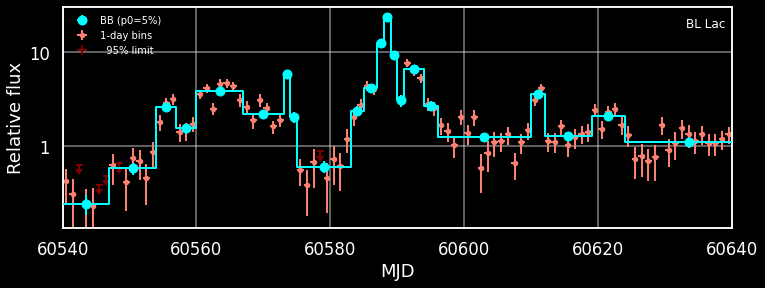

In [12]:
from wtlike import *
show(f"""# Quick study of a BL Lac  flare""")
with capture_hide('Printout') as out:
    wtl = WtLike('BL Lac', time_bins=(60540,0,1))
    bb = wtl.bb_view()
show(out)
bb.plot(xlim=(60540, 60640), yscale='log');